In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from ModelTrainer import ClassificationModelTrainer
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import optuna

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
LAMBDA_L2 = 0.0001

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

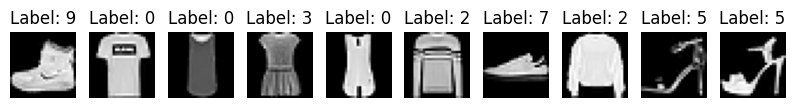

In [6]:
def show_images(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        image, label = dataset[i]
        
        image = image.numpy().squeeze()

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()

show_images(train_dataset)

# Q1.1

In [7]:
class FashionMNISTNet(nn.Module):
    def __init__(self):
        super(FashionMNISTNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
model_trainer = ClassificationModelTrainer(
    model=FashionMNISTNet(),
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    device=device,
    learning_rate=0.01,
    num_epochs=40
)

Epoch [1/40], Train Loss: 0.7381, Train Accuracy: 74.72%, Test Loss: 0.5350, Test Accuracy: 80.74%
Epoch [2/40], Train Loss: 0.5200, Train Accuracy: 81.55%, Test Loss: 0.4748, Test Accuracy: 82.54%
Epoch [3/40], Train Loss: 0.4697, Train Accuracy: 83.48%, Test Loss: 0.4489, Test Accuracy: 83.23%
Epoch [4/40], Train Loss: 0.4427, Train Accuracy: 84.28%, Test Loss: 0.4290, Test Accuracy: 84.51%
Epoch [5/40], Train Loss: 0.4219, Train Accuracy: 85.01%, Test Loss: 0.4129, Test Accuracy: 84.99%
Epoch [6/40], Train Loss: 0.4085, Train Accuracy: 85.53%, Test Loss: 0.4055, Test Accuracy: 85.11%
Epoch [7/40], Train Loss: 0.3966, Train Accuracy: 85.90%, Test Loss: 0.3979, Test Accuracy: 85.33%
Epoch [8/40], Train Loss: 0.3872, Train Accuracy: 86.11%, Test Loss: 0.3954, Test Accuracy: 85.48%
Epoch [9/40], Train Loss: 0.3793, Train Accuracy: 86.44%, Test Loss: 0.3895, Test Accuracy: 85.85%
Epoch [10/40], Train Loss: 0.3711, Train Accuracy: 86.77%, Test Loss: 0.3774, Test Accuracy: 86.40%
Epoch [11

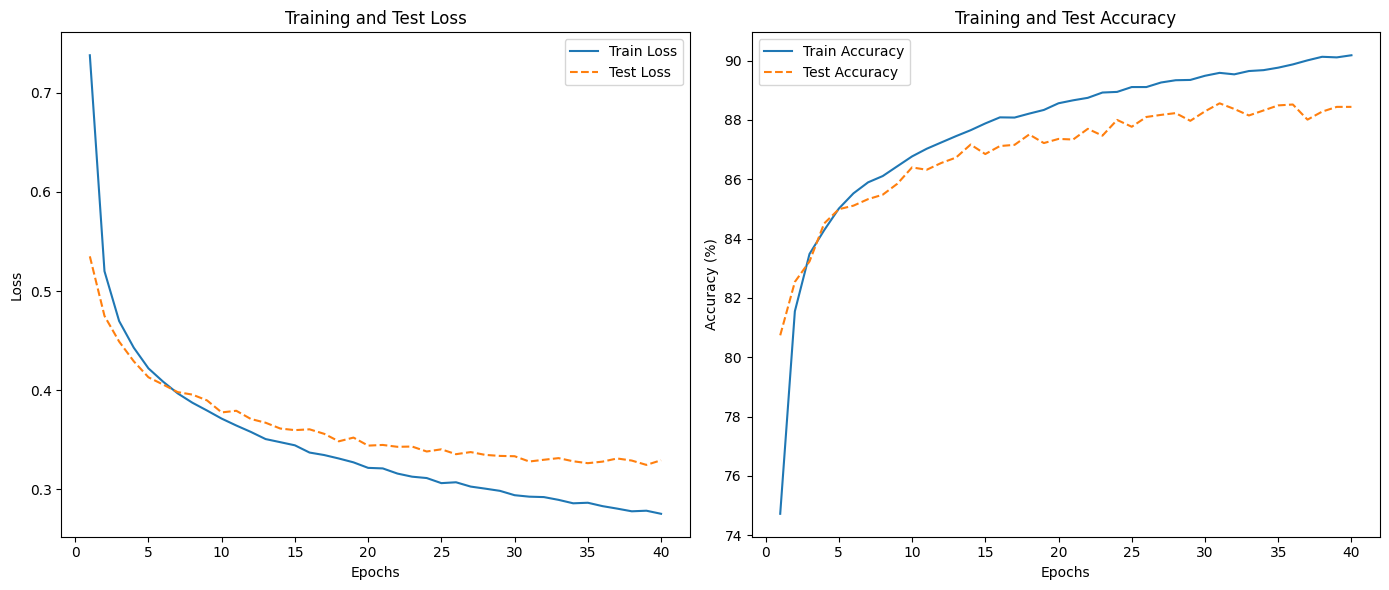

In [8]:
optimizer = optim.SGD(model_trainer.model.parameters(), lr=model_trainer.learning_rate, weight_decay=LAMBDA_L2)
model_trainer.train_with_optimizer(optimizer)

In [9]:
_, _, report = model_trainer.evaluate()
print(report)

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.85      0.85      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.78      0.84      0.81      1000
       Dress       0.85      0.92      0.88      1000
        Coat       0.85      0.76      0.80      1000
      Sandal       0.98      0.94      0.96      1000
       Shirt       0.71      0.69      0.70      1000
     Sneaker       0.93      0.94      0.94      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.94      0.97      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



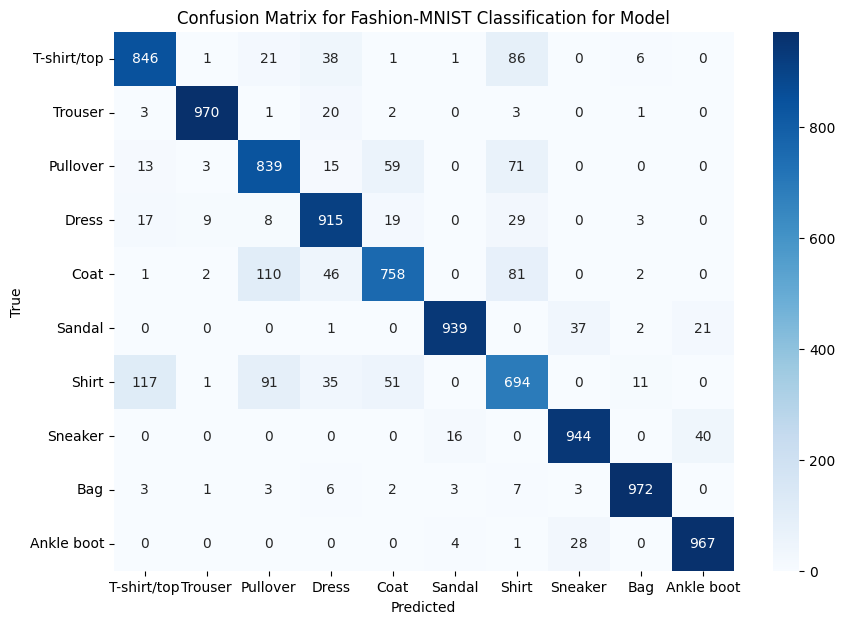

Two classes most confused with each other: Shirt and T-shirt/top


In [10]:
conf_matrix = model_trainer.plot_confusion_matrix()

In [11]:
classes = train_dataset.classes
for m in range(len(classes)):
    most_confused_with = np.argmax(conf_matrix[m])
    print(f"Class '{classes[m]}' is most confused with class '{classes[most_confused_with]}'.")

Class 'T-shirt/top' is most confused with class 'Shirt'.
Class 'Trouser' is most confused with class 'Dress'.
Class 'Pullover' is most confused with class 'Shirt'.
Class 'Dress' is most confused with class 'Shirt'.
Class 'Coat' is most confused with class 'Pullover'.
Class 'Sandal' is most confused with class 'Sneaker'.
Class 'Shirt' is most confused with class 'T-shirt/top'.
Class 'Sneaker' is most confused with class 'Ankle boot'.
Class 'Bag' is most confused with class 'Shirt'.
Class 'Ankle boot' is most confused with class 'Sneaker'.


# Q1.2

In [12]:
class MLPWithoutDropout(nn.Module):
    def __init__(self):
        super(MLPWithoutDropout, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class MLPWithDropout(nn.Module):
    def __init__(self):
        super(MLPWithDropout, self).__init__()
        self.fc1 = nn.Linear(28*28, 48)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(48, 10)      

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [13]:
model_trainer1 = ClassificationModelTrainer(MLPWithoutDropout(), train_dataset, test_dataset, device, learning_rate=0.01, num_epochs=40)
model_trainer2 = ClassificationModelTrainer(MLPWithDropout(), train_dataset, test_dataset, device, learning_rate=0.01, num_epochs=40)

Epoch [1/40], Train Loss: 0.6652, Train Accuracy: 77.55%, Test Loss: 0.5211, Test Accuracy: 81.40%
Epoch [2/40], Train Loss: 0.4660, Train Accuracy: 83.46%, Test Loss: 0.4733, Test Accuracy: 83.16%
Epoch [3/40], Train Loss: 0.4251, Train Accuracy: 84.93%, Test Loss: 0.4448, Test Accuracy: 84.31%
Epoch [4/40], Train Loss: 0.4004, Train Accuracy: 85.78%, Test Loss: 0.4197, Test Accuracy: 84.68%
Epoch [5/40], Train Loss: 0.3820, Train Accuracy: 86.41%, Test Loss: 0.4090, Test Accuracy: 85.12%
Epoch [6/40], Train Loss: 0.3675, Train Accuracy: 86.99%, Test Loss: 0.4106, Test Accuracy: 84.85%
Epoch [7/40], Train Loss: 0.3554, Train Accuracy: 87.42%, Test Loss: 0.4086, Test Accuracy: 85.47%
Epoch [8/40], Train Loss: 0.3447, Train Accuracy: 87.70%, Test Loss: 0.3819, Test Accuracy: 86.64%
Epoch [9/40], Train Loss: 0.3352, Train Accuracy: 88.01%, Test Loss: 0.3810, Test Accuracy: 86.54%
Epoch [10/40], Train Loss: 0.3272, Train Accuracy: 88.33%, Test Loss: 0.3845, Test Accuracy: 86.36%
Epoch [11

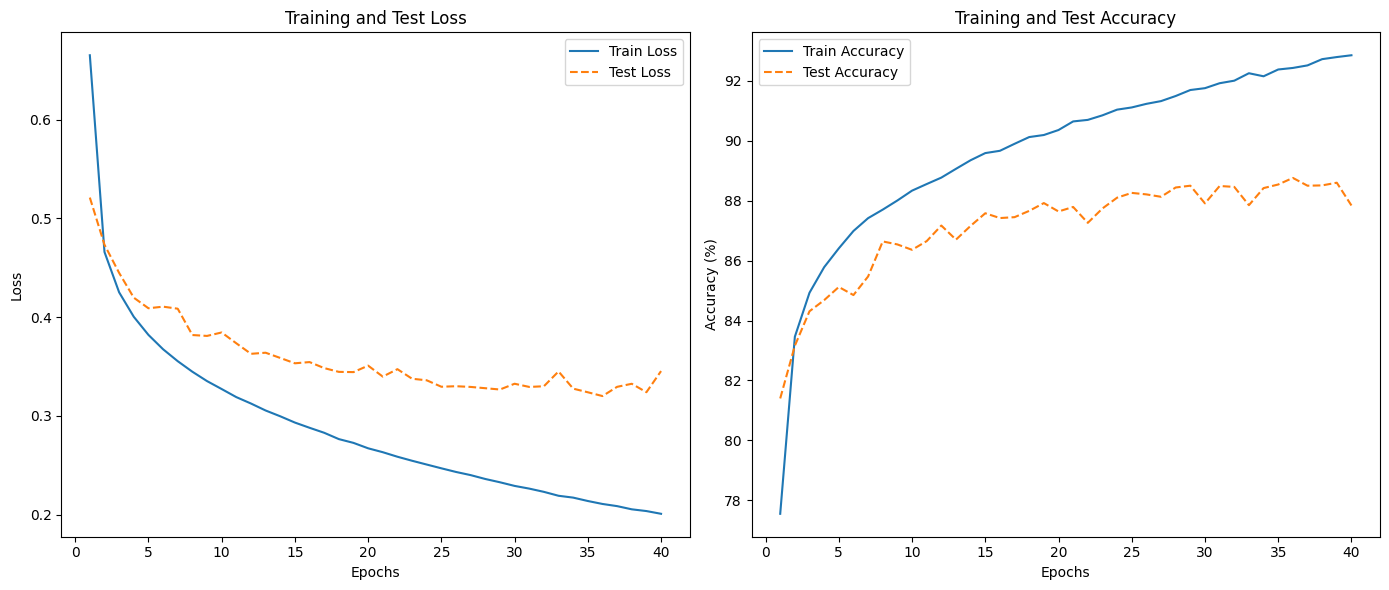



 First model is trained




In [14]:
optimizer1 = optim.SGD(model_trainer1.model.parameters(), lr=model_trainer1.learning_rate, weight_decay=0)
model_trainer1.train_with_optimizer(optimizer1)
print("\n\n First model is trained\n\n")

Epoch [1/40], Train Loss: 0.7656, Train Accuracy: 73.73%, Test Loss: 0.5352, Test Accuracy: 80.86%
Epoch [2/40], Train Loss: 0.5341, Train Accuracy: 81.22%, Test Loss: 0.4788, Test Accuracy: 82.54%
Epoch [3/40], Train Loss: 0.4825, Train Accuracy: 82.98%, Test Loss: 0.4547, Test Accuracy: 83.42%
Epoch [4/40], Train Loss: 0.4561, Train Accuracy: 83.83%, Test Loss: 0.4368, Test Accuracy: 83.95%
Epoch [5/40], Train Loss: 0.4380, Train Accuracy: 84.60%, Test Loss: 0.4302, Test Accuracy: 84.31%
Epoch [6/40], Train Loss: 0.4237, Train Accuracy: 85.09%, Test Loss: 0.4196, Test Accuracy: 84.53%
Epoch [7/40], Train Loss: 0.4118, Train Accuracy: 85.35%, Test Loss: 0.4138, Test Accuracy: 84.73%
Epoch [8/40], Train Loss: 0.4031, Train Accuracy: 85.69%, Test Loss: 0.4005, Test Accuracy: 85.18%
Epoch [9/40], Train Loss: 0.3967, Train Accuracy: 85.98%, Test Loss: 0.4019, Test Accuracy: 85.25%
Epoch [10/40], Train Loss: 0.3874, Train Accuracy: 86.22%, Test Loss: 0.3888, Test Accuracy: 85.67%
Epoch [11

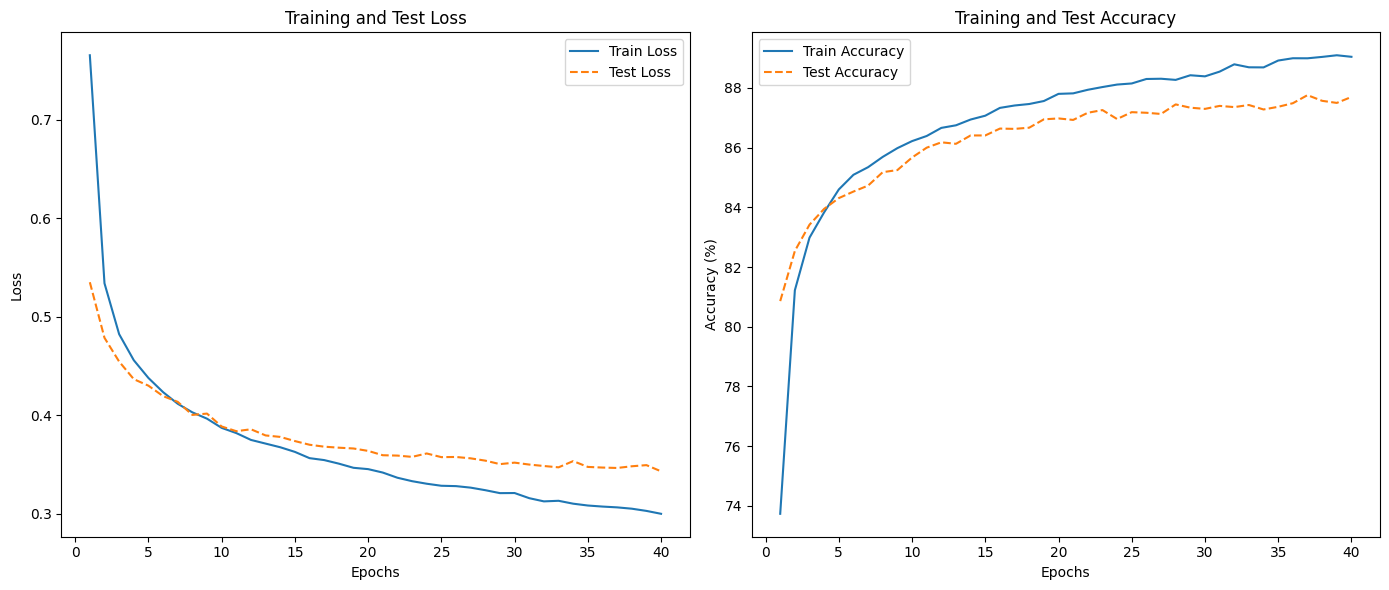



 Second model is trained


In [15]:
optimizer2 = optim.SGD(model_trainer2.model.parameters(), lr=model_trainer2.learning_rate, weight_decay=0.0001)
model_trainer2.train_with_optimizer(optimizer2)
print("\n\n Second model is trained")

In [16]:
_, _, report1 = model_trainer1.evaluate()
print(report1)
_, _, report2 = model_trainer2.evaluate()
print(report2)

              precision    recall  f1-score   support

 T-shirt/top       0.81      0.87      0.84      1000
     Trouser       0.99      0.95      0.97      1000
    Pullover       0.68      0.90      0.78      1000
       Dress       0.86      0.91      0.89      1000
        Coat       0.86      0.70      0.77      1000
      Sandal       0.97      0.94      0.96      1000
       Shirt       0.79      0.62      0.70      1000
     Sneaker       0.93      0.96      0.95      1000
         Bag       0.97      0.96      0.96      1000
  Ankle boot       0.95      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

              precision    recall  f1-score   support

 T-shirt/top       0.80      0.86      0.83      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.82      0.77      0.79      1000
       Dress       0.88 

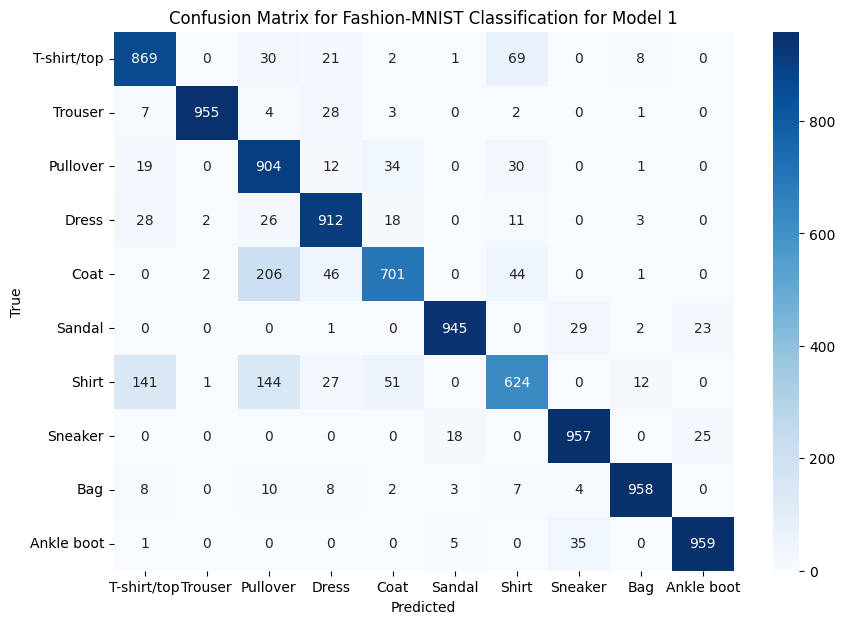

Two classes most confused with each other: Coat and Pullover


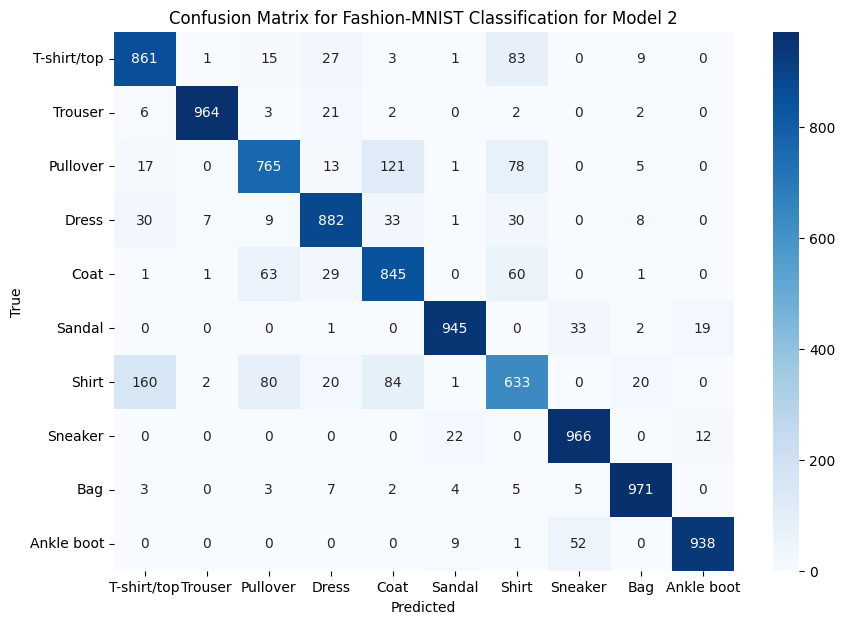

Two classes most confused with each other: Shirt and T-shirt/top


In [ ]:
_ = model_trainer1.plot_confusion_matrix(model_name="MLPWithoutDropout")
_ = model_trainer2.plot_confusion_matrix(model_name="MLPWithDropout")

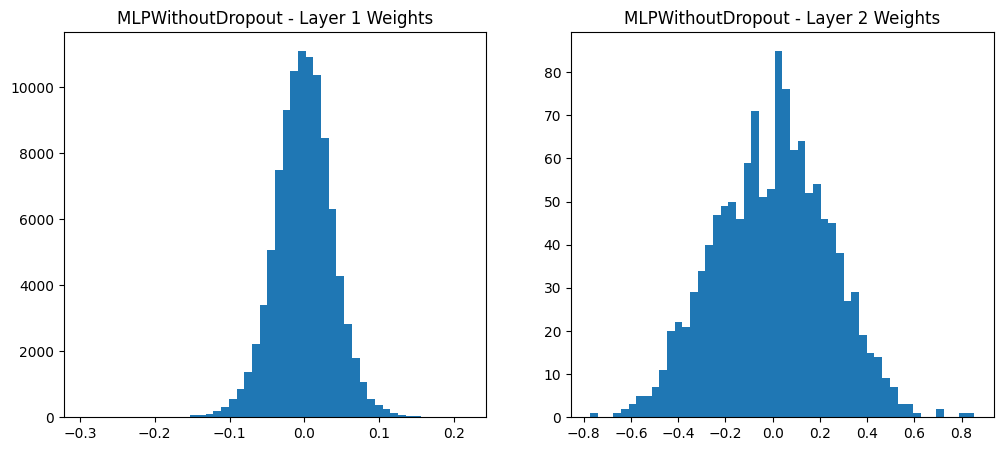

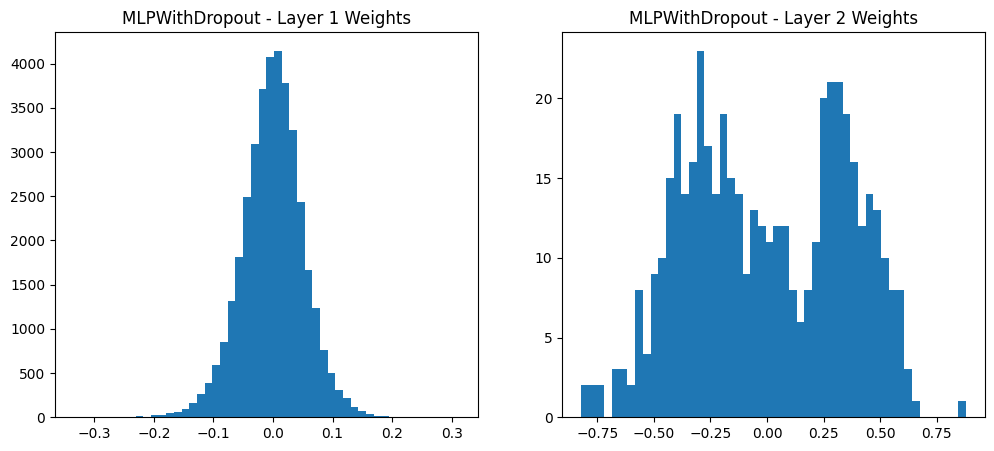

In [ ]:
model_trainer1.plot_weight_histograms(model_name="MLPWithoutDropout")
model_trainer2.plot_weight_histograms(model_name="MLPWithDropout")

# Q1.3


Training with Adam optimizer...

Epoch [1/40], Train Loss: 0.5491, Train Accuracy: 80.18%, Test Loss: 0.4487, Test Accuracy: 83.59%
Epoch [2/40], Train Loss: 0.4394, Train Accuracy: 84.06%, Test Loss: 0.4148, Test Accuracy: 85.12%
Epoch [3/40], Train Loss: 0.4120, Train Accuracy: 85.07%, Test Loss: 0.3963, Test Accuracy: 85.62%
Epoch [4/40], Train Loss: 0.3930, Train Accuracy: 85.55%, Test Loss: 0.3926, Test Accuracy: 86.03%
Epoch [5/40], Train Loss: 0.3802, Train Accuracy: 86.07%, Test Loss: 0.3857, Test Accuracy: 85.91%
Epoch [6/40], Train Loss: 0.3669, Train Accuracy: 86.59%, Test Loss: 0.3638, Test Accuracy: 86.86%
Epoch [7/40], Train Loss: 0.3639, Train Accuracy: 86.78%, Test Loss: 0.3725, Test Accuracy: 86.91%
Epoch [8/40], Train Loss: 0.3547, Train Accuracy: 86.97%, Test Loss: 0.3628, Test Accuracy: 87.14%
Epoch [9/40], Train Loss: 0.3509, Train Accuracy: 87.03%, Test Loss: 0.3638, Test Accuracy: 86.47%
Epoch [10/40], Train Loss: 0.3429, Train Accuracy: 87.34%, Test Loss: 0.366

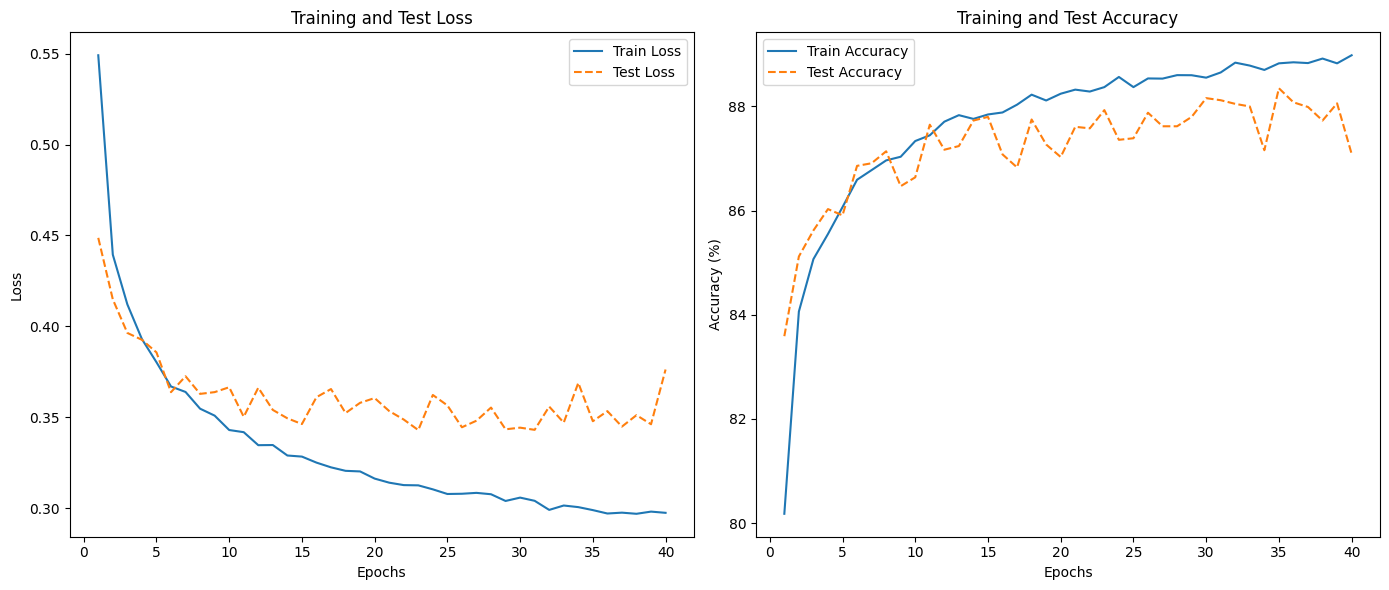


Training with Nadam optimizer...

Epoch [1/40], Train Loss: 0.5391, Train Accuracy: 80.65%, Test Loss: 0.4353, Test Accuracy: 83.81%
Epoch [2/40], Train Loss: 0.4275, Train Accuracy: 84.45%, Test Loss: 0.4007, Test Accuracy: 85.71%
Epoch [3/40], Train Loss: 0.4004, Train Accuracy: 85.30%, Test Loss: 0.3830, Test Accuracy: 86.25%
Epoch [4/40], Train Loss: 0.3833, Train Accuracy: 85.96%, Test Loss: 0.3863, Test Accuracy: 85.97%
Epoch [5/40], Train Loss: 0.3746, Train Accuracy: 86.30%, Test Loss: 0.3797, Test Accuracy: 86.38%
Epoch [6/40], Train Loss: 0.3645, Train Accuracy: 86.63%, Test Loss: 0.3671, Test Accuracy: 86.77%
Epoch [7/40], Train Loss: 0.3569, Train Accuracy: 86.98%, Test Loss: 0.3732, Test Accuracy: 86.37%
Epoch [8/40], Train Loss: 0.3524, Train Accuracy: 87.07%, Test Loss: 0.3699, Test Accuracy: 86.54%
Epoch [9/40], Train Loss: 0.3478, Train Accuracy: 87.31%, Test Loss: 0.3680, Test Accuracy: 86.80%
Epoch [10/40], Train Loss: 0.3405, Train Accuracy: 87.52%, Test Loss: 0.36

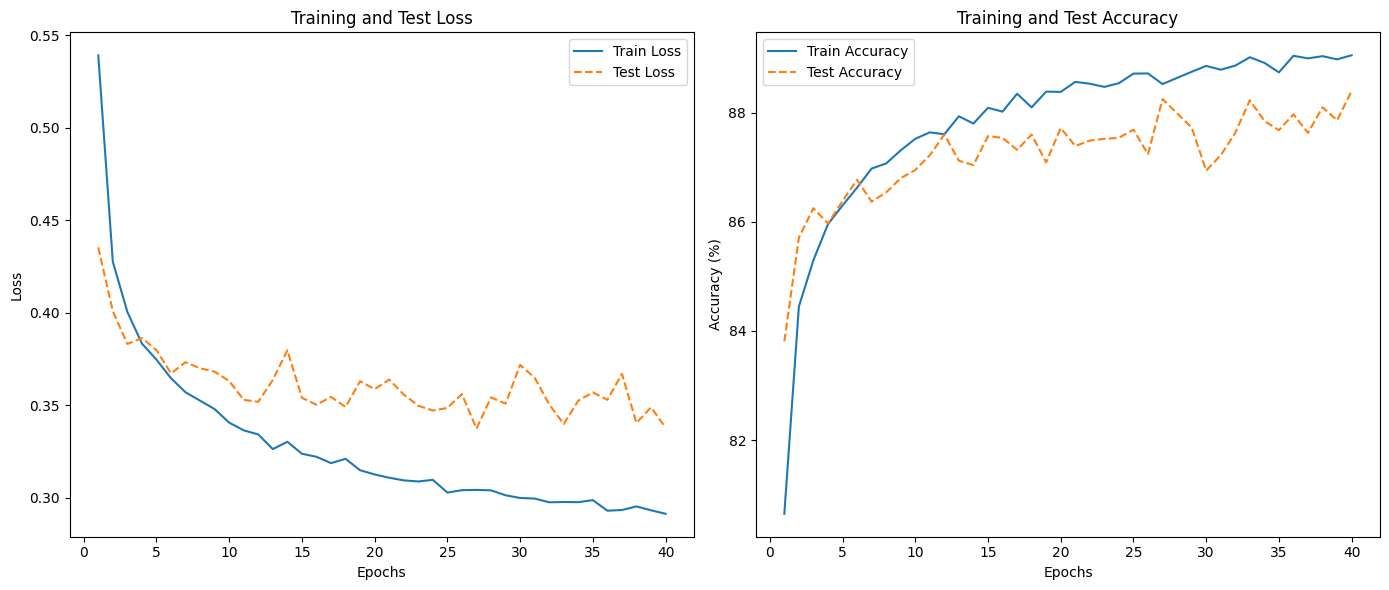


Training with RMSprop optimizer...

Epoch [1/40], Train Loss: 0.5506, Train Accuracy: 80.17%, Test Loss: 0.4628, Test Accuracy: 82.51%
Epoch [2/40], Train Loss: 0.4429, Train Accuracy: 84.03%, Test Loss: 0.4132, Test Accuracy: 85.16%
Epoch [3/40], Train Loss: 0.4149, Train Accuracy: 84.92%, Test Loss: 0.4161, Test Accuracy: 84.89%
Epoch [4/40], Train Loss: 0.3992, Train Accuracy: 85.37%, Test Loss: 0.3856, Test Accuracy: 85.96%
Epoch [5/40], Train Loss: 0.3866, Train Accuracy: 86.06%, Test Loss: 0.3982, Test Accuracy: 85.91%
Epoch [6/40], Train Loss: 0.3774, Train Accuracy: 86.20%, Test Loss: 0.3786, Test Accuracy: 86.62%
Epoch [7/40], Train Loss: 0.3707, Train Accuracy: 86.44%, Test Loss: 0.3621, Test Accuracy: 87.16%
Epoch [8/40], Train Loss: 0.3629, Train Accuracy: 86.72%, Test Loss: 0.3794, Test Accuracy: 86.58%
Epoch [9/40], Train Loss: 0.3592, Train Accuracy: 86.85%, Test Loss: 0.3619, Test Accuracy: 87.20%
Epoch [10/40], Train Loss: 0.3543, Train Accuracy: 86.99%, Test Loss: 0.

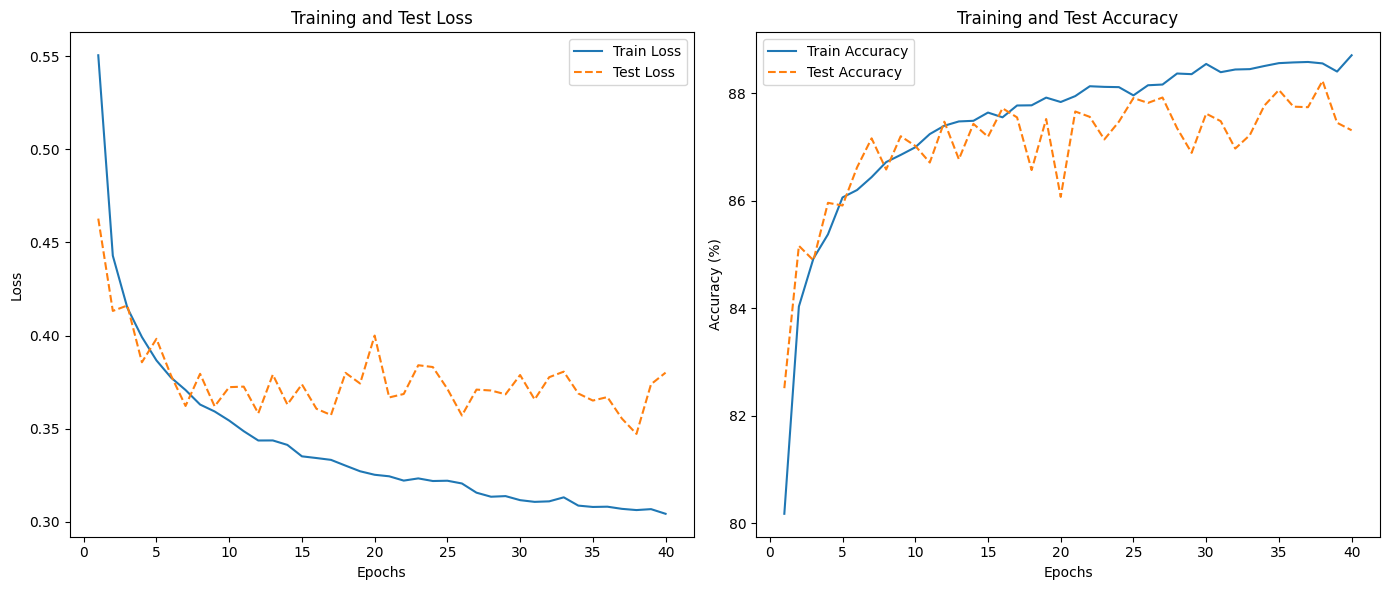


Training with SGD optimizer...

Epoch [1/40], Train Loss: 1.4438, Train Accuracy: 56.15%, Test Loss: 0.9424, Test Accuracy: 72.29%
Epoch [2/40], Train Loss: 0.8768, Train Accuracy: 70.73%, Test Loss: 0.7456, Test Accuracy: 74.97%
Epoch [3/40], Train Loss: 0.7520, Train Accuracy: 73.85%, Test Loss: 0.6734, Test Accuracy: 76.58%
Epoch [4/40], Train Loss: 0.6913, Train Accuracy: 75.64%, Test Loss: 0.6317, Test Accuracy: 77.46%
Epoch [5/40], Train Loss: 0.6484, Train Accuracy: 77.31%, Test Loss: 0.6026, Test Accuracy: 78.63%
Epoch [6/40], Train Loss: 0.6191, Train Accuracy: 78.28%, Test Loss: 0.5797, Test Accuracy: 79.34%
Epoch [7/40], Train Loss: 0.5962, Train Accuracy: 79.12%, Test Loss: 0.5619, Test Accuracy: 79.75%
Epoch [8/40], Train Loss: 0.5795, Train Accuracy: 79.53%, Test Loss: 0.5477, Test Accuracy: 80.42%
Epoch [9/40], Train Loss: 0.5618, Train Accuracy: 80.31%, Test Loss: 0.5346, Test Accuracy: 80.68%
Epoch [10/40], Train Loss: 0.5490, Train Accuracy: 80.72%, Test Loss: 0.5244

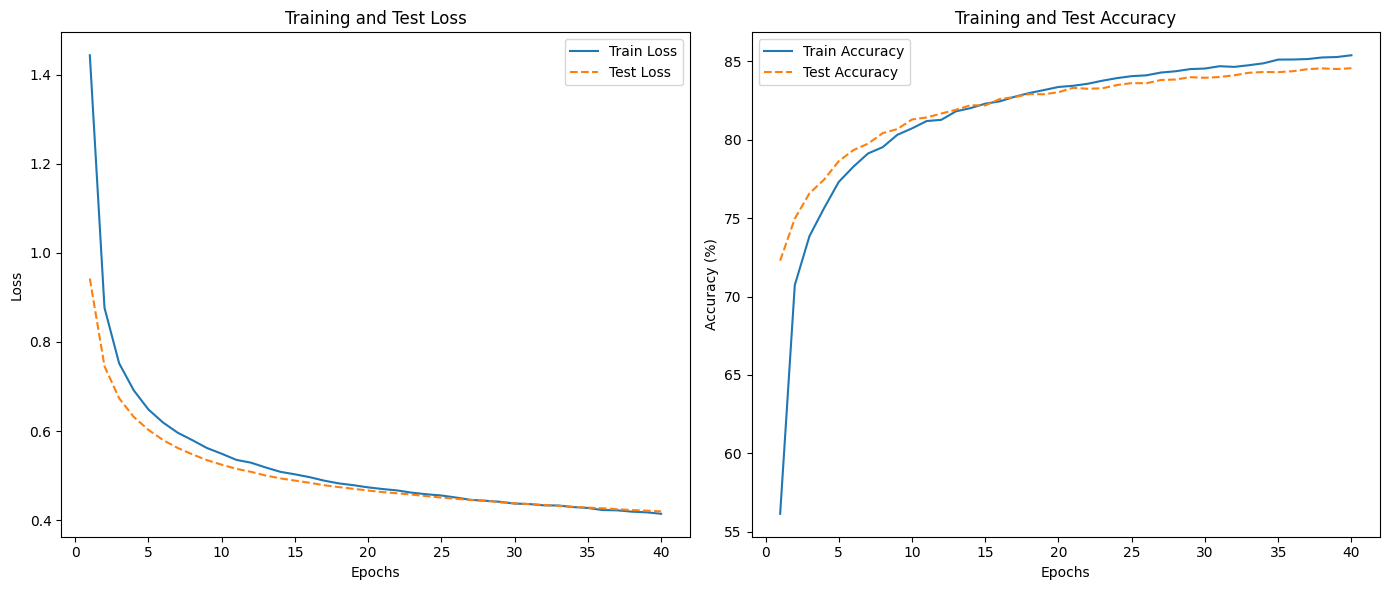

In [7]:
results = {}

optimizers = {
    "Adam": lambda params: optim.Adam(params, lr=0.001, weight_decay=LAMBDA_L2),
    "Nadam": lambda params: optim.NAdam(params, lr=0.001, weight_decay=LAMBDA_L2),
    "RMSprop": lambda params: optim.RMSprop(params, lr=0.001, weight_decay=LAMBDA_L2),
    "SGD" : lambda params: optim.SGD(params, lr = 0.001, weight_decay=LAMBDA_L2)
}

for optimizer_name, optimizer_func in optimizers.items():
    print(f"\nTraining with {optimizer_name} optimizer...\n")
    
    model = FashionMNISTNet()
    trainer = ClassificationModelTrainer(
        model=model,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        device=device,
        learning_rate=0.001,
        num_epochs=40
    )
    
    optimizer = optimizer_func(trainer.model.parameters())
    
    trainer.train_with_optimizer(optimizer)
    
    results[optimizer_name] = {
        "loss": trainer.train_losses,
        "accuracy": trainer.test_accuracies
    }

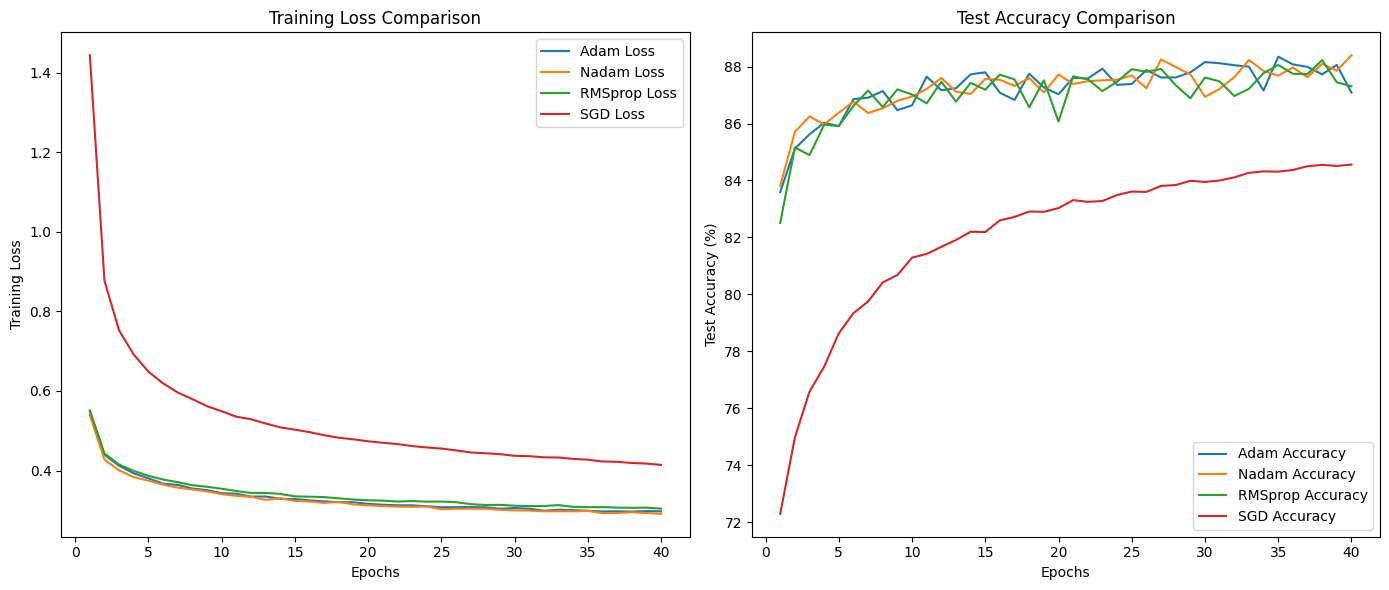

In [10]:
epochs = range(1, trainer.num_epochs + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for optimizer_name in results:
    plt.plot(epochs, results[optimizer_name]["loss"], label=f"{optimizer_name} Loss")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss Comparison")
plt.legend()

plt.subplot(1, 2, 2)
for optimizer_name in results:
    plt.plot(epochs, results[optimizer_name]["accuracy"], label=f"{optimizer_name} Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy Comparison")
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
def objective(trial):
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "Nadam", "RMSprop", "SGD"])

    model = FashionMNISTNet().to(device)
    learning_rate = 0.001

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=LAMBDA_L2)
    elif optimizer_name == "Nadam":
        optimizer = optim.NAdam(model.parameters(), lr=learning_rate, weight_decay=LAMBDA_L2)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=LAMBDA_L2)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA_L2)

    trainer = ClassificationModelTrainer(
        model=model,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        device=device,
        learning_rate=learning_rate,
        num_epochs=10
    )

    trainer.train_with_optimizer(optimizer)
    _, test_accuracy, _ = trainer.evaluate()

    return test_accuracy

[I 2024-11-09 00:38:55,617] A new study created in memory with name: no-name-6fbeb074-24b7-430c-832b-d2d21bb888de


Epoch [1/10], Train Loss: 1.4329, Train Accuracy: 56.86%, Test Loss: 0.9454, Test Accuracy: 71.91%
Epoch [2/10], Train Loss: 0.8768, Train Accuracy: 70.77%, Test Loss: 0.7451, Test Accuracy: 74.63%
Epoch [3/10], Train Loss: 0.7519, Train Accuracy: 73.80%, Test Loss: 0.6724, Test Accuracy: 76.28%
Epoch [4/10], Train Loss: 0.6907, Train Accuracy: 75.62%, Test Loss: 0.6305, Test Accuracy: 77.36%
Epoch [5/10], Train Loss: 0.6499, Train Accuracy: 76.96%, Test Loss: 0.6024, Test Accuracy: 78.27%
Epoch [6/10], Train Loss: 0.6224, Train Accuracy: 78.07%, Test Loss: 0.5794, Test Accuracy: 79.07%
Epoch [7/10], Train Loss: 0.5981, Train Accuracy: 78.80%, Test Loss: 0.5614, Test Accuracy: 79.74%
Epoch [8/10], Train Loss: 0.5797, Train Accuracy: 79.53%, Test Loss: 0.5477, Test Accuracy: 79.98%
Epoch [9/10], Train Loss: 0.5633, Train Accuracy: 80.22%, Test Loss: 0.5352, Test Accuracy: 80.72%
Epoch [10/10], Train Loss: 0.5503, Train Accuracy: 80.62%, Test Loss: 0.5242, Test Accuracy: 80.91%


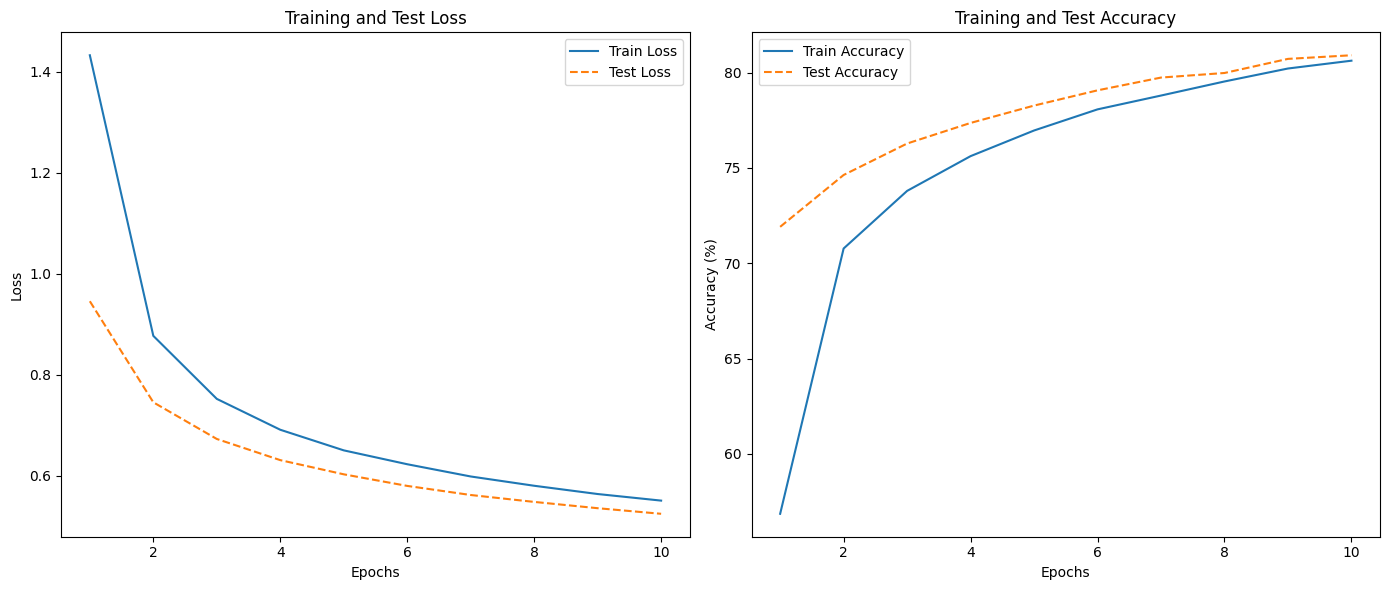

[I 2024-11-09 00:41:47,041] Trial 0 finished with value: 80.91 and parameters: {'optimizer': 'SGD'}. Best is trial 0 with value: 80.91.


Epoch [1/10], Train Loss: 0.5554, Train Accuracy: 79.98%, Test Loss: 0.4363, Test Accuracy: 83.73%
Epoch [2/10], Train Loss: 0.4414, Train Accuracy: 84.05%, Test Loss: 0.4116, Test Accuracy: 85.03%
Epoch [3/10], Train Loss: 0.4140, Train Accuracy: 84.86%, Test Loss: 0.3881, Test Accuracy: 85.95%
Epoch [4/10], Train Loss: 0.3964, Train Accuracy: 85.56%, Test Loss: 0.3837, Test Accuracy: 86.13%
Epoch [5/10], Train Loss: 0.3833, Train Accuracy: 86.00%, Test Loss: 0.3881, Test Accuracy: 85.92%
Epoch [6/10], Train Loss: 0.3726, Train Accuracy: 86.33%, Test Loss: 0.3843, Test Accuracy: 86.55%
Epoch [7/10], Train Loss: 0.3639, Train Accuracy: 86.63%, Test Loss: 0.3705, Test Accuracy: 86.36%
Epoch [8/10], Train Loss: 0.3585, Train Accuracy: 86.86%, Test Loss: 0.3987, Test Accuracy: 86.15%
Epoch [9/10], Train Loss: 0.3547, Train Accuracy: 86.95%, Test Loss: 0.3733, Test Accuracy: 86.42%
Epoch [10/10], Train Loss: 0.3459, Train Accuracy: 87.09%, Test Loss: 0.3635, Test Accuracy: 87.15%


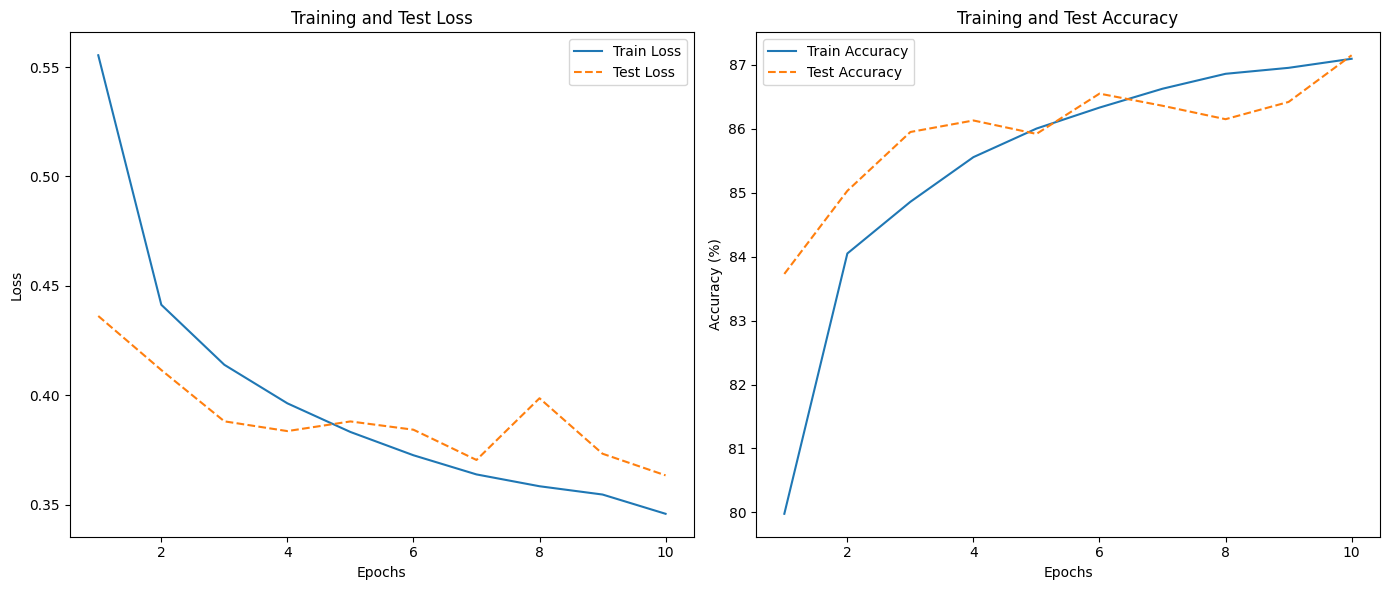

[I 2024-11-09 00:44:46,604] Trial 1 finished with value: 87.15 and parameters: {'optimizer': 'Adam'}. Best is trial 1 with value: 87.15.


Epoch [1/10], Train Loss: 0.5557, Train Accuracy: 79.98%, Test Loss: 0.4381, Test Accuracy: 83.70%
Epoch [2/10], Train Loss: 0.4432, Train Accuracy: 83.92%, Test Loss: 0.4115, Test Accuracy: 85.25%
Epoch [3/10], Train Loss: 0.4153, Train Accuracy: 84.81%, Test Loss: 0.4196, Test Accuracy: 84.95%
Epoch [4/10], Train Loss: 0.3984, Train Accuracy: 85.64%, Test Loss: 0.3873, Test Accuracy: 86.11%
Epoch [5/10], Train Loss: 0.3883, Train Accuracy: 85.92%, Test Loss: 0.3697, Test Accuracy: 86.65%
Epoch [6/10], Train Loss: 0.3744, Train Accuracy: 86.33%, Test Loss: 0.3712, Test Accuracy: 86.68%
Epoch [7/10], Train Loss: 0.3680, Train Accuracy: 86.59%, Test Loss: 0.3821, Test Accuracy: 85.90%
Epoch [8/10], Train Loss: 0.3634, Train Accuracy: 86.69%, Test Loss: 0.3693, Test Accuracy: 86.95%
Epoch [9/10], Train Loss: 0.3581, Train Accuracy: 87.03%, Test Loss: 0.3759, Test Accuracy: 86.77%
Epoch [10/10], Train Loss: 0.3539, Train Accuracy: 87.09%, Test Loss: 0.3770, Test Accuracy: 86.62%


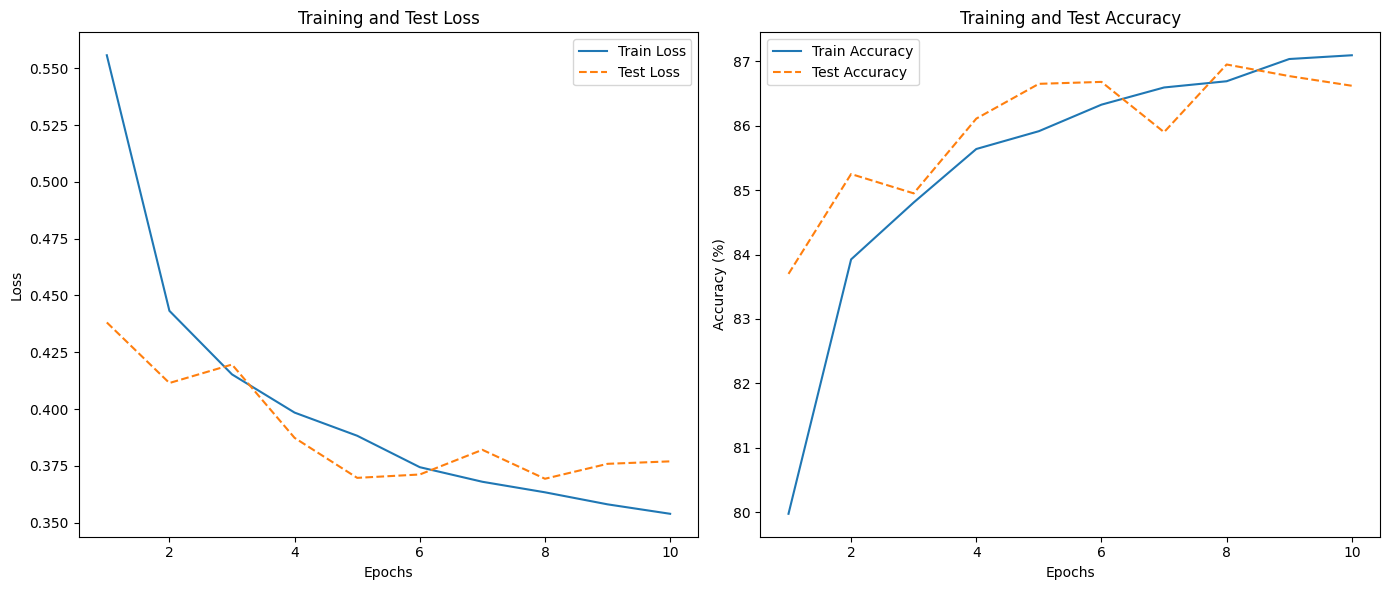

[I 2024-11-09 00:47:41,650] Trial 2 finished with value: 86.62 and parameters: {'optimizer': 'RMSprop'}. Best is trial 1 with value: 87.15.


Epoch [1/10], Train Loss: 0.5413, Train Accuracy: 80.44%, Test Loss: 0.4465, Test Accuracy: 83.36%
Epoch [2/10], Train Loss: 0.4266, Train Accuracy: 84.38%, Test Loss: 0.4188, Test Accuracy: 84.47%
Epoch [3/10], Train Loss: 0.3983, Train Accuracy: 85.41%, Test Loss: 0.3930, Test Accuracy: 85.61%
Epoch [4/10], Train Loss: 0.3838, Train Accuracy: 86.05%, Test Loss: 0.3798, Test Accuracy: 86.23%
Epoch [5/10], Train Loss: 0.3701, Train Accuracy: 86.42%, Test Loss: 0.3787, Test Accuracy: 86.19%
Epoch [6/10], Train Loss: 0.3633, Train Accuracy: 86.72%, Test Loss: 0.3817, Test Accuracy: 86.11%
Epoch [7/10], Train Loss: 0.3567, Train Accuracy: 86.98%, Test Loss: 0.3632, Test Accuracy: 86.71%
Epoch [8/10], Train Loss: 0.3503, Train Accuracy: 87.22%, Test Loss: 0.3559, Test Accuracy: 87.27%
Epoch [9/10], Train Loss: 0.3443, Train Accuracy: 87.25%, Test Loss: 0.3782, Test Accuracy: 86.54%
Epoch [10/10], Train Loss: 0.3388, Train Accuracy: 87.48%, Test Loss: 0.3810, Test Accuracy: 86.14%


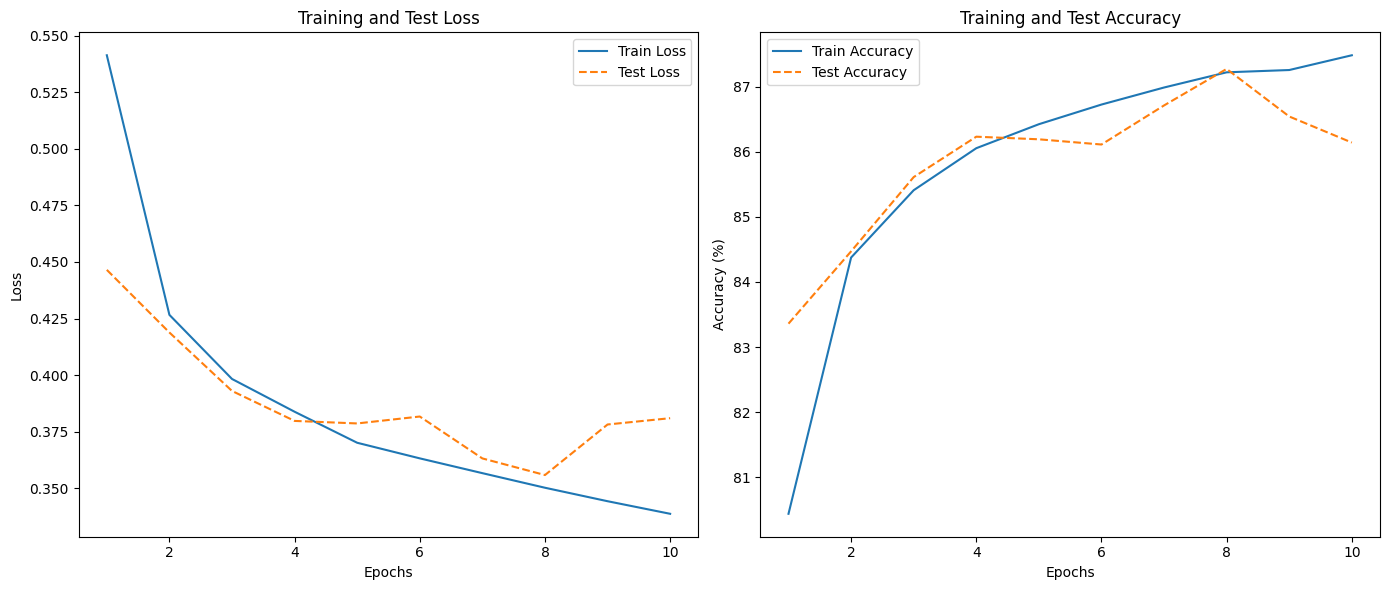

[I 2024-11-09 00:50:43,887] Trial 3 finished with value: 86.14 and parameters: {'optimizer': 'Nadam'}. Best is trial 1 with value: 87.15.


Epoch [1/10], Train Loss: 1.4416, Train Accuracy: 56.30%, Test Loss: 0.9395, Test Accuracy: 72.08%
Epoch [2/10], Train Loss: 0.8788, Train Accuracy: 70.64%, Test Loss: 0.7410, Test Accuracy: 75.11%
Epoch [3/10], Train Loss: 0.7503, Train Accuracy: 73.84%, Test Loss: 0.6677, Test Accuracy: 76.61%
Epoch [4/10], Train Loss: 0.6883, Train Accuracy: 75.82%, Test Loss: 0.6259, Test Accuracy: 77.85%
Epoch [5/10], Train Loss: 0.6467, Train Accuracy: 77.28%, Test Loss: 0.5977, Test Accuracy: 78.69%
Epoch [6/10], Train Loss: 0.6170, Train Accuracy: 78.27%, Test Loss: 0.5750, Test Accuracy: 79.50%
Epoch [7/10], Train Loss: 0.5932, Train Accuracy: 79.20%, Test Loss: 0.5577, Test Accuracy: 80.25%
Epoch [8/10], Train Loss: 0.5730, Train Accuracy: 79.92%, Test Loss: 0.5435, Test Accuracy: 80.53%
Epoch [9/10], Train Loss: 0.5598, Train Accuracy: 80.29%, Test Loss: 0.5313, Test Accuracy: 81.13%
Epoch [10/10], Train Loss: 0.5440, Train Accuracy: 80.88%, Test Loss: 0.5213, Test Accuracy: 81.41%


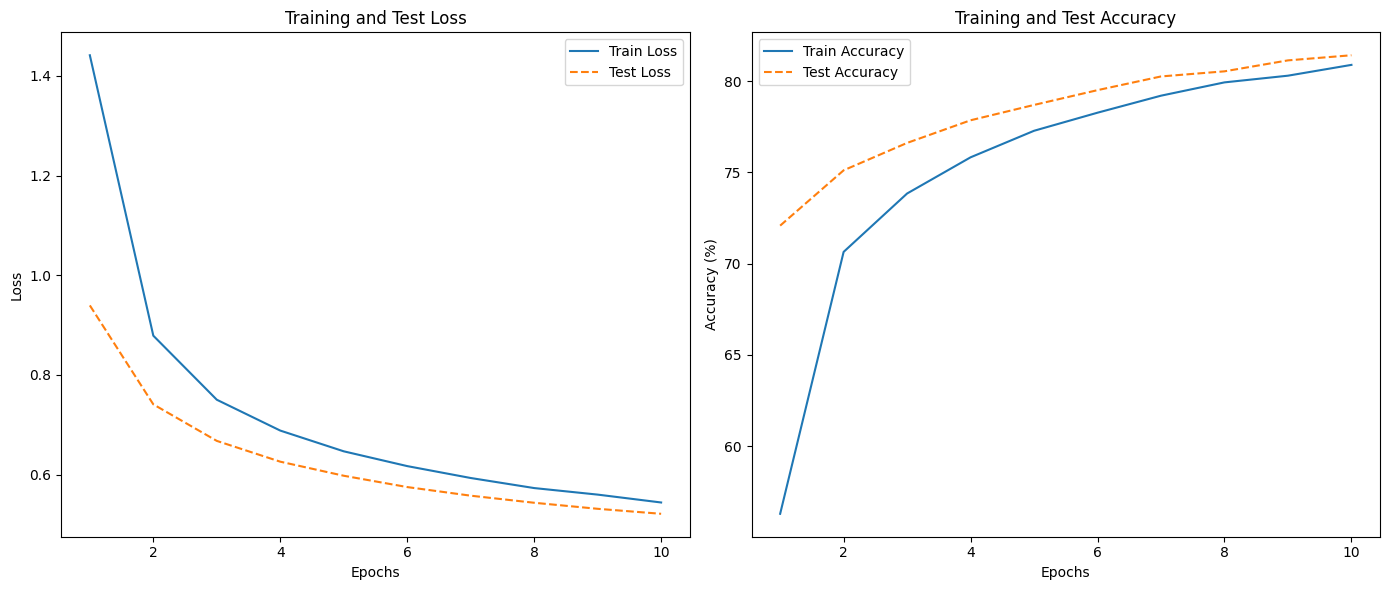

[I 2024-11-09 00:53:36,182] Trial 4 finished with value: 81.41 and parameters: {'optimizer': 'SGD'}. Best is trial 1 with value: 87.15.


Epoch [1/10], Train Loss: 1.4290, Train Accuracy: 56.92%, Test Loss: 0.9407, Test Accuracy: 72.10%
Epoch [2/10], Train Loss: 0.8806, Train Accuracy: 70.25%, Test Loss: 0.7500, Test Accuracy: 74.25%
Epoch [3/10], Train Loss: 0.7574, Train Accuracy: 73.58%, Test Loss: 0.6772, Test Accuracy: 76.09%
Epoch [4/10], Train Loss: 0.6965, Train Accuracy: 75.43%, Test Loss: 0.6365, Test Accuracy: 77.16%
Epoch [5/10], Train Loss: 0.6567, Train Accuracy: 76.97%, Test Loss: 0.6059, Test Accuracy: 78.19%
Epoch [6/10], Train Loss: 0.6266, Train Accuracy: 77.99%, Test Loss: 0.5834, Test Accuracy: 79.07%
Epoch [7/10], Train Loss: 0.6013, Train Accuracy: 78.81%, Test Loss: 0.5662, Test Accuracy: 79.70%
Epoch [8/10], Train Loss: 0.5847, Train Accuracy: 79.29%, Test Loss: 0.5512, Test Accuracy: 80.16%
Epoch [9/10], Train Loss: 0.5696, Train Accuracy: 79.88%, Test Loss: 0.5402, Test Accuracy: 80.70%
Epoch [10/10], Train Loss: 0.5548, Train Accuracy: 80.49%, Test Loss: 0.5291, Test Accuracy: 80.91%


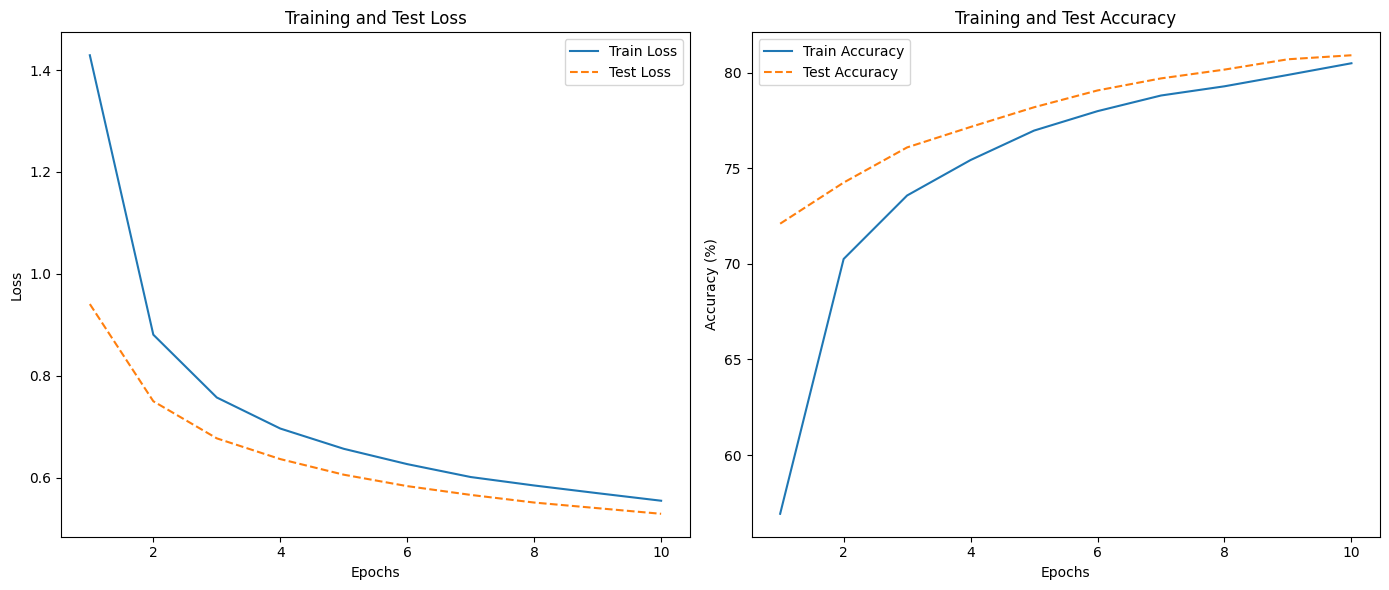

[I 2024-11-09 00:56:19,956] Trial 5 finished with value: 80.91 and parameters: {'optimizer': 'SGD'}. Best is trial 1 with value: 87.15.


Epoch [1/10], Train Loss: 0.5408, Train Accuracy: 80.45%, Test Loss: 0.4324, Test Accuracy: 84.22%
Epoch [2/10], Train Loss: 0.4289, Train Accuracy: 84.41%, Test Loss: 0.4301, Test Accuracy: 84.51%
Epoch [3/10], Train Loss: 0.3981, Train Accuracy: 85.44%, Test Loss: 0.3827, Test Accuracy: 86.42%
Epoch [4/10], Train Loss: 0.3837, Train Accuracy: 85.95%, Test Loss: 0.3865, Test Accuracy: 85.82%
Epoch [5/10], Train Loss: 0.3702, Train Accuracy: 86.50%, Test Loss: 0.3715, Test Accuracy: 86.34%
Epoch [6/10], Train Loss: 0.3596, Train Accuracy: 86.80%, Test Loss: 0.3623, Test Accuracy: 86.76%
Epoch [7/10], Train Loss: 0.3518, Train Accuracy: 87.12%, Test Loss: 0.3576, Test Accuracy: 87.18%
Epoch [8/10], Train Loss: 0.3454, Train Accuracy: 87.42%, Test Loss: 0.3676, Test Accuracy: 86.85%
Epoch [9/10], Train Loss: 0.3427, Train Accuracy: 87.28%, Test Loss: 0.3465, Test Accuracy: 87.55%
Epoch [10/10], Train Loss: 0.3349, Train Accuracy: 87.75%, Test Loss: 0.3554, Test Accuracy: 87.32%


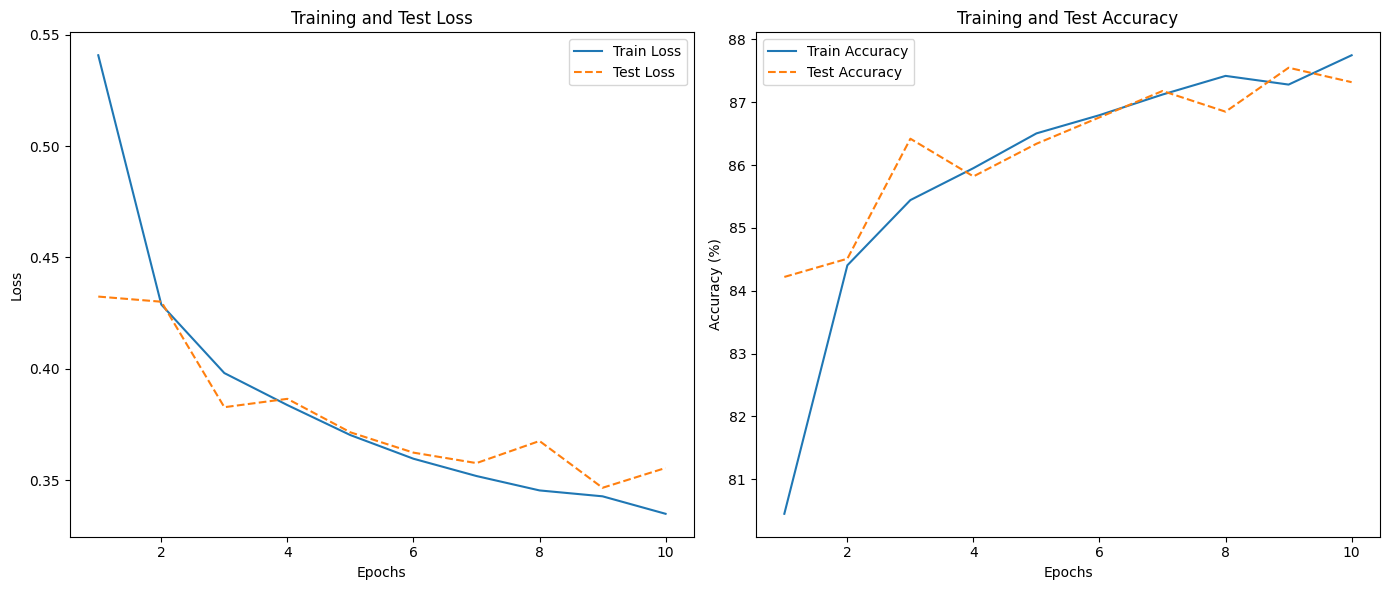

[I 2024-11-09 00:59:19,483] Trial 6 finished with value: 87.32 and parameters: {'optimizer': 'Nadam'}. Best is trial 6 with value: 87.32.


Epoch [1/10], Train Loss: 0.5567, Train Accuracy: 79.90%, Test Loss: 0.4322, Test Accuracy: 84.44%
Epoch [2/10], Train Loss: 0.4489, Train Accuracy: 83.71%, Test Loss: 0.4250, Test Accuracy: 84.45%
Epoch [3/10], Train Loss: 0.4182, Train Accuracy: 84.78%, Test Loss: 0.4028, Test Accuracy: 85.20%
Epoch [4/10], Train Loss: 0.4016, Train Accuracy: 85.38%, Test Loss: 0.3854, Test Accuracy: 85.83%
Epoch [5/10], Train Loss: 0.3887, Train Accuracy: 85.75%, Test Loss: 0.3903, Test Accuracy: 86.21%
Epoch [6/10], Train Loss: 0.3780, Train Accuracy: 86.25%, Test Loss: 0.3769, Test Accuracy: 86.54%
Epoch [7/10], Train Loss: 0.3700, Train Accuracy: 86.26%, Test Loss: 0.3726, Test Accuracy: 86.59%
Epoch [8/10], Train Loss: 0.3651, Train Accuracy: 86.62%, Test Loss: 0.3899, Test Accuracy: 86.17%
Epoch [9/10], Train Loss: 0.3613, Train Accuracy: 86.75%, Test Loss: 0.3711, Test Accuracy: 86.82%
Epoch [10/10], Train Loss: 0.3536, Train Accuracy: 86.94%, Test Loss: 0.3716, Test Accuracy: 87.09%


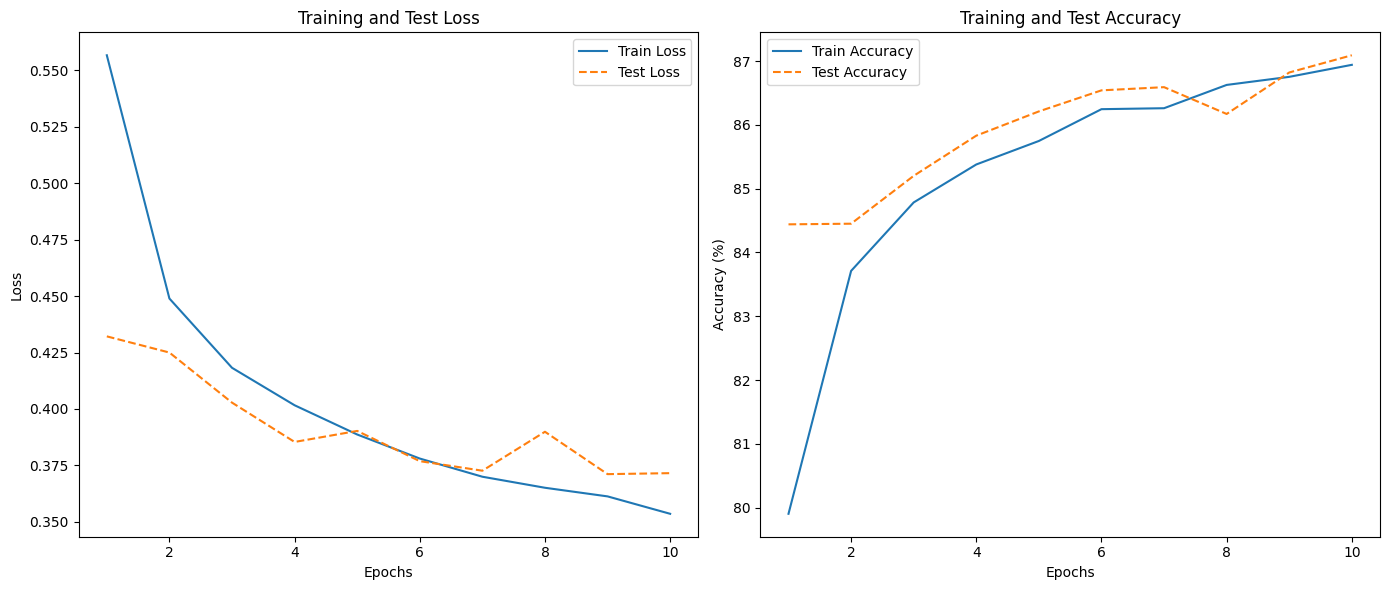

[I 2024-11-09 01:02:07,455] Trial 7 finished with value: 87.09 and parameters: {'optimizer': 'RMSprop'}. Best is trial 6 with value: 87.32.


Epoch [1/10], Train Loss: 0.5423, Train Accuracy: 80.60%, Test Loss: 0.4321, Test Accuracy: 83.63%
Epoch [2/10], Train Loss: 0.4310, Train Accuracy: 84.28%, Test Loss: 0.4158, Test Accuracy: 85.23%
Epoch [3/10], Train Loss: 0.4026, Train Accuracy: 85.32%, Test Loss: 0.4033, Test Accuracy: 85.37%
Epoch [4/10], Train Loss: 0.3854, Train Accuracy: 86.02%, Test Loss: 0.3748, Test Accuracy: 86.22%
Epoch [5/10], Train Loss: 0.3743, Train Accuracy: 86.23%, Test Loss: 0.3763, Test Accuracy: 86.31%
Epoch [6/10], Train Loss: 0.3643, Train Accuracy: 86.61%, Test Loss: 0.3757, Test Accuracy: 86.08%
Epoch [7/10], Train Loss: 0.3570, Train Accuracy: 87.00%, Test Loss: 0.3657, Test Accuracy: 86.72%
Epoch [8/10], Train Loss: 0.3506, Train Accuracy: 87.13%, Test Loss: 0.3680, Test Accuracy: 86.74%
Epoch [9/10], Train Loss: 0.3441, Train Accuracy: 87.25%, Test Loss: 0.3595, Test Accuracy: 87.12%
Epoch [10/10], Train Loss: 0.3409, Train Accuracy: 87.37%, Test Loss: 0.3571, Test Accuracy: 87.05%


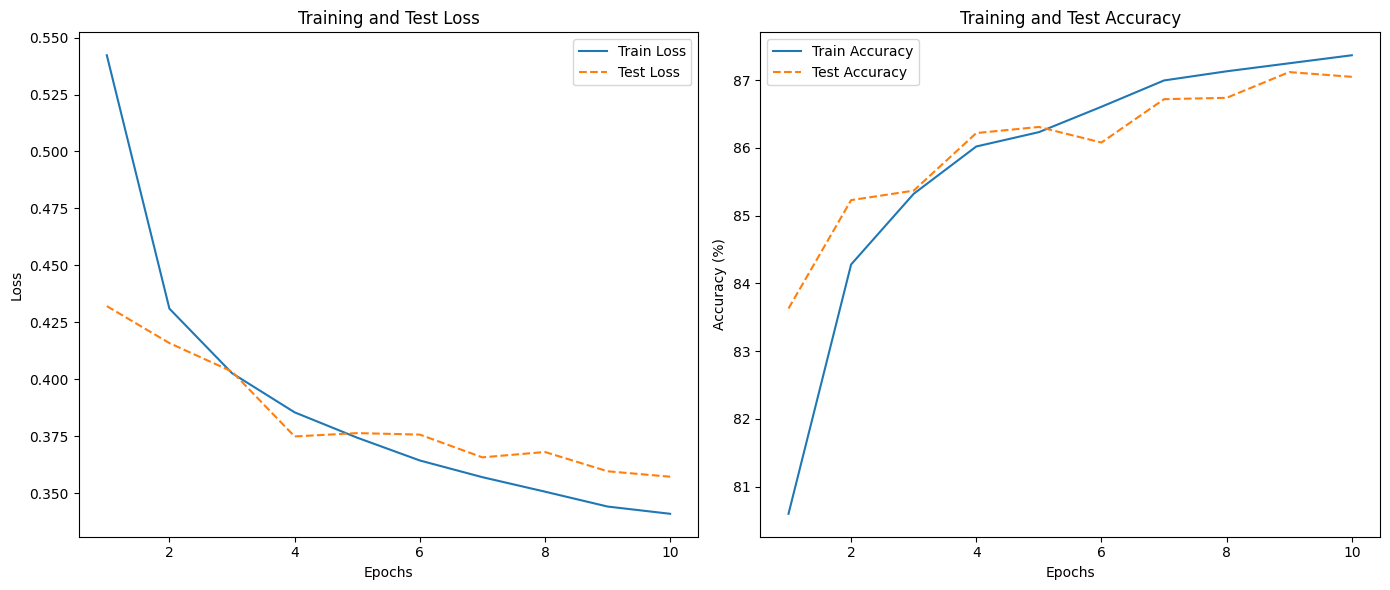

[I 2024-11-09 01:05:06,782] Trial 8 finished with value: 87.05 and parameters: {'optimizer': 'Nadam'}. Best is trial 6 with value: 87.32.


Epoch [1/10], Train Loss: 0.5466, Train Accuracy: 80.36%, Test Loss: 0.4416, Test Accuracy: 83.26%
Epoch [2/10], Train Loss: 0.4326, Train Accuracy: 84.26%, Test Loss: 0.4102, Test Accuracy: 84.99%
Epoch [3/10], Train Loss: 0.4029, Train Accuracy: 85.25%, Test Loss: 0.3927, Test Accuracy: 86.02%
Epoch [4/10], Train Loss: 0.3844, Train Accuracy: 86.03%, Test Loss: 0.3941, Test Accuracy: 85.45%
Epoch [5/10], Train Loss: 0.3752, Train Accuracy: 86.38%, Test Loss: 0.3824, Test Accuracy: 86.41%
Epoch [6/10], Train Loss: 0.3643, Train Accuracy: 86.68%, Test Loss: 0.3733, Test Accuracy: 86.26%
Epoch [7/10], Train Loss: 0.3562, Train Accuracy: 86.88%, Test Loss: 0.3673, Test Accuracy: 86.53%
Epoch [8/10], Train Loss: 0.3489, Train Accuracy: 87.01%, Test Loss: 0.3606, Test Accuracy: 87.05%
Epoch [9/10], Train Loss: 0.3439, Train Accuracy: 87.36%, Test Loss: 0.3546, Test Accuracy: 87.13%
Epoch [10/10], Train Loss: 0.3395, Train Accuracy: 87.47%, Test Loss: 0.3592, Test Accuracy: 87.08%


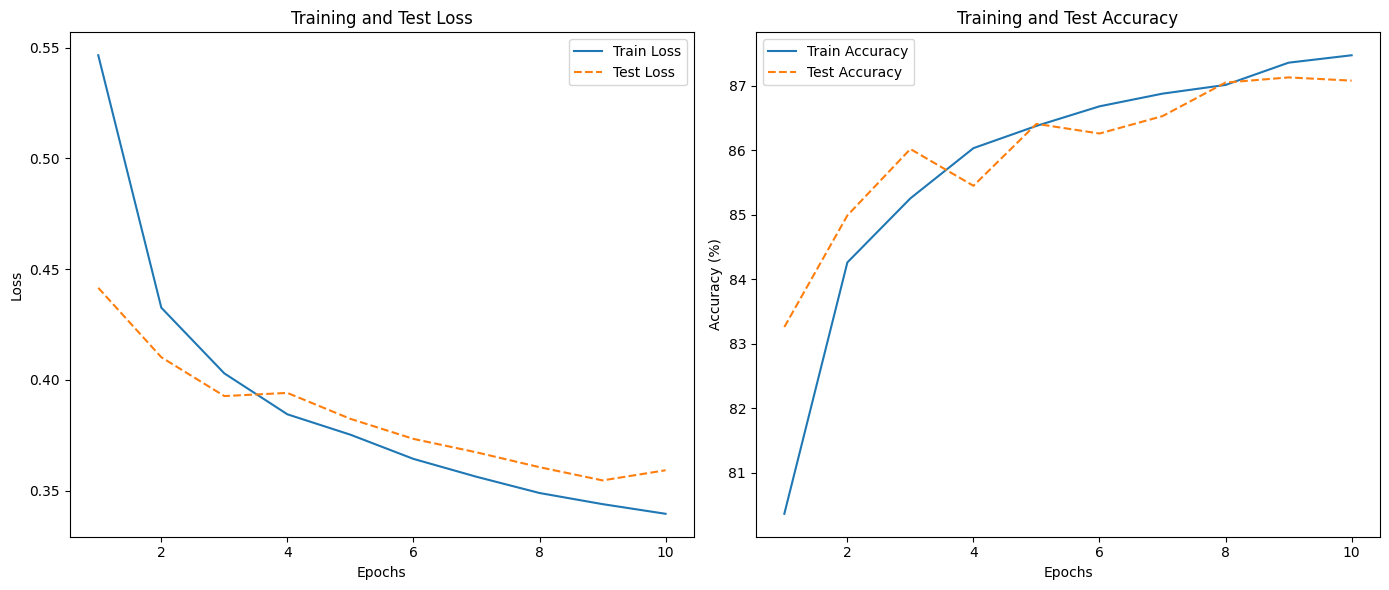

[I 2024-11-09 01:08:13,441] Trial 9 finished with value: 87.08 and parameters: {'optimizer': 'Nadam'}. Best is trial 6 with value: 87.32.


Best optimizer: Nadam
Best accuracy: 87.32


In [9]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

best_trial = study.best_trial
print(f"Best optimizer: {best_trial.params['optimizer']}")
print(f"Best accuracy: {best_trial.value}")


# Q1.4

In [6]:
learning_rates = [0.001, 0.005, 0.01]
batch_sizes = [16, 32, 64]
hidden_layers = [[64], [64,128], [128]]

In [7]:
class ParametrizedFashionMNISTNet(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes):
        super(ParametrizedFashionMNISTNet, self).__init__()
        layers = []
        previous_size = input_size
        for hidden_size in hidden_layer_sizes:
            layers.append(nn.Linear(previous_size, hidden_size))
            layers.append(nn.ReLU())
            previous_size = hidden_size
        layers.append(nn.Linear(previous_size, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [8]:
def grid_search(train_dataset, test_dataset, learning_rates, batch_sizes, hidden_layers, num_epochs=20, device=device):
    best_accuracy = 0
    best_params = {}
    results = []
    
    for lr in learning_rates:
        for batch_size in batch_sizes:
            for hidden_layer_config in hidden_layers:
                print(f"\nTraining with lr={lr}, batch_size={batch_size}, hidden_layers={hidden_layer_config}")

                model = ParametrizedFashionMNISTNet(input_size=28*28, hidden_layer_sizes=hidden_layer_config).to(device)
                
                trainer = ClassificationModelTrainer(model, train_dataset, test_dataset, device, 
                                                     learning_rate=lr, num_epochs=num_epochs)
                
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
                
                trainer.train_with_optimizer(optimizer)
                
                _, test_accuracy, _ = trainer.evaluate()
                
                print(f"Test Accuracy: {test_accuracy:.2f}%")
                
                trainer.plot_confusion_matrix()

                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    best_params = {
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'hidden_layers': hidden_layer_config
                    }
                
                results.append({
                    'learning_rate': lr,
                    'batch_size': batch_size,
                    'hidden_layers': hidden_layer_config,
                    'accuracy': test_accuracy
                })

    print("\nBest Hyperparameters:")
    print(best_params)
    print(f"Best Accuracy: {best_accuracy:.2f}%")
    
    return results, best_params


Training with lr=0.001, batch_size=16, hidden_layers=[64]
Epoch [1/5], Train Loss: 0.5046, Train Accuracy: 81.83%, Test Loss: 0.4474, Test Accuracy: 83.95%
Epoch [2/5], Train Loss: 0.3907, Train Accuracy: 85.92%, Test Loss: 0.3983, Test Accuracy: 85.30%
Epoch [3/5], Train Loss: 0.3592, Train Accuracy: 86.84%, Test Loss: 0.3994, Test Accuracy: 85.38%
Epoch [4/5], Train Loss: 0.3381, Train Accuracy: 87.59%, Test Loss: 0.3846, Test Accuracy: 86.03%
Epoch [5/5], Train Loss: 0.3215, Train Accuracy: 88.23%, Test Loss: 0.3933, Test Accuracy: 85.09%


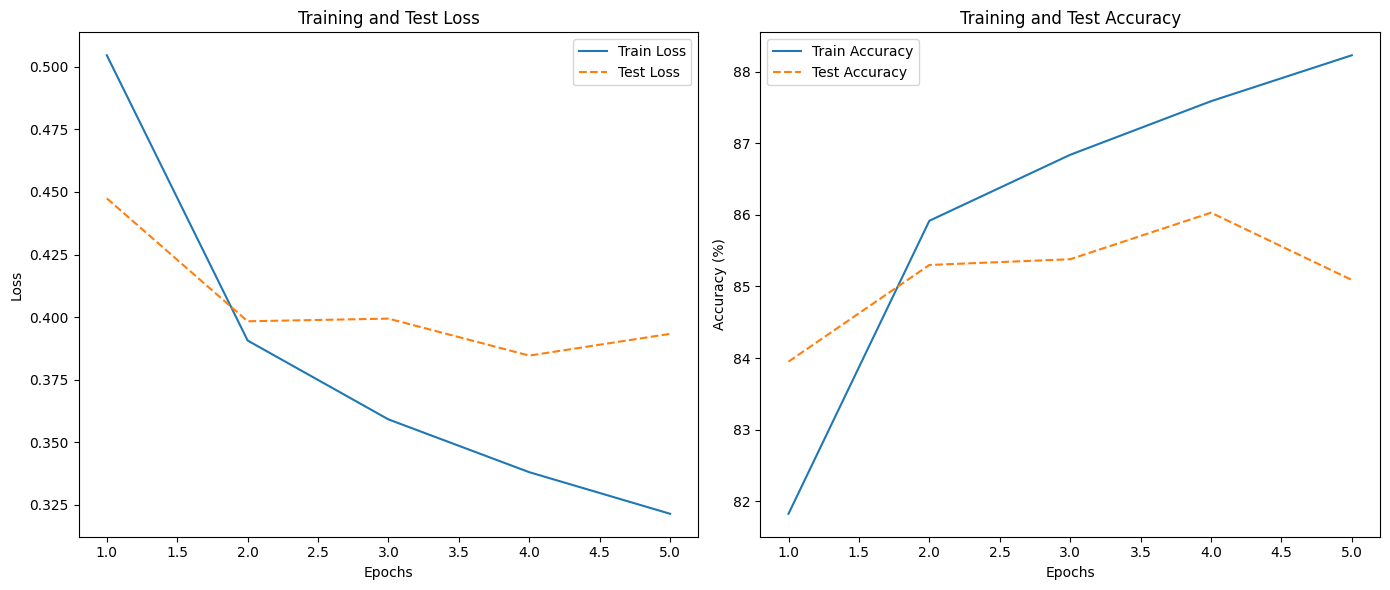

Test Accuracy: 85.09%


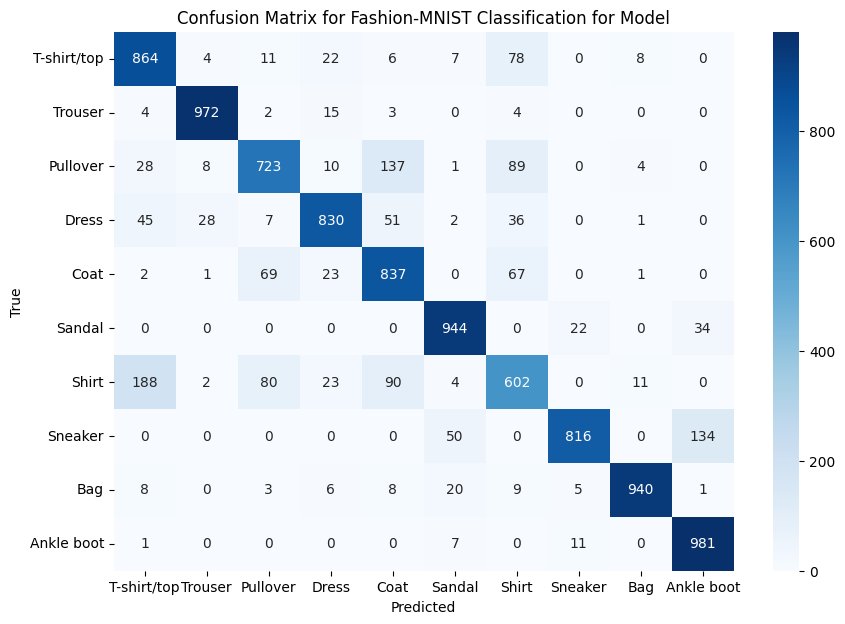

Two classes most confused with each other: Shirt and T-shirt/top

Training with lr=0.001, batch_size=16, hidden_layers=[64, 128]
Epoch [1/5], Train Loss: 0.5056, Train Accuracy: 81.64%, Test Loss: 0.4324, Test Accuracy: 84.08%
Epoch [2/5], Train Loss: 0.3831, Train Accuracy: 85.88%, Test Loss: 0.3912, Test Accuracy: 85.73%
Epoch [3/5], Train Loss: 0.3504, Train Accuracy: 87.13%, Test Loss: 0.3737, Test Accuracy: 86.52%
Epoch [4/5], Train Loss: 0.3249, Train Accuracy: 88.01%, Test Loss: 0.3649, Test Accuracy: 86.79%
Epoch [5/5], Train Loss: 0.3072, Train Accuracy: 88.59%, Test Loss: 0.3694, Test Accuracy: 87.15%


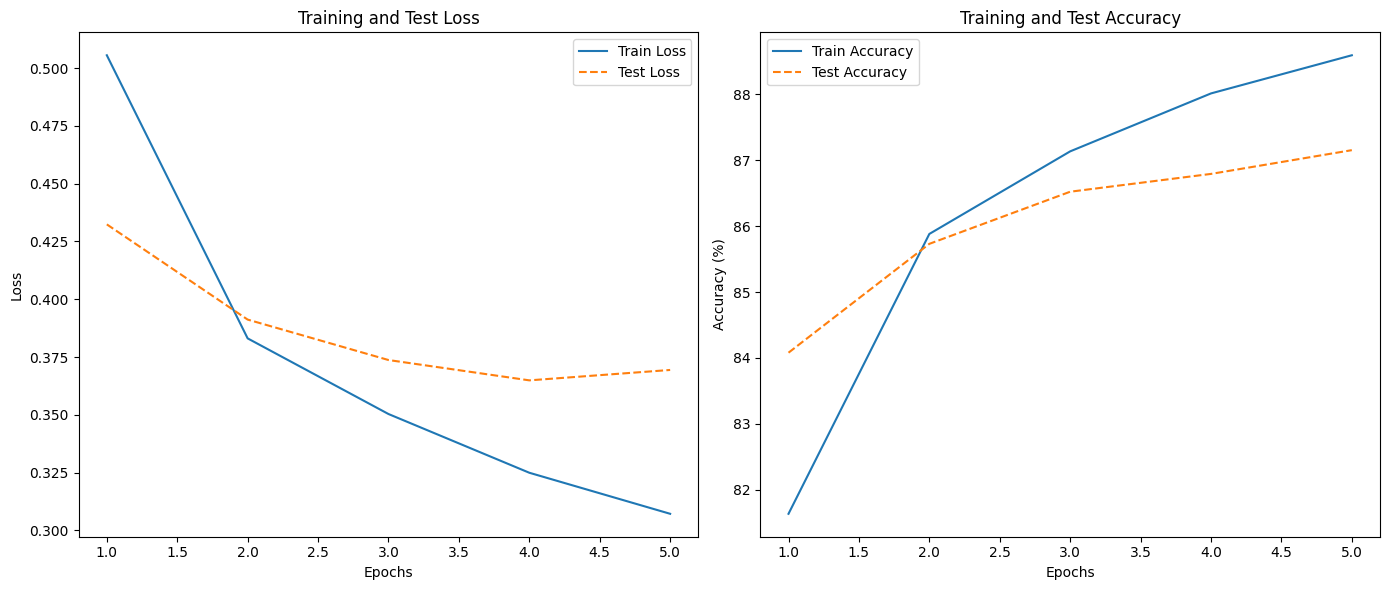

Test Accuracy: 87.15%


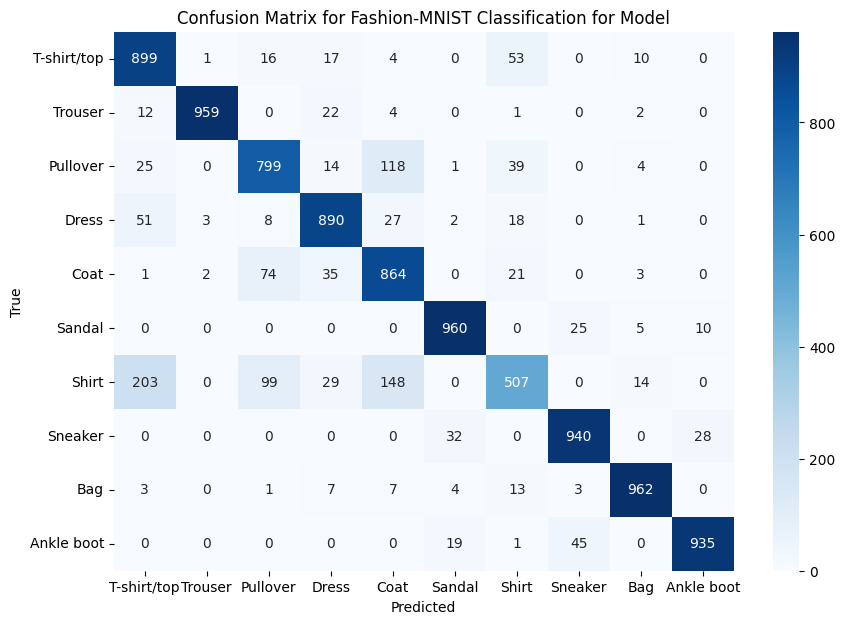

Two classes most confused with each other: Shirt and T-shirt/top

Training with lr=0.001, batch_size=16, hidden_layers=[128]
Epoch [1/5], Train Loss: 0.4893, Train Accuracy: 82.41%, Test Loss: 0.4307, Test Accuracy: 83.62%
Epoch [2/5], Train Loss: 0.3754, Train Accuracy: 86.36%, Test Loss: 0.4101, Test Accuracy: 85.20%
Epoch [3/5], Train Loss: 0.3422, Train Accuracy: 87.36%, Test Loss: 0.3932, Test Accuracy: 86.08%
Epoch [4/5], Train Loss: 0.3222, Train Accuracy: 88.04%, Test Loss: 0.3768, Test Accuracy: 86.27%
Epoch [5/5], Train Loss: 0.3058, Train Accuracy: 88.63%, Test Loss: 0.3648, Test Accuracy: 86.96%


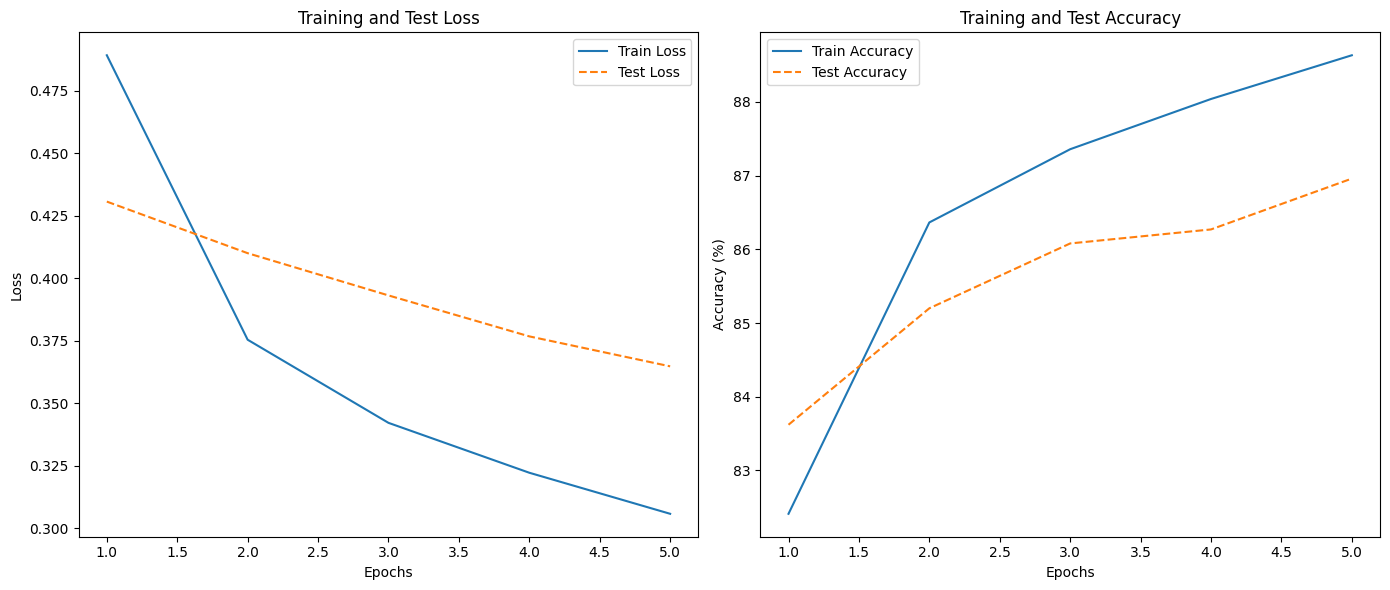

Test Accuracy: 86.96%


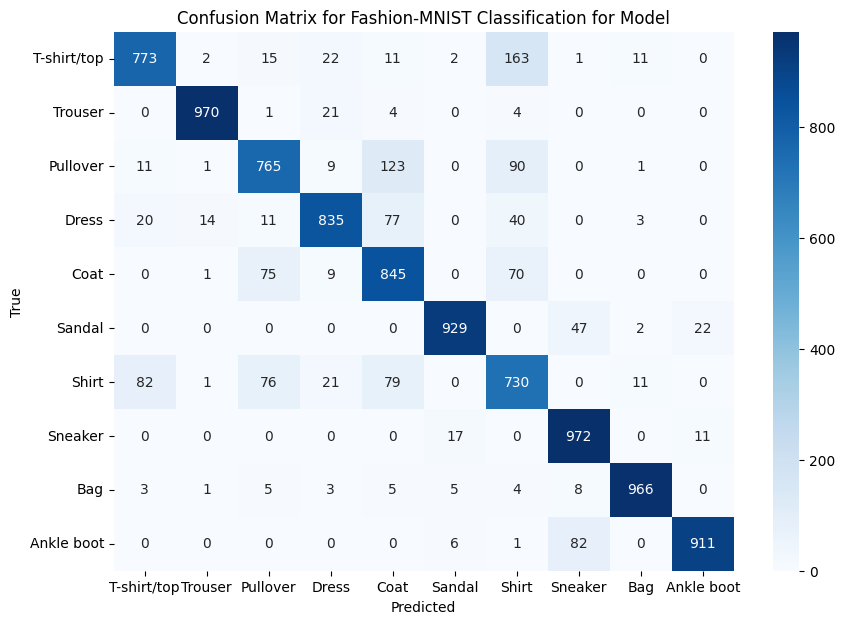

Two classes most confused with each other: T-shirt/top and Shirt

Training with lr=0.001, batch_size=32, hidden_layers=[64]
Epoch [1/5], Train Loss: 0.5059, Train Accuracy: 81.77%, Test Loss: 0.4465, Test Accuracy: 83.78%
Epoch [2/5], Train Loss: 0.3936, Train Accuracy: 85.66%, Test Loss: 0.4074, Test Accuracy: 85.28%
Epoch [3/5], Train Loss: 0.3580, Train Accuracy: 86.83%, Test Loss: 0.3919, Test Accuracy: 85.61%
Epoch [4/5], Train Loss: 0.3334, Train Accuracy: 87.69%, Test Loss: 0.3799, Test Accuracy: 86.29%
Epoch [5/5], Train Loss: 0.3183, Train Accuracy: 88.32%, Test Loss: 0.3658, Test Accuracy: 87.04%


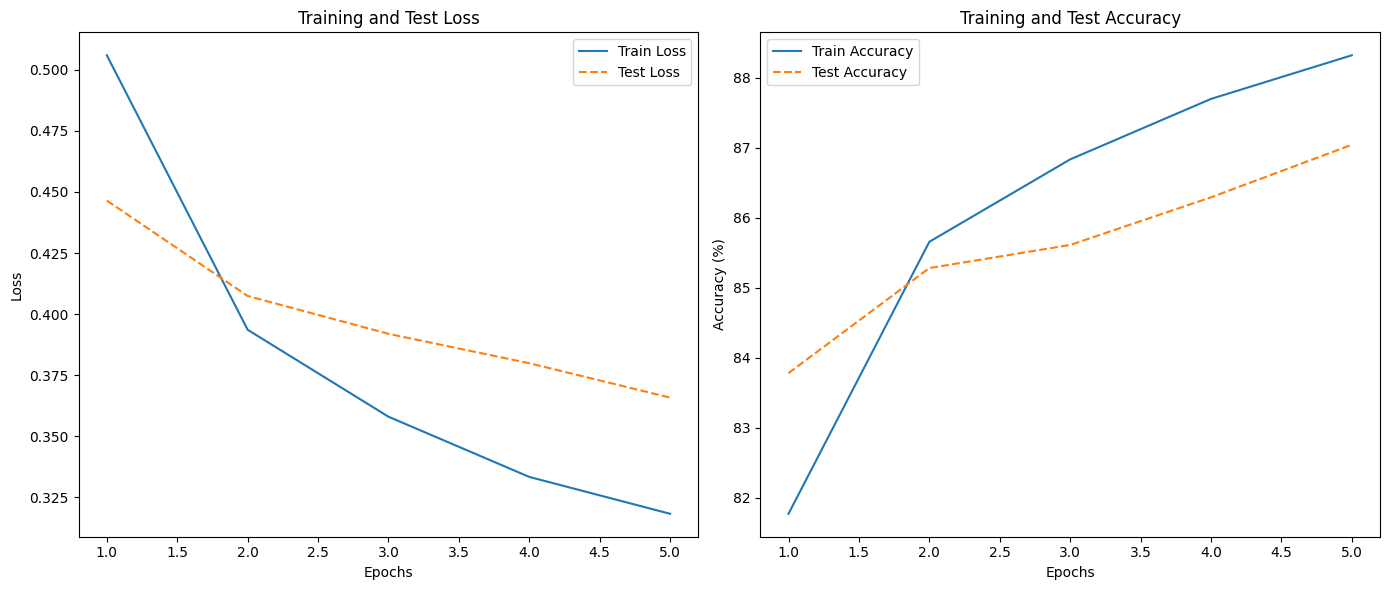

Test Accuracy: 87.04%


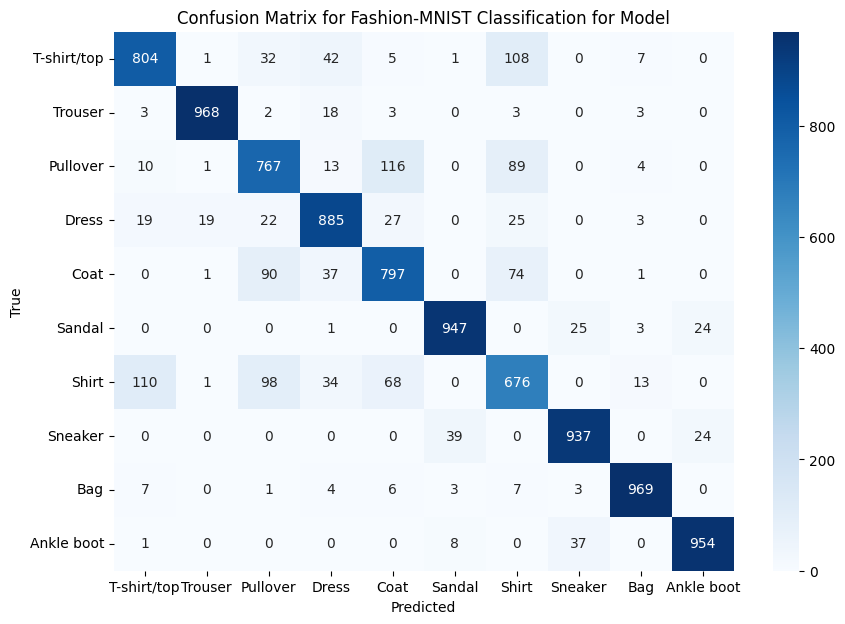

Two classes most confused with each other: Pullover and Coat

Training with lr=0.001, batch_size=32, hidden_layers=[64, 128]
Epoch [1/5], Train Loss: 0.5014, Train Accuracy: 81.76%, Test Loss: 0.4333, Test Accuracy: 84.24%
Epoch [2/5], Train Loss: 0.3789, Train Accuracy: 86.07%, Test Loss: 0.3955, Test Accuracy: 85.74%
Epoch [3/5], Train Loss: 0.3455, Train Accuracy: 87.27%, Test Loss: 0.3807, Test Accuracy: 86.01%
Epoch [4/5], Train Loss: 0.3223, Train Accuracy: 88.02%, Test Loss: 0.3955, Test Accuracy: 85.80%
Epoch [5/5], Train Loss: 0.3085, Train Accuracy: 88.49%, Test Loss: 0.3818, Test Accuracy: 86.11%


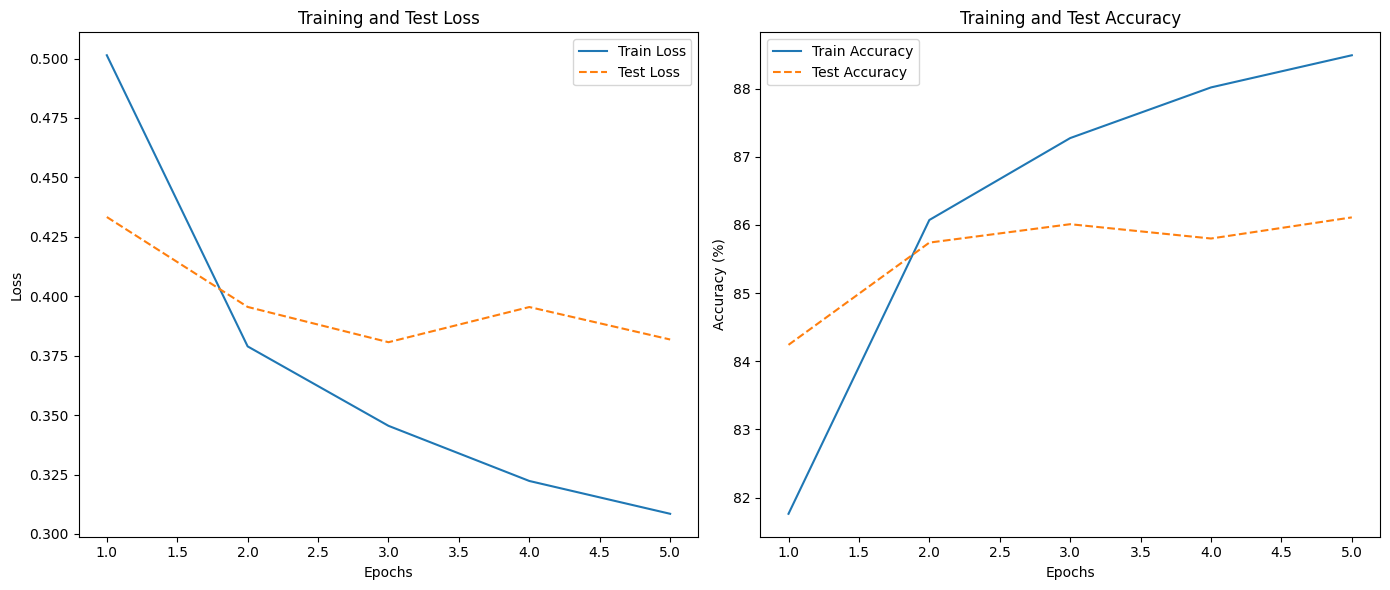

Test Accuracy: 86.11%


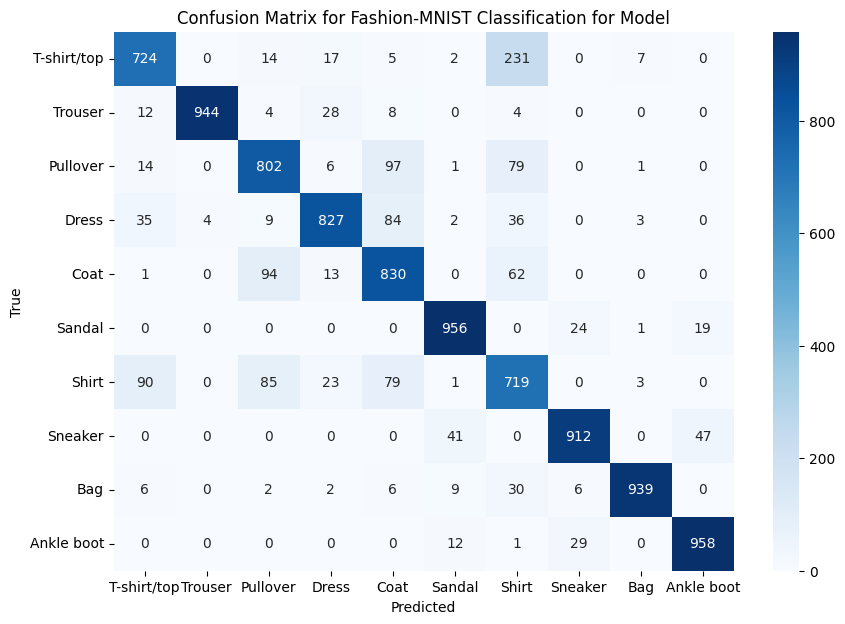

Two classes most confused with each other: T-shirt/top and Shirt

Training with lr=0.001, batch_size=32, hidden_layers=[128]
Epoch [1/5], Train Loss: 0.4825, Train Accuracy: 82.54%, Test Loss: 0.4308, Test Accuracy: 84.35%
Epoch [2/5], Train Loss: 0.3755, Train Accuracy: 86.27%, Test Loss: 0.3938, Test Accuracy: 85.86%
Epoch [3/5], Train Loss: 0.3427, Train Accuracy: 87.53%, Test Loss: 0.3715, Test Accuracy: 86.65%
Epoch [4/5], Train Loss: 0.3213, Train Accuracy: 88.15%, Test Loss: 0.3803, Test Accuracy: 85.87%
Epoch [5/5], Train Loss: 0.3050, Train Accuracy: 88.72%, Test Loss: 0.3761, Test Accuracy: 86.25%


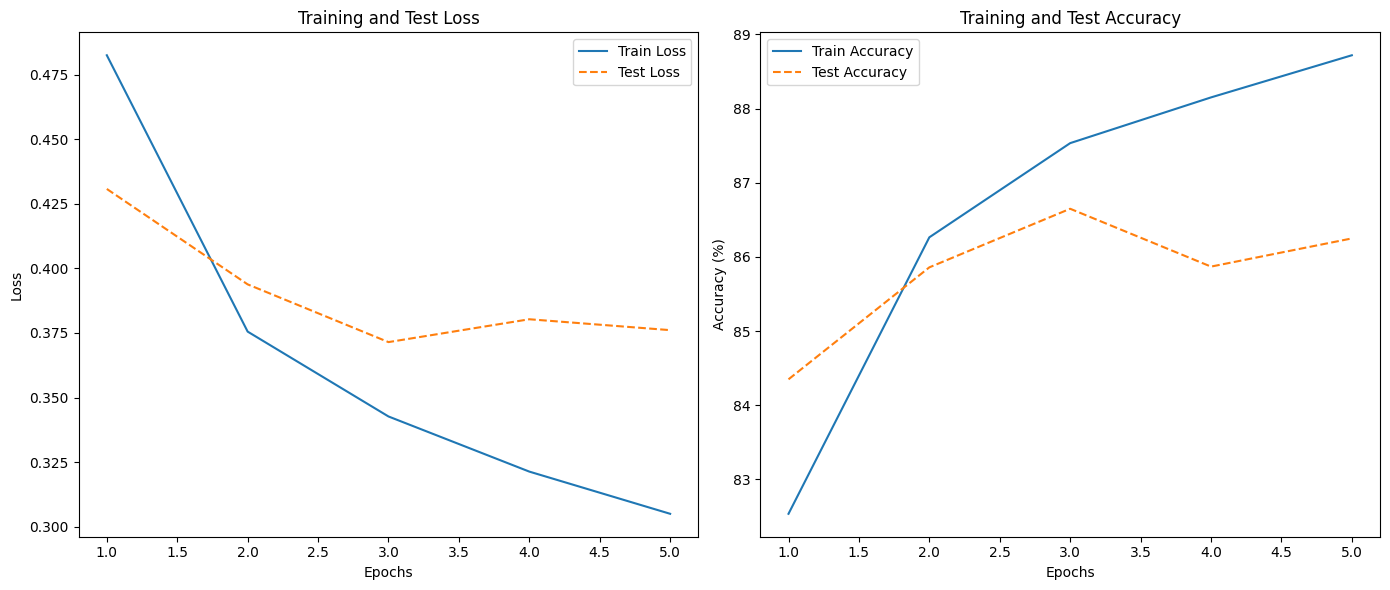

Test Accuracy: 86.25%


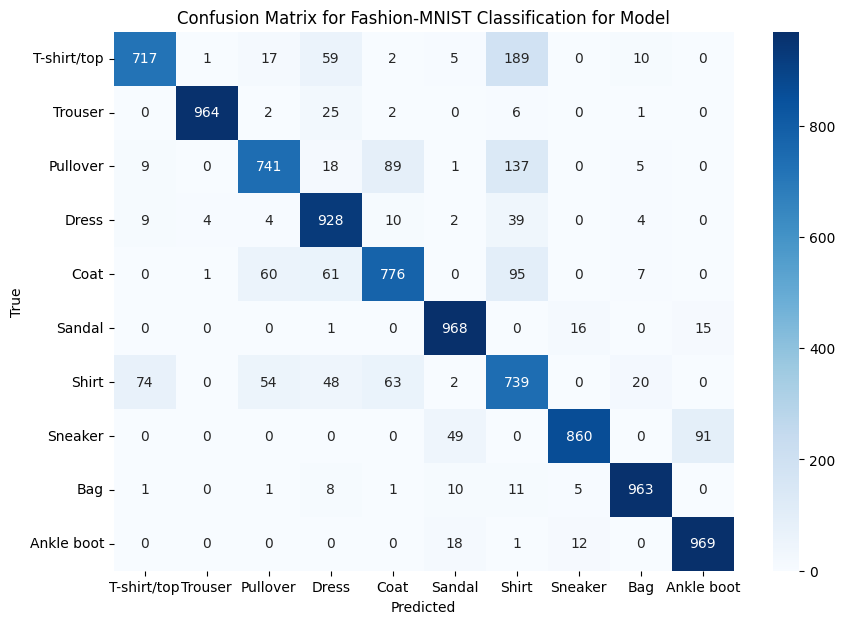

Two classes most confused with each other: T-shirt/top and Shirt

Training with lr=0.001, batch_size=64, hidden_layers=[64]
Epoch [1/5], Train Loss: 0.5052, Train Accuracy: 81.86%, Test Loss: 0.4847, Test Accuracy: 81.62%
Epoch [2/5], Train Loss: 0.3883, Train Accuracy: 85.97%, Test Loss: 0.3929, Test Accuracy: 85.98%
Epoch [3/5], Train Loss: 0.3530, Train Accuracy: 87.06%, Test Loss: 0.3756, Test Accuracy: 86.39%
Epoch [4/5], Train Loss: 0.3333, Train Accuracy: 87.73%, Test Loss: 0.3722, Test Accuracy: 86.77%
Epoch [5/5], Train Loss: 0.3173, Train Accuracy: 88.33%, Test Loss: 0.3764, Test Accuracy: 86.79%


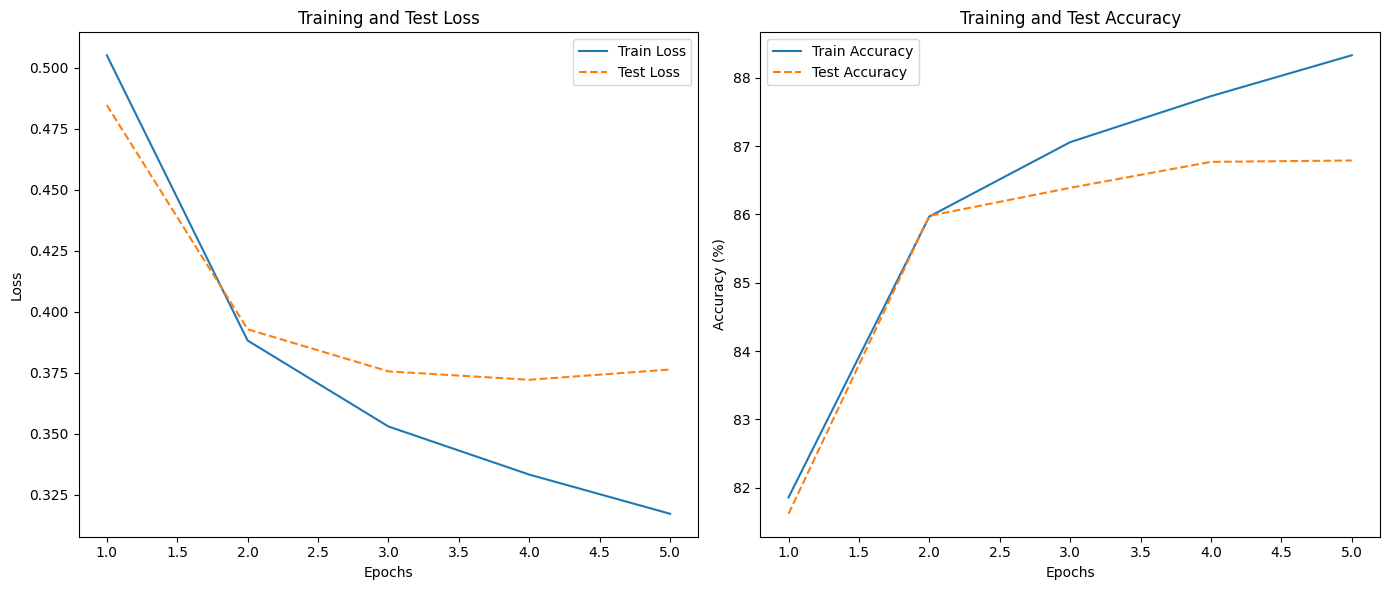

Test Accuracy: 86.79%


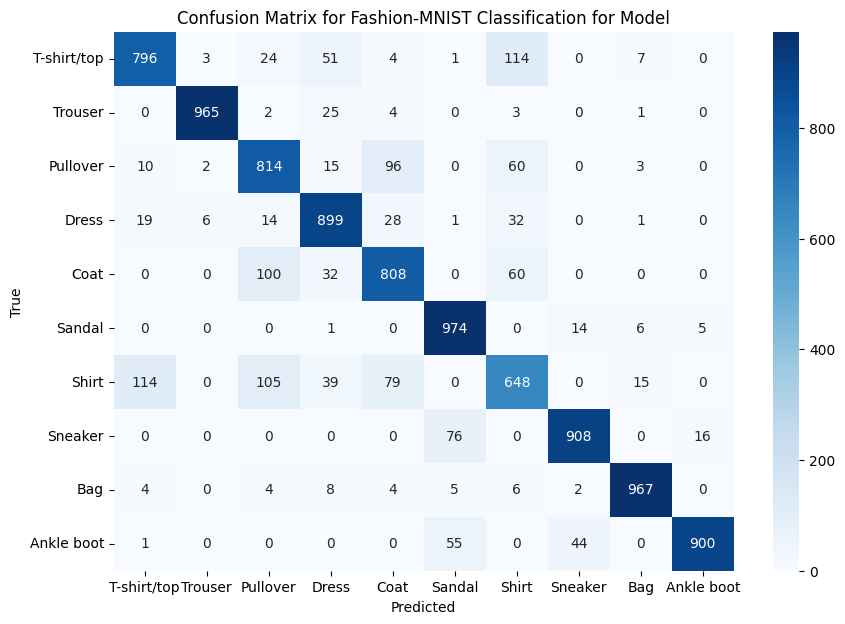

Two classes most confused with each other: T-shirt/top and Shirt

Training with lr=0.001, batch_size=64, hidden_layers=[64, 128]
Epoch [1/5], Train Loss: 0.4966, Train Accuracy: 81.89%, Test Loss: 0.4353, Test Accuracy: 84.06%
Epoch [2/5], Train Loss: 0.3806, Train Accuracy: 86.08%, Test Loss: 0.3992, Test Accuracy: 85.66%
Epoch [3/5], Train Loss: 0.3435, Train Accuracy: 87.22%, Test Loss: 0.3921, Test Accuracy: 85.61%
Epoch [4/5], Train Loss: 0.3223, Train Accuracy: 88.02%, Test Loss: 0.3693, Test Accuracy: 86.91%
Epoch [5/5], Train Loss: 0.3069, Train Accuracy: 88.51%, Test Loss: 0.3890, Test Accuracy: 85.80%


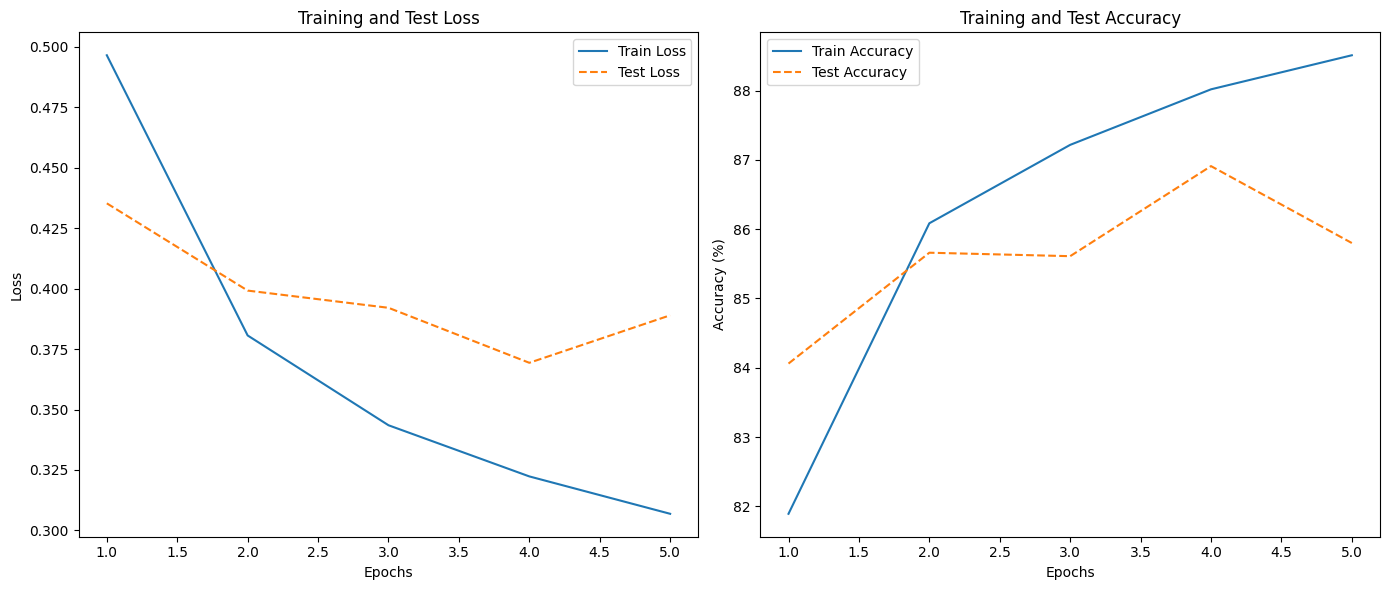

Test Accuracy: 85.80%


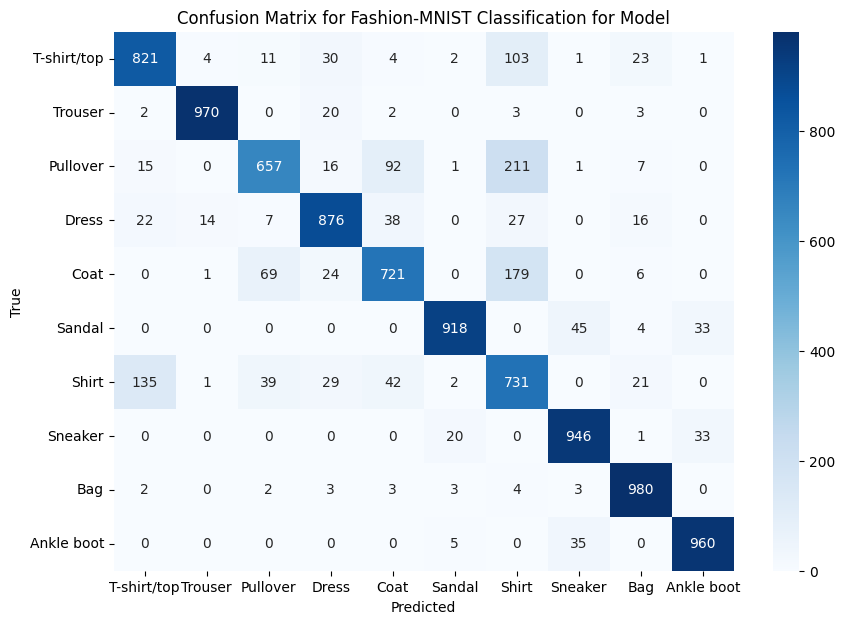

Two classes most confused with each other: Pullover and Shirt

Training with lr=0.001, batch_size=64, hidden_layers=[128]
Epoch [1/5], Train Loss: 0.4880, Train Accuracy: 82.40%, Test Loss: 0.4409, Test Accuracy: 84.05%
Epoch [2/5], Train Loss: 0.3801, Train Accuracy: 86.11%, Test Loss: 0.3940, Test Accuracy: 85.49%
Epoch [3/5], Train Loss: 0.3470, Train Accuracy: 87.21%, Test Loss: 0.3746, Test Accuracy: 85.94%
Epoch [4/5], Train Loss: 0.3259, Train Accuracy: 87.96%, Test Loss: 0.4092, Test Accuracy: 85.30%
Epoch [5/5], Train Loss: 0.3071, Train Accuracy: 88.59%, Test Loss: 0.3669, Test Accuracy: 86.44%


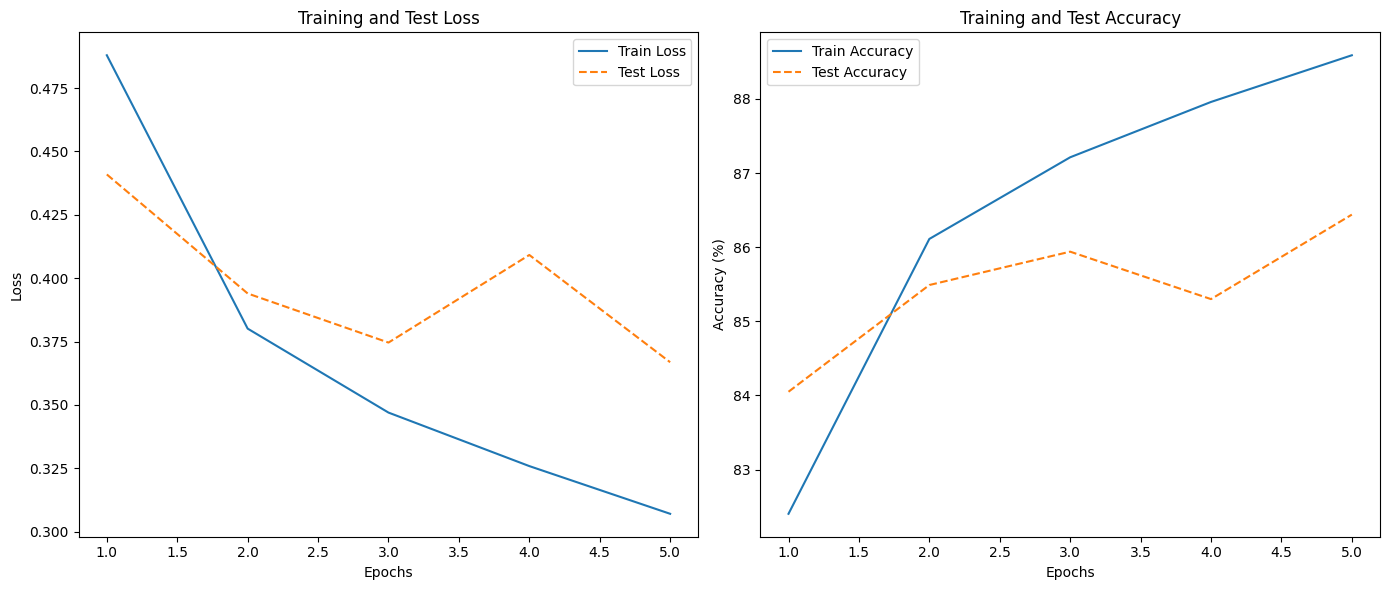

Test Accuracy: 86.44%


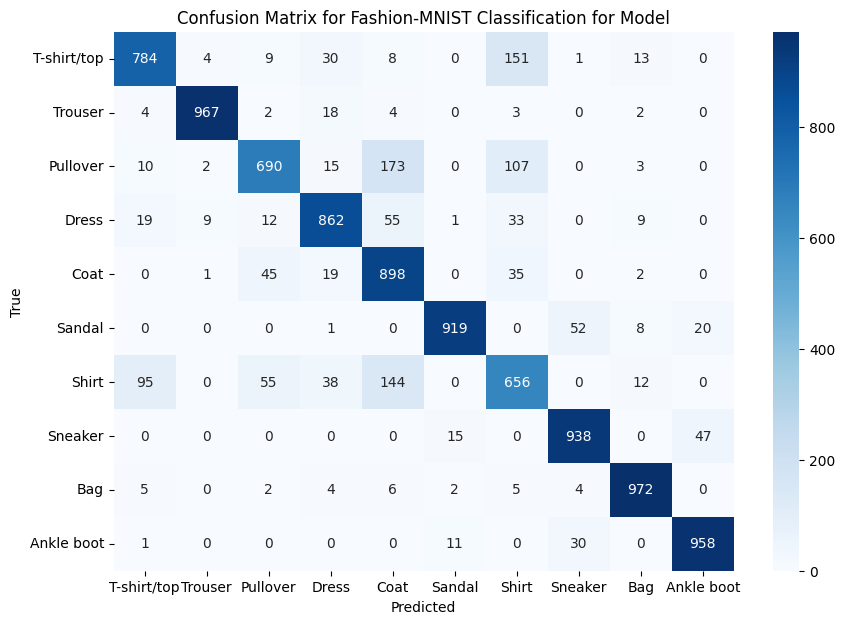

Two classes most confused with each other: Pullover and Coat

Training with lr=0.005, batch_size=16, hidden_layers=[64]
Epoch [1/5], Train Loss: 0.5146, Train Accuracy: 81.35%, Test Loss: 0.5296, Test Accuracy: 80.21%
Epoch [2/5], Train Loss: 0.4373, Train Accuracy: 84.30%, Test Loss: 0.4401, Test Accuracy: 83.81%
Epoch [3/5], Train Loss: 0.4218, Train Accuracy: 84.67%, Test Loss: 0.4636, Test Accuracy: 84.30%
Epoch [4/5], Train Loss: 0.4075, Train Accuracy: 85.21%, Test Loss: 0.4460, Test Accuracy: 84.48%
Epoch [5/5], Train Loss: 0.3981, Train Accuracy: 85.50%, Test Loss: 0.4322, Test Accuracy: 84.54%


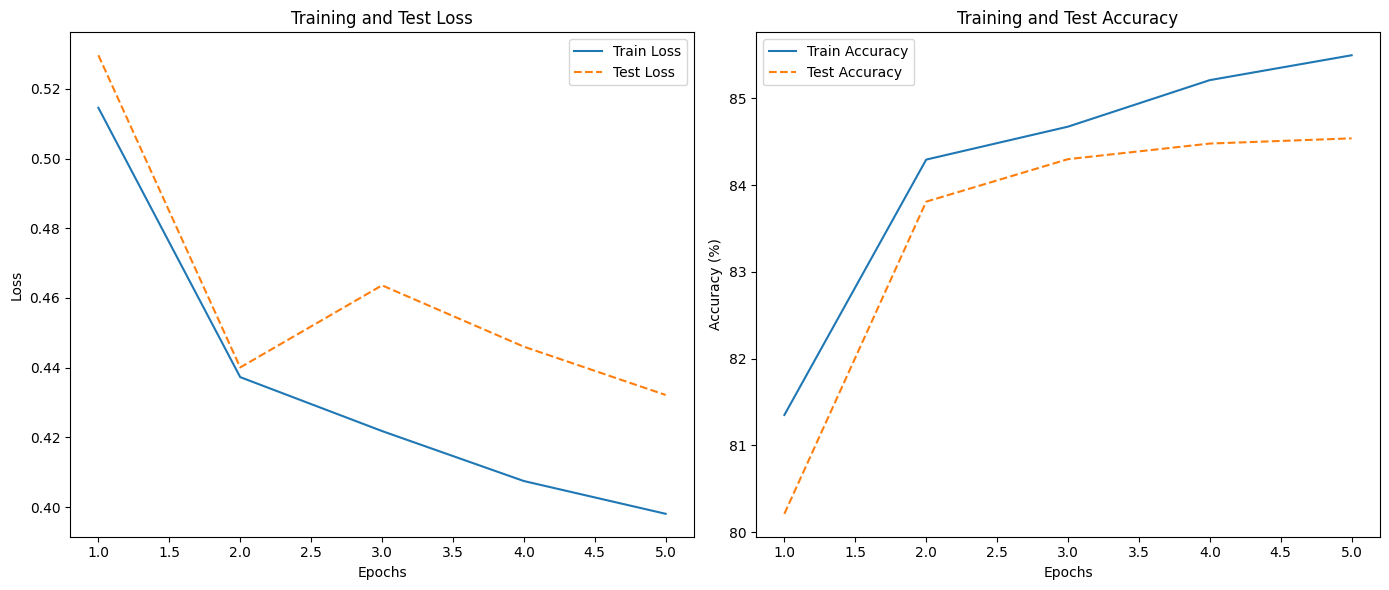

Test Accuracy: 84.54%


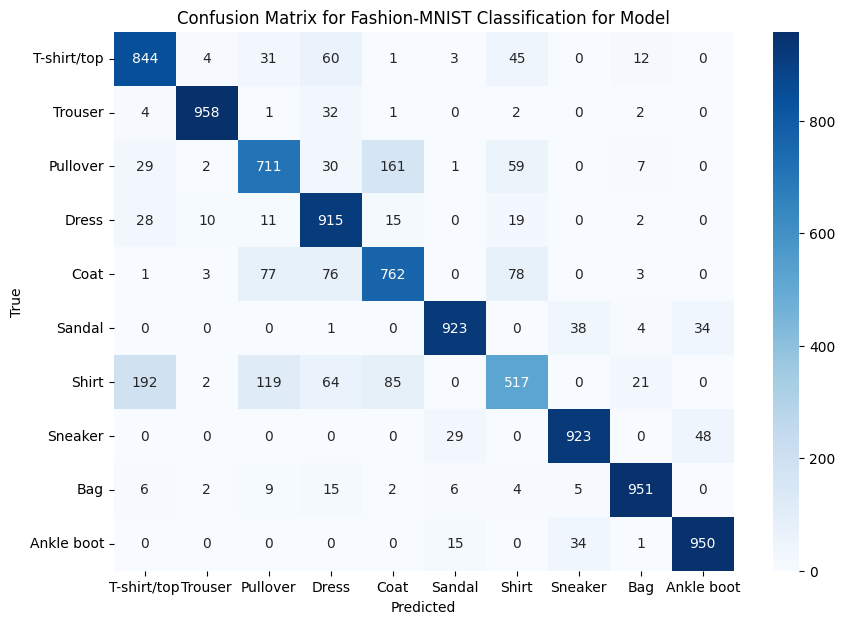

Two classes most confused with each other: Shirt and T-shirt/top

Training with lr=0.005, batch_size=16, hidden_layers=[64, 128]
Epoch [1/5], Train Loss: 0.5319, Train Accuracy: 80.71%, Test Loss: 0.5031, Test Accuracy: 82.41%
Epoch [2/5], Train Loss: 0.4398, Train Accuracy: 84.09%, Test Loss: 0.4809, Test Accuracy: 83.44%
Epoch [3/5], Train Loss: 0.4142, Train Accuracy: 84.94%, Test Loss: 0.4444, Test Accuracy: 83.88%
Epoch [4/5], Train Loss: 0.4007, Train Accuracy: 85.46%, Test Loss: 0.4535, Test Accuracy: 84.28%
Epoch [5/5], Train Loss: 0.3949, Train Accuracy: 85.84%, Test Loss: 0.4779, Test Accuracy: 83.16%


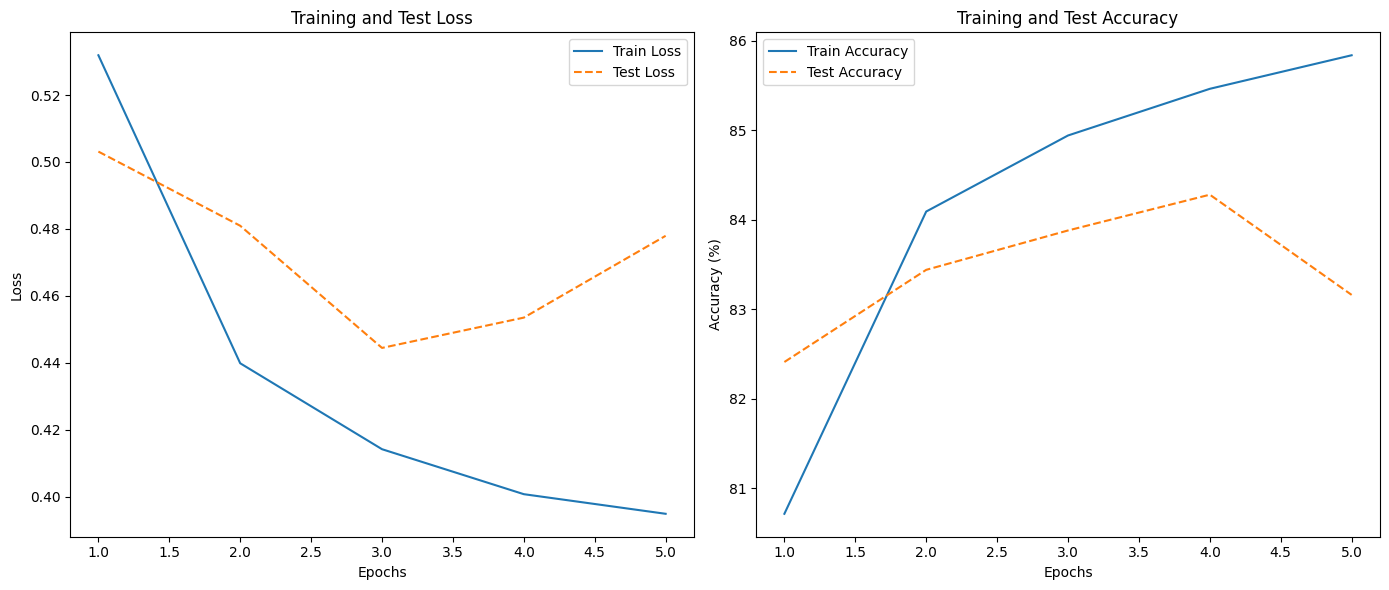

Test Accuracy: 83.16%


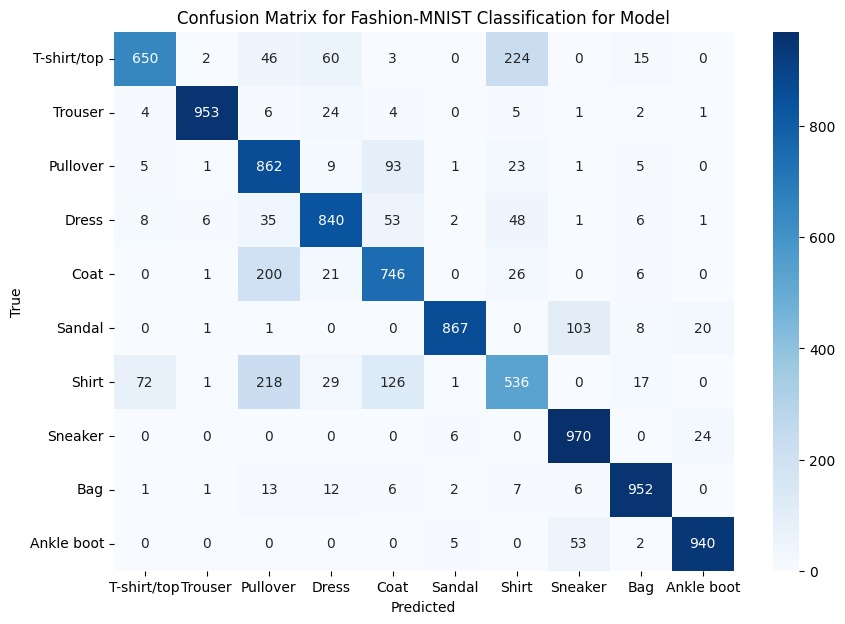

Two classes most confused with each other: T-shirt/top and Shirt

Training with lr=0.005, batch_size=16, hidden_layers=[128]
Epoch [1/5], Train Loss: 0.5234, Train Accuracy: 81.17%, Test Loss: 0.4622, Test Accuracy: 83.64%
Epoch [2/5], Train Loss: 0.4339, Train Accuracy: 84.32%, Test Loss: 0.4634, Test Accuracy: 83.77%
Epoch [3/5], Train Loss: 0.4189, Train Accuracy: 84.96%, Test Loss: 0.4509, Test Accuracy: 83.54%
Epoch [4/5], Train Loss: 0.4071, Train Accuracy: 85.44%, Test Loss: 0.4127, Test Accuracy: 85.25%
Epoch [5/5], Train Loss: 0.4011, Train Accuracy: 85.68%, Test Loss: 0.4686, Test Accuracy: 83.15%


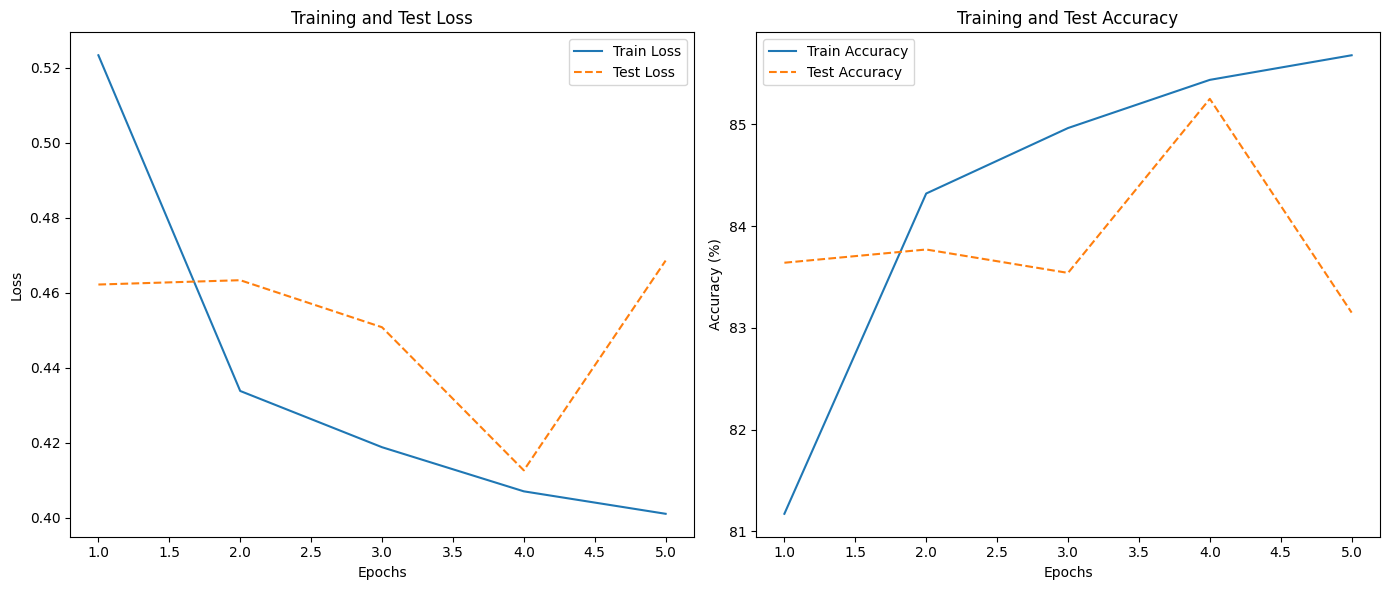

Test Accuracy: 83.15%


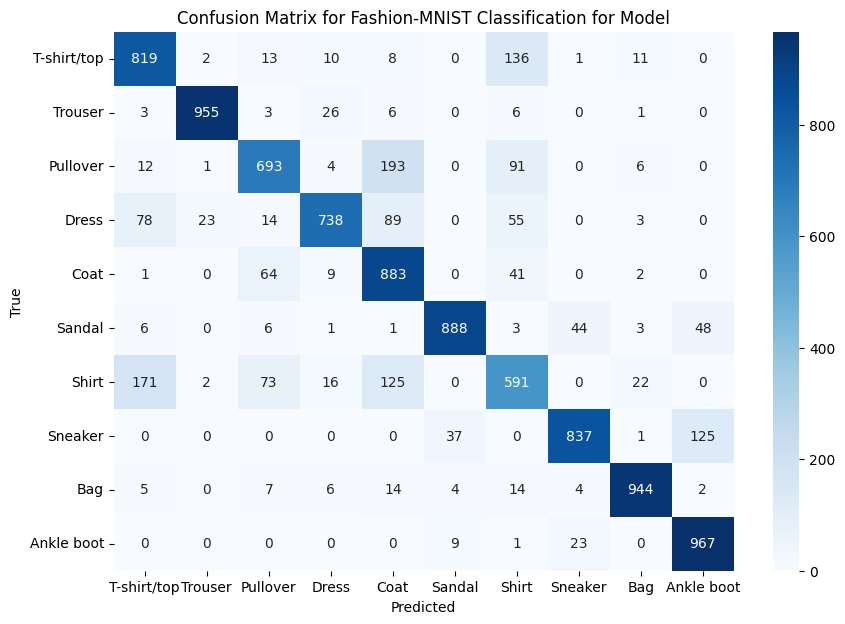

Two classes most confused with each other: Pullover and Coat

Training with lr=0.005, batch_size=32, hidden_layers=[64]
Epoch [1/5], Train Loss: 0.5144, Train Accuracy: 81.55%, Test Loss: 0.4764, Test Accuracy: 82.71%
Epoch [2/5], Train Loss: 0.4341, Train Accuracy: 84.32%, Test Loss: 0.4786, Test Accuracy: 82.97%
Epoch [3/5], Train Loss: 0.4178, Train Accuracy: 84.84%, Test Loss: 0.4303, Test Accuracy: 84.81%
Epoch [4/5], Train Loss: 0.4054, Train Accuracy: 85.50%, Test Loss: 0.4491, Test Accuracy: 83.89%
Epoch [5/5], Train Loss: 0.4004, Train Accuracy: 85.66%, Test Loss: 0.4577, Test Accuracy: 83.83%


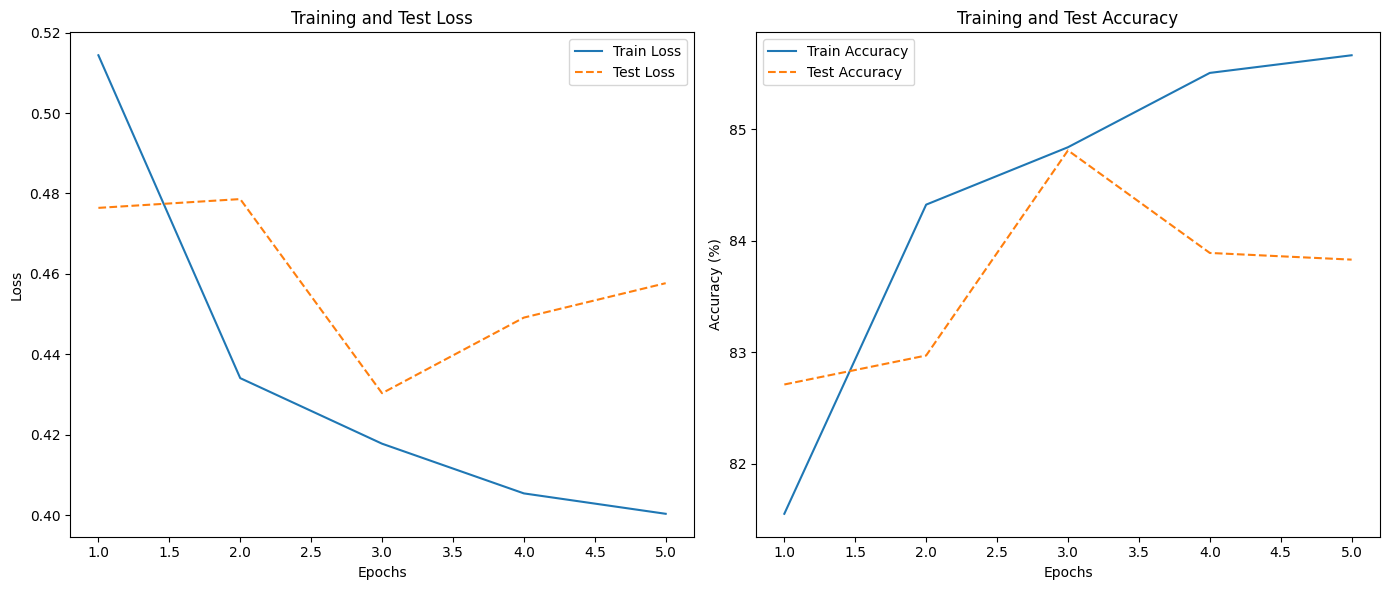

Test Accuracy: 83.83%


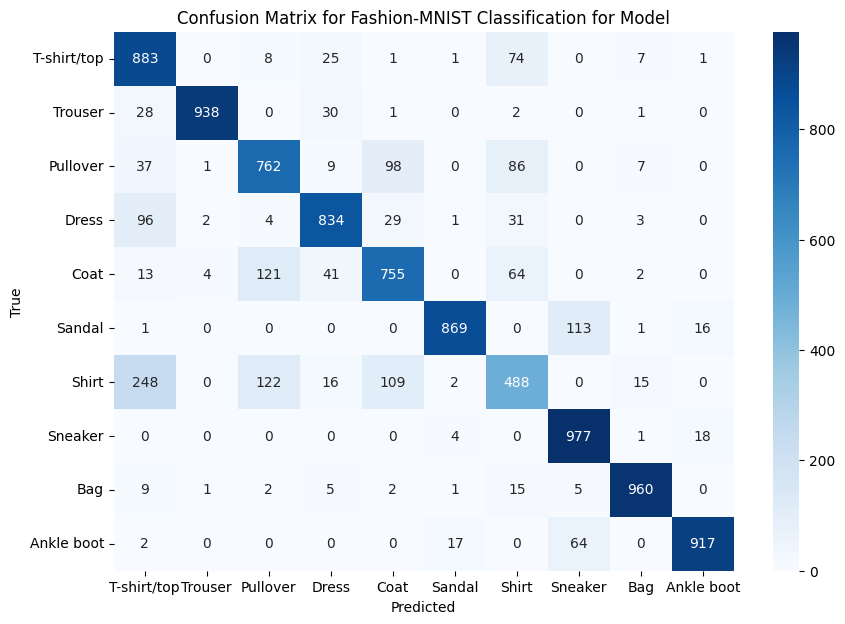

Two classes most confused with each other: Shirt and T-shirt/top

Training with lr=0.005, batch_size=32, hidden_layers=[64, 128]
Epoch [1/5], Train Loss: 0.5351, Train Accuracy: 80.65%, Test Loss: 0.4725, Test Accuracy: 83.59%
Epoch [2/5], Train Loss: 0.4425, Train Accuracy: 84.06%, Test Loss: 0.4741, Test Accuracy: 82.50%
Epoch [3/5], Train Loss: 0.4183, Train Accuracy: 84.83%, Test Loss: 0.4487, Test Accuracy: 84.30%
Epoch [4/5], Train Loss: 0.4110, Train Accuracy: 85.27%, Test Loss: 0.4378, Test Accuracy: 84.41%
Epoch [5/5], Train Loss: 0.3970, Train Accuracy: 85.58%, Test Loss: 0.4333, Test Accuracy: 84.23%


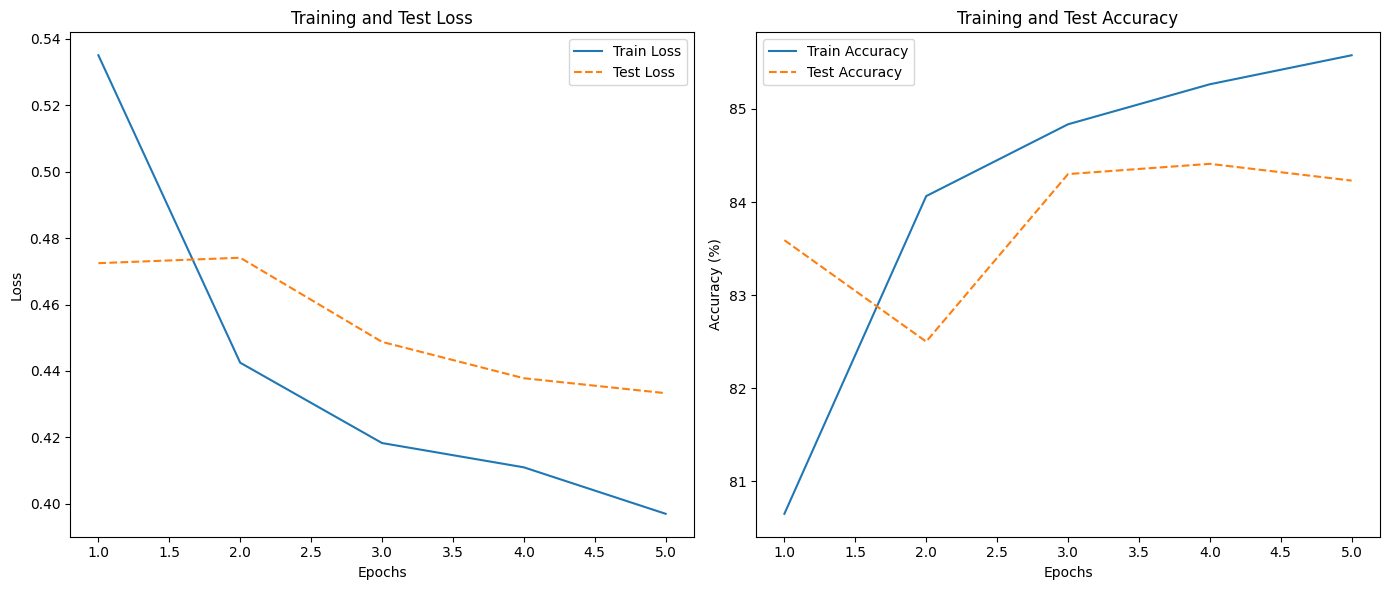

Test Accuracy: 84.23%


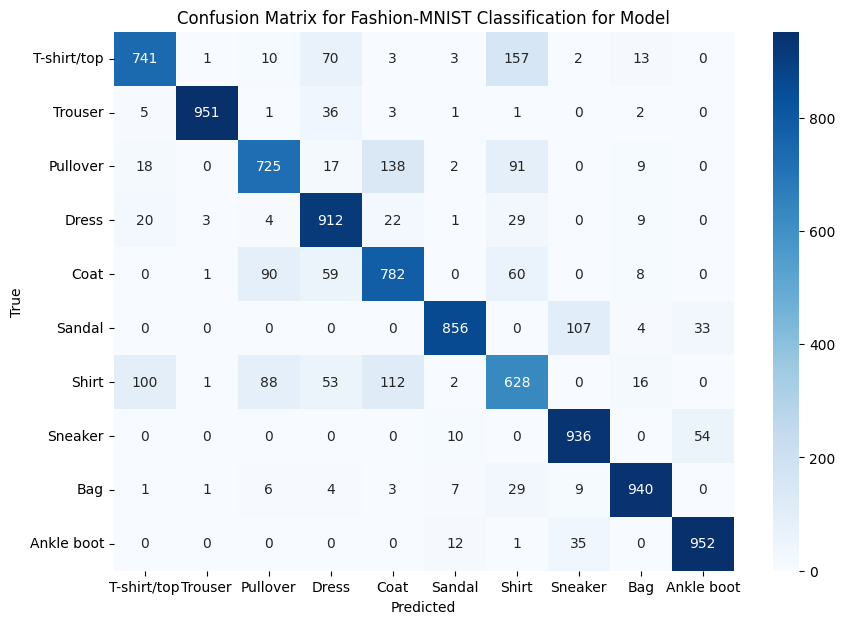

Two classes most confused with each other: T-shirt/top and Shirt

Training with lr=0.005, batch_size=32, hidden_layers=[128]
Epoch [1/5], Train Loss: 0.5269, Train Accuracy: 80.98%, Test Loss: 0.4880, Test Accuracy: 82.64%
Epoch [2/5], Train Loss: 0.4425, Train Accuracy: 83.81%, Test Loss: 0.4324, Test Accuracy: 84.54%
Epoch [3/5], Train Loss: 0.4182, Train Accuracy: 84.95%, Test Loss: 0.4667, Test Accuracy: 82.80%
Epoch [4/5], Train Loss: 0.4087, Train Accuracy: 85.40%, Test Loss: 0.4768, Test Accuracy: 82.83%
Epoch [5/5], Train Loss: 0.4004, Train Accuracy: 85.55%, Test Loss: 0.4332, Test Accuracy: 84.61%


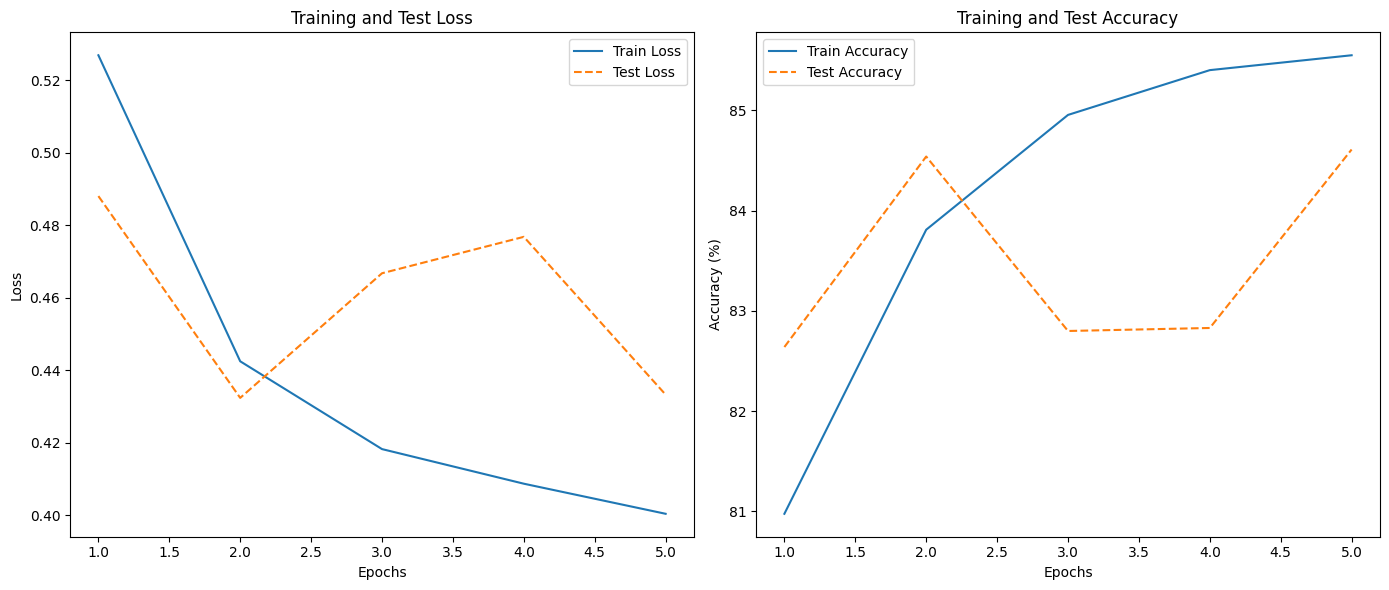

Test Accuracy: 84.61%


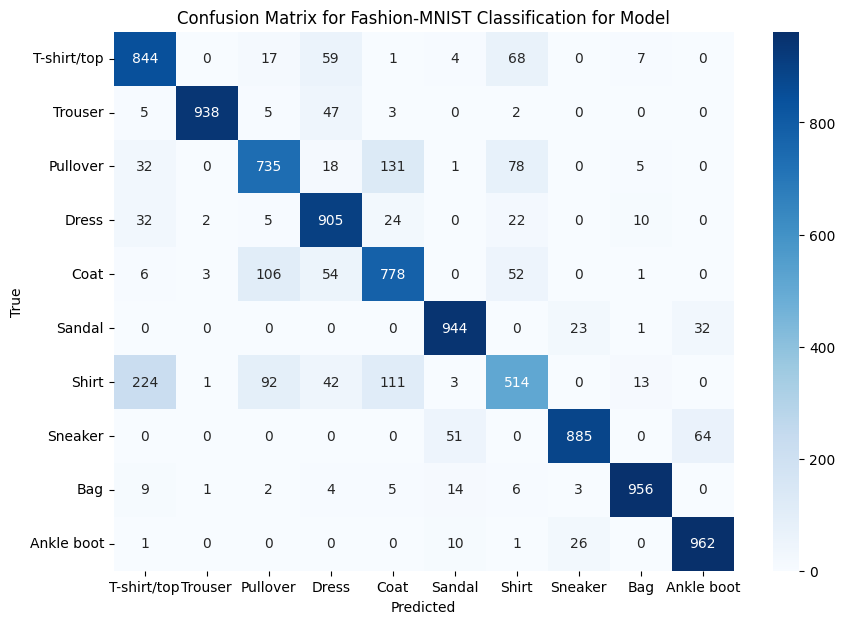

Two classes most confused with each other: Shirt and T-shirt/top

Training with lr=0.005, batch_size=64, hidden_layers=[64]
Epoch [1/5], Train Loss: 0.5155, Train Accuracy: 81.24%, Test Loss: 0.4835, Test Accuracy: 82.40%
Epoch [2/5], Train Loss: 0.4365, Train Accuracy: 84.18%, Test Loss: 0.4695, Test Accuracy: 83.68%
Epoch [3/5], Train Loss: 0.4172, Train Accuracy: 84.92%, Test Loss: 0.4662, Test Accuracy: 83.72%
Epoch [4/5], Train Loss: 0.4104, Train Accuracy: 85.19%, Test Loss: 0.4587, Test Accuracy: 83.02%
Epoch [5/5], Train Loss: 0.4055, Train Accuracy: 85.28%, Test Loss: 0.4357, Test Accuracy: 84.35%


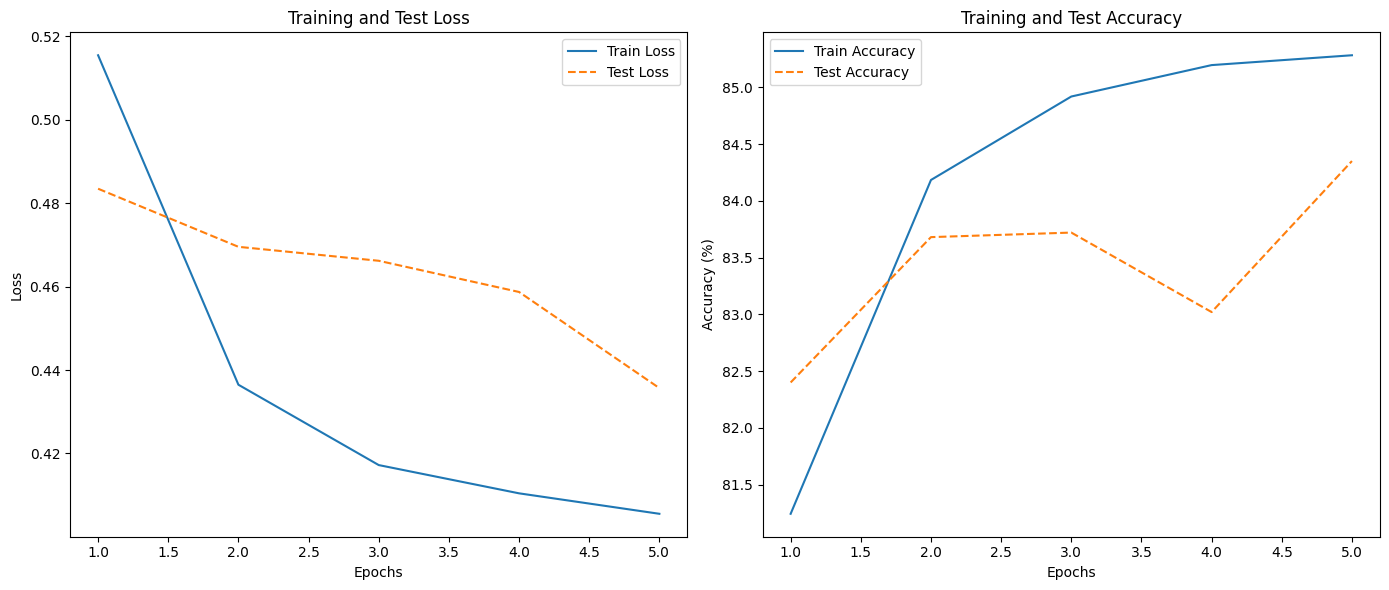

Test Accuracy: 84.35%


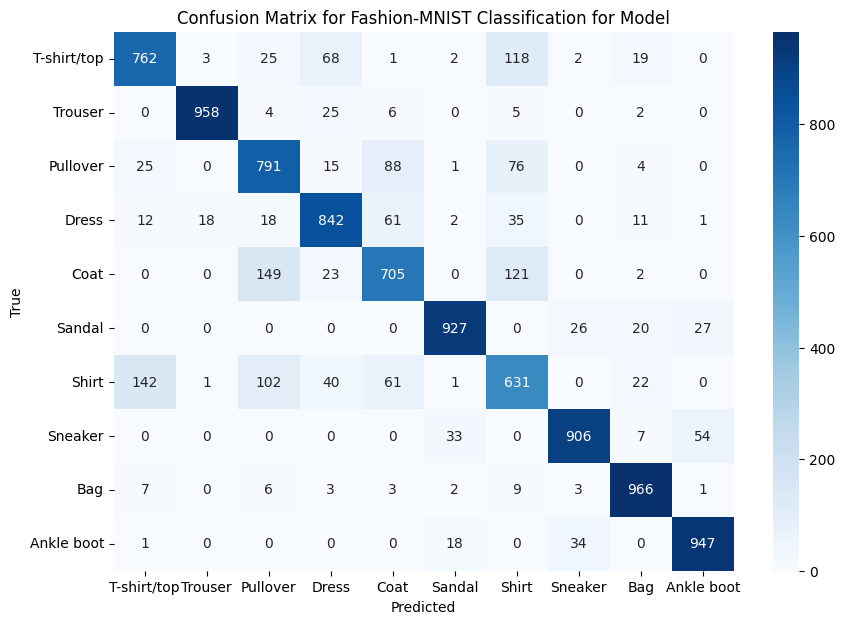

Two classes most confused with each other: Coat and Pullover

Training with lr=0.005, batch_size=64, hidden_layers=[64, 128]
Epoch [1/5], Train Loss: 0.5293, Train Accuracy: 80.80%, Test Loss: 0.5194, Test Accuracy: 81.08%
Epoch [2/5], Train Loss: 0.4324, Train Accuracy: 84.47%, Test Loss: 0.4824, Test Accuracy: 82.07%
Epoch [3/5], Train Loss: 0.4142, Train Accuracy: 85.09%, Test Loss: 0.4560, Test Accuracy: 84.78%
Epoch [4/5], Train Loss: 0.4033, Train Accuracy: 85.33%, Test Loss: 0.4620, Test Accuracy: 84.39%
Epoch [5/5], Train Loss: 0.3932, Train Accuracy: 85.74%, Test Loss: 0.4449, Test Accuracy: 84.04%


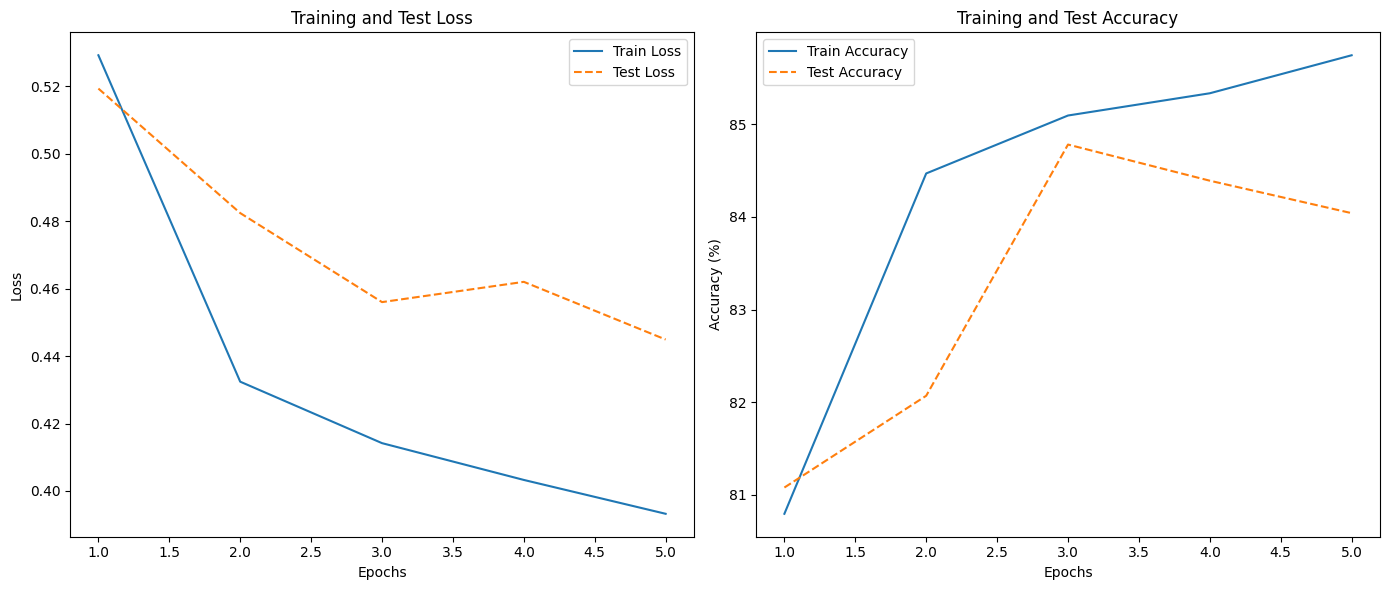

Test Accuracy: 84.04%


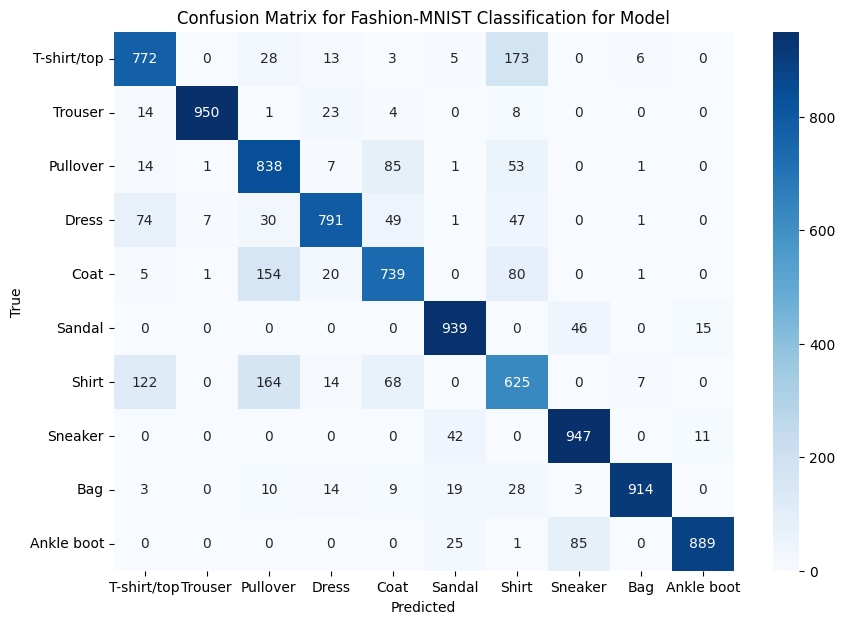

Two classes most confused with each other: T-shirt/top and Shirt

Training with lr=0.005, batch_size=64, hidden_layers=[128]
Epoch [1/5], Train Loss: 0.5160, Train Accuracy: 81.36%, Test Loss: 0.4653, Test Accuracy: 83.08%
Epoch [2/5], Train Loss: 0.4367, Train Accuracy: 84.15%, Test Loss: 0.4480, Test Accuracy: 83.81%
Epoch [3/5], Train Loss: 0.4204, Train Accuracy: 84.83%, Test Loss: 0.4704, Test Accuracy: 83.12%
Epoch [4/5], Train Loss: 0.4054, Train Accuracy: 85.24%, Test Loss: 0.4474, Test Accuracy: 84.12%
Epoch [5/5], Train Loss: 0.4034, Train Accuracy: 85.61%, Test Loss: 0.4417, Test Accuracy: 84.35%


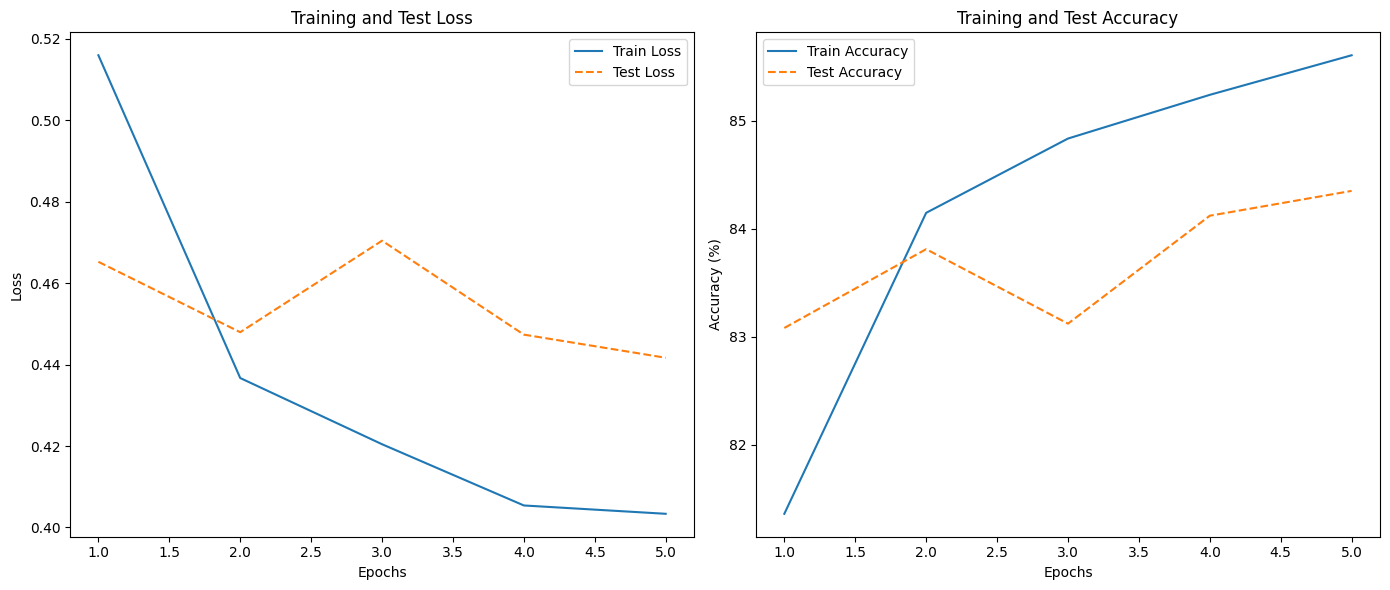

Test Accuracy: 84.35%


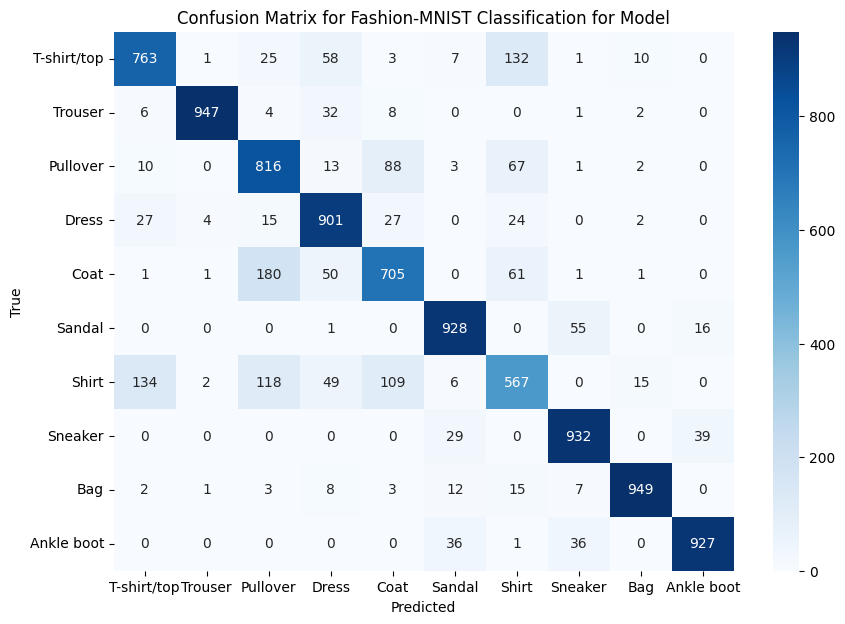

Two classes most confused with each other: Coat and Pullover

Training with lr=0.01, batch_size=16, hidden_layers=[64]
Epoch [1/5], Train Loss: 0.5685, Train Accuracy: 79.57%, Test Loss: 0.6578, Test Accuracy: 77.28%
Epoch [2/5], Train Loss: 0.5086, Train Accuracy: 82.18%, Test Loss: 0.6019, Test Accuracy: 79.36%
Epoch [3/5], Train Loss: 0.4948, Train Accuracy: 82.74%, Test Loss: 0.5090, Test Accuracy: 81.65%
Epoch [4/5], Train Loss: 0.4858, Train Accuracy: 83.03%, Test Loss: 0.5938, Test Accuracy: 79.51%
Epoch [5/5], Train Loss: 0.4875, Train Accuracy: 83.09%, Test Loss: 0.5151, Test Accuracy: 82.45%


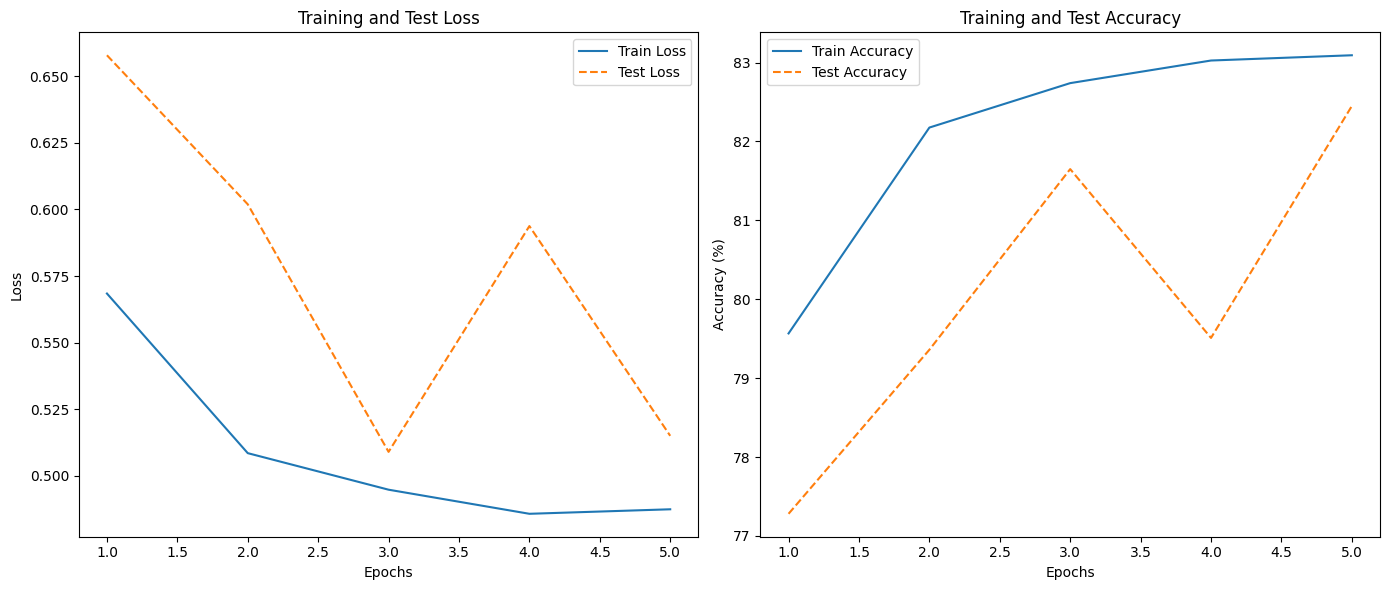

Test Accuracy: 82.45%


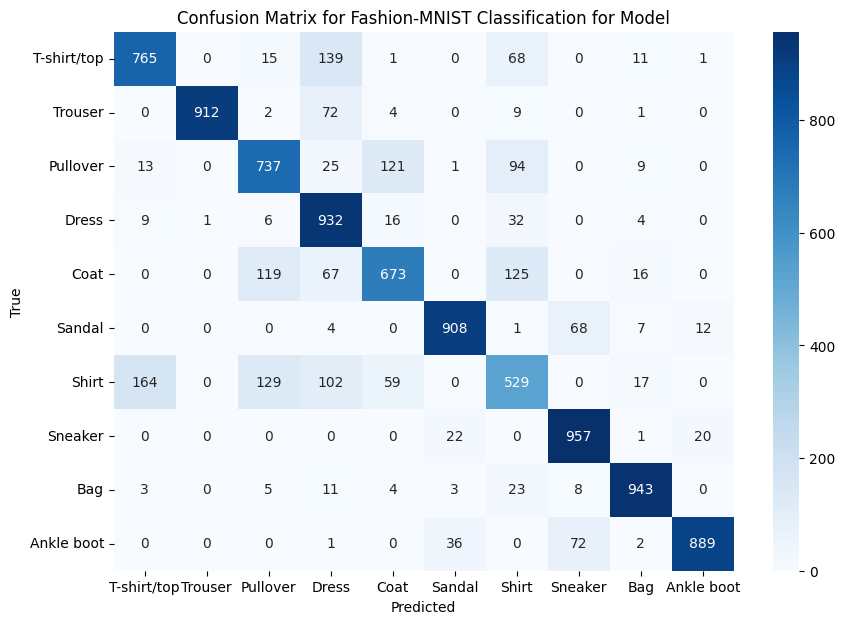

Two classes most confused with each other: Shirt and T-shirt/top

Training with lr=0.01, batch_size=16, hidden_layers=[64, 128]
Epoch [1/5], Train Loss: 0.5885, Train Accuracy: 79.02%, Test Loss: 0.5206, Test Accuracy: 81.73%
Epoch [2/5], Train Loss: 0.5076, Train Accuracy: 81.98%, Test Loss: 0.5147, Test Accuracy: 81.66%
Epoch [3/5], Train Loss: 0.4865, Train Accuracy: 82.67%, Test Loss: 0.5339, Test Accuracy: 80.79%
Epoch [4/5], Train Loss: 0.4847, Train Accuracy: 82.99%, Test Loss: 0.5358, Test Accuracy: 81.81%
Epoch [5/5], Train Loss: 0.4953, Train Accuracy: 82.63%, Test Loss: 0.5731, Test Accuracy: 79.37%


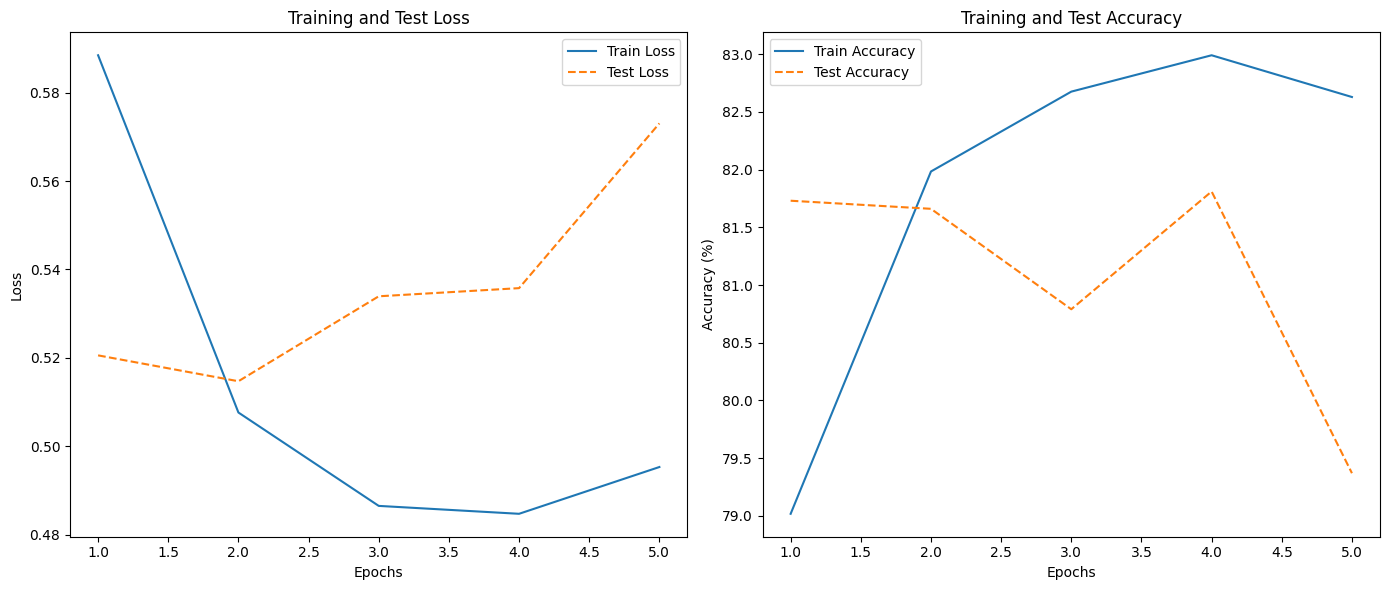

Test Accuracy: 79.37%


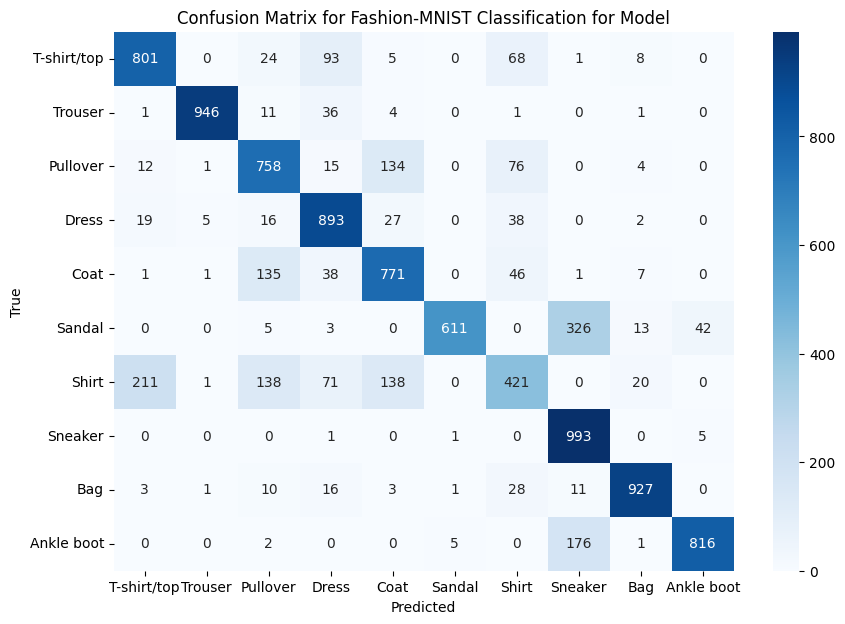

Two classes most confused with each other: Sandal and Sneaker

Training with lr=0.01, batch_size=16, hidden_layers=[128]
Epoch [1/5], Train Loss: 0.5687, Train Accuracy: 79.94%, Test Loss: 0.5697, Test Accuracy: 80.90%
Epoch [2/5], Train Loss: 0.5089, Train Accuracy: 82.37%, Test Loss: 0.5739, Test Accuracy: 80.02%
Epoch [3/5], Train Loss: 0.4931, Train Accuracy: 82.82%, Test Loss: 0.5365, Test Accuracy: 82.17%
Epoch [4/5], Train Loss: 0.4906, Train Accuracy: 83.02%, Test Loss: 0.5662, Test Accuracy: 81.15%
Epoch [5/5], Train Loss: 0.4919, Train Accuracy: 83.02%, Test Loss: 0.5607, Test Accuracy: 80.57%


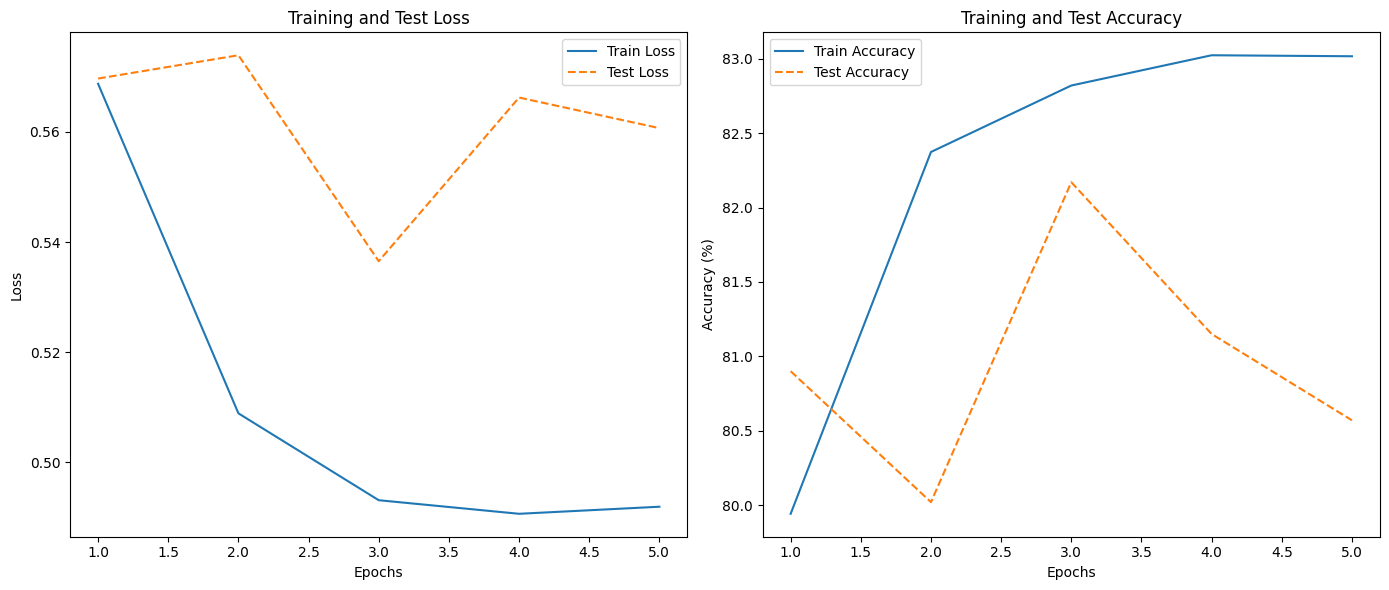

Test Accuracy: 80.57%


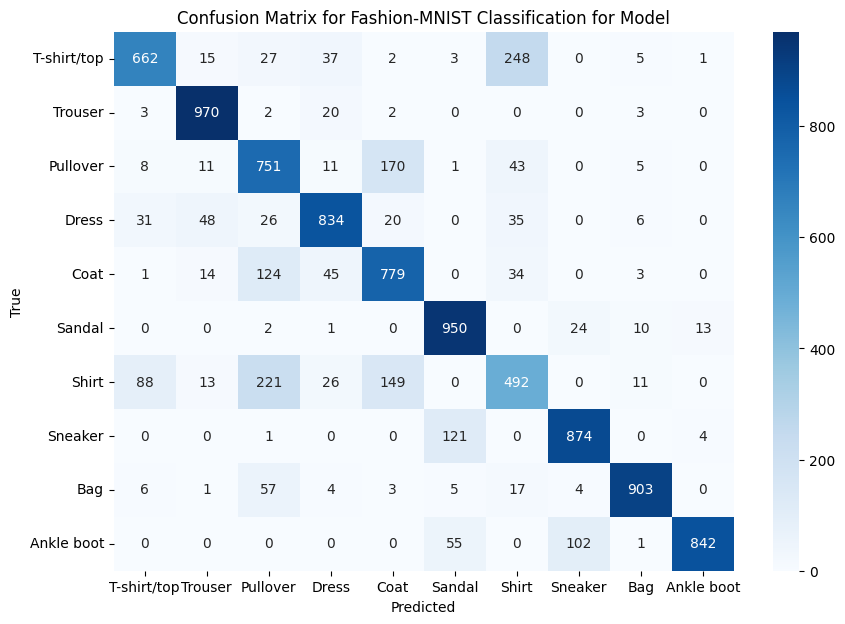

Two classes most confused with each other: T-shirt/top and Shirt

Training with lr=0.01, batch_size=32, hidden_layers=[64]
Epoch [1/5], Train Loss: 0.5735, Train Accuracy: 79.61%, Test Loss: 0.5299, Test Accuracy: 81.41%
Epoch [2/5], Train Loss: 0.5092, Train Accuracy: 81.89%, Test Loss: 0.6389, Test Accuracy: 79.23%
Epoch [3/5], Train Loss: 0.4943, Train Accuracy: 82.53%, Test Loss: 0.4880, Test Accuracy: 83.77%
Epoch [4/5], Train Loss: 0.4907, Train Accuracy: 82.71%, Test Loss: 0.5364, Test Accuracy: 81.02%
Epoch [5/5], Train Loss: 0.4944, Train Accuracy: 82.44%, Test Loss: 0.5041, Test Accuracy: 82.41%


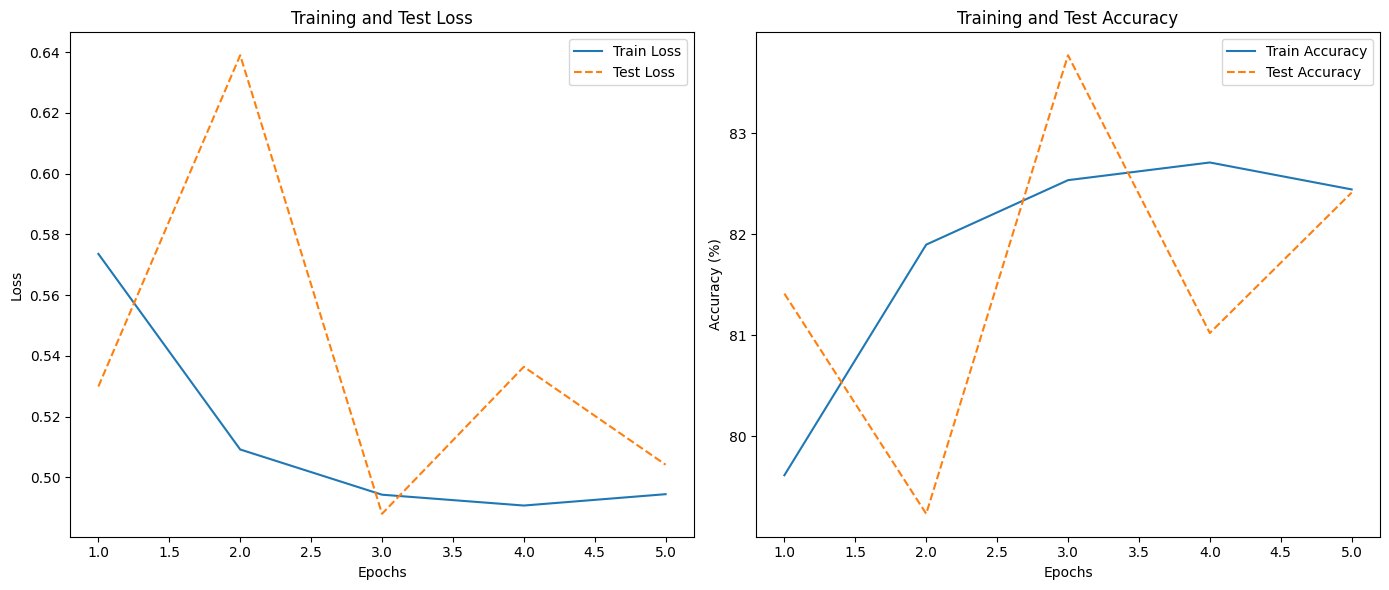

Test Accuracy: 82.41%


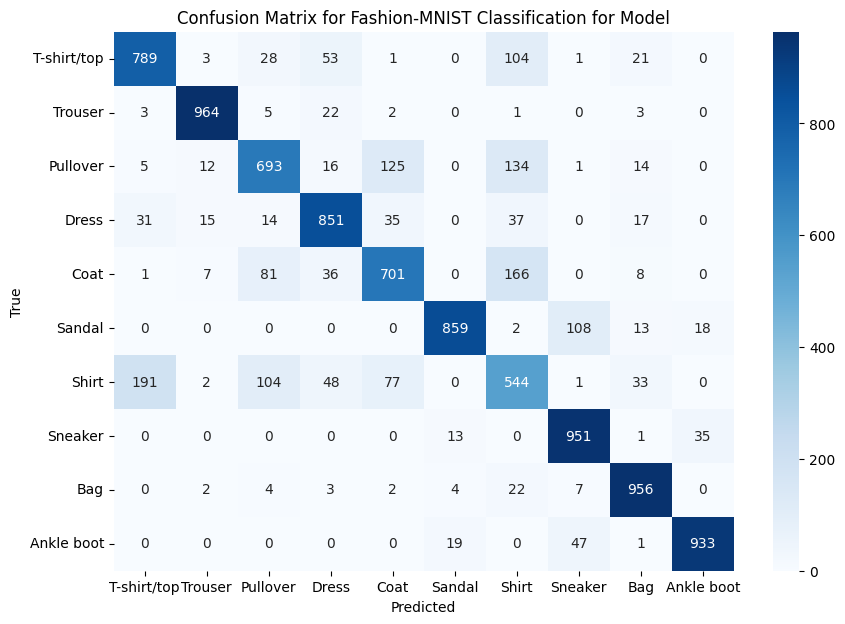

Two classes most confused with each other: Shirt and T-shirt/top

Training with lr=0.01, batch_size=32, hidden_layers=[64, 128]
Epoch [1/5], Train Loss: 0.5859, Train Accuracy: 79.18%, Test Loss: 0.5273, Test Accuracy: 81.00%
Epoch [2/5], Train Loss: 0.5101, Train Accuracy: 81.84%, Test Loss: 0.6026, Test Accuracy: 77.02%
Epoch [3/5], Train Loss: 0.4944, Train Accuracy: 82.74%, Test Loss: 0.6325, Test Accuracy: 79.31%
Epoch [4/5], Train Loss: 0.4849, Train Accuracy: 82.89%, Test Loss: 0.4838, Test Accuracy: 82.58%
Epoch [5/5], Train Loss: 0.4839, Train Accuracy: 82.96%, Test Loss: 0.5380, Test Accuracy: 81.69%


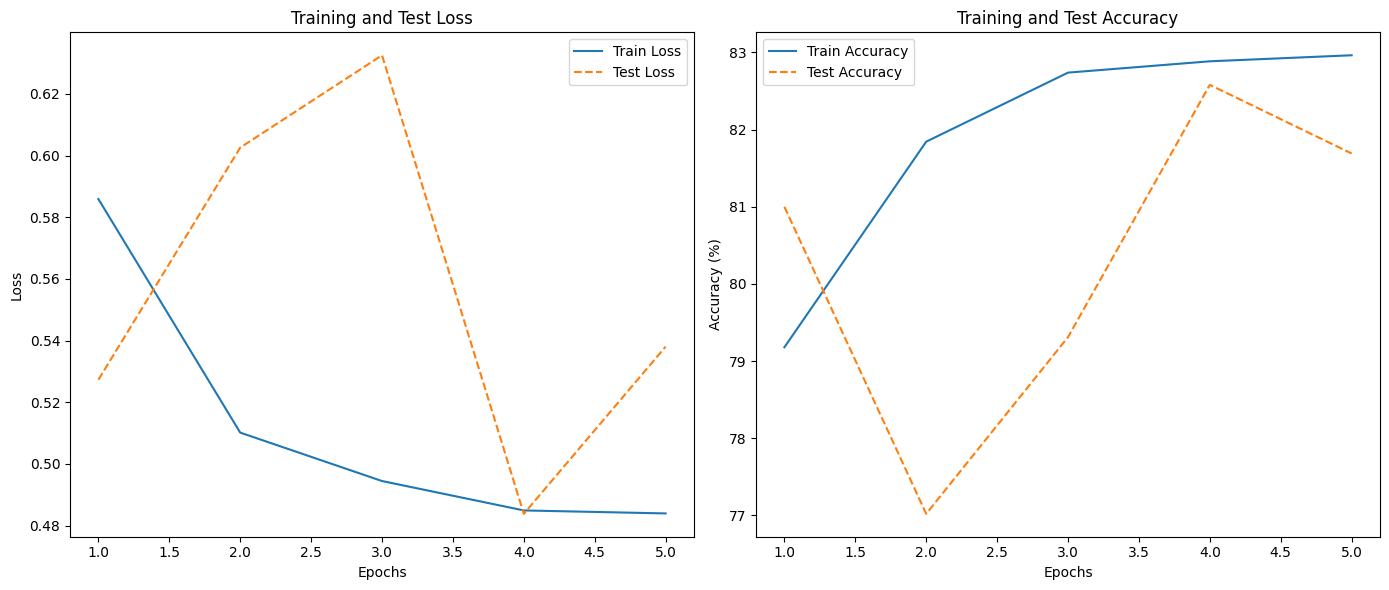

Test Accuracy: 81.69%


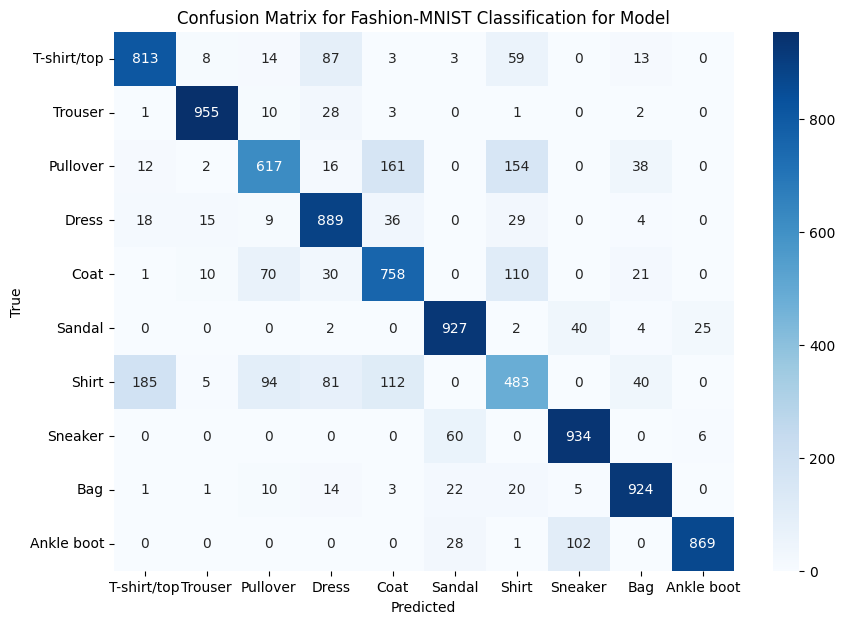

Two classes most confused with each other: Shirt and T-shirt/top

Training with lr=0.01, batch_size=32, hidden_layers=[128]
Epoch [1/5], Train Loss: 0.5782, Train Accuracy: 79.56%, Test Loss: 0.5796, Test Accuracy: 81.05%
Epoch [2/5], Train Loss: 0.5063, Train Accuracy: 82.28%, Test Loss: 0.5229, Test Accuracy: 82.07%
Epoch [3/5], Train Loss: 0.4897, Train Accuracy: 82.97%, Test Loss: 0.5064, Test Accuracy: 81.79%
Epoch [4/5], Train Loss: 0.4890, Train Accuracy: 83.02%, Test Loss: 0.5162, Test Accuracy: 82.60%
Epoch [5/5], Train Loss: 0.4926, Train Accuracy: 83.02%, Test Loss: 0.5390, Test Accuracy: 80.97%


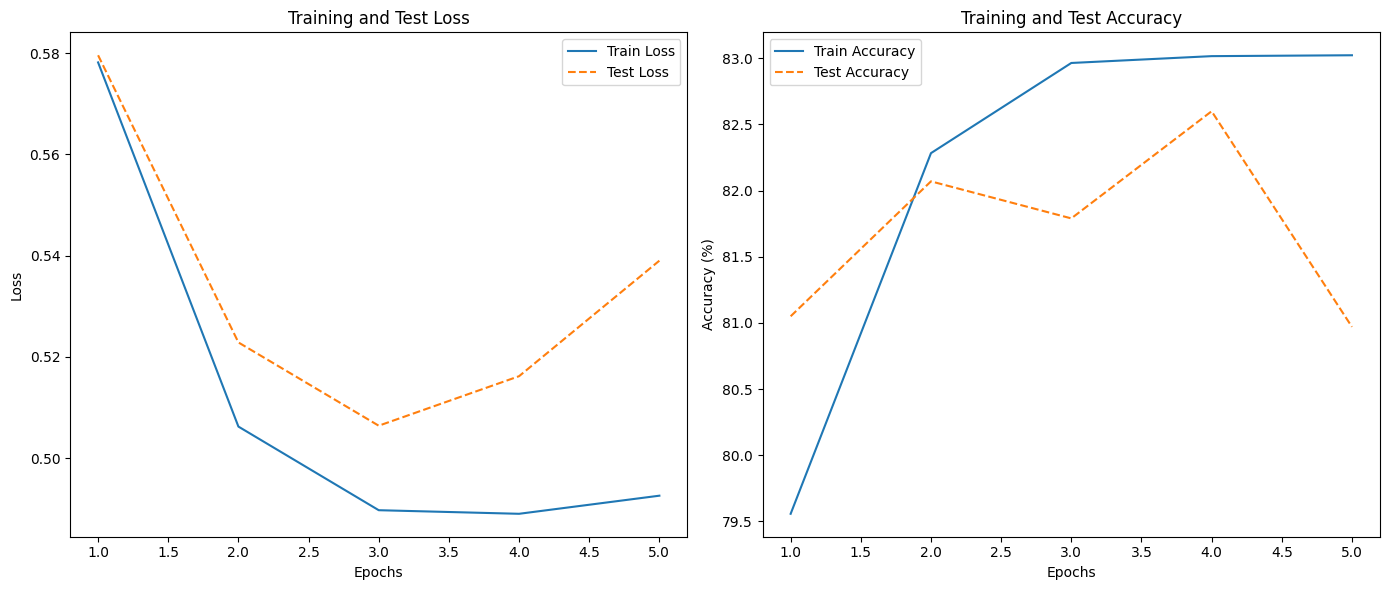

Test Accuracy: 80.97%


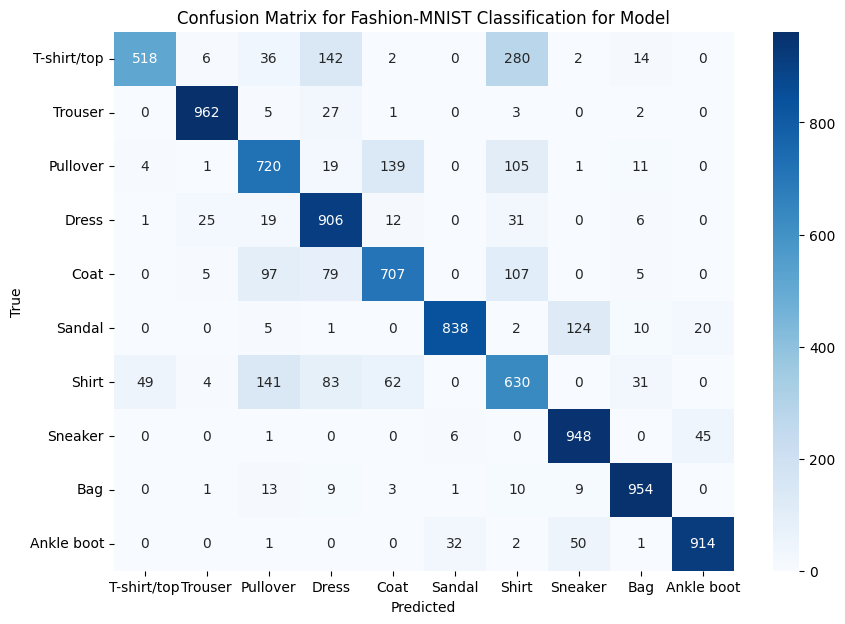

Two classes most confused with each other: T-shirt/top and Shirt

Training with lr=0.01, batch_size=64, hidden_layers=[64]
Epoch [1/5], Train Loss: 0.5852, Train Accuracy: 79.42%, Test Loss: 0.5236, Test Accuracy: 81.85%
Epoch [2/5], Train Loss: 0.5140, Train Accuracy: 82.21%, Test Loss: 0.5450, Test Accuracy: 81.69%
Epoch [3/5], Train Loss: 0.4935, Train Accuracy: 83.03%, Test Loss: 0.5201, Test Accuracy: 82.58%
Epoch [4/5], Train Loss: 0.4884, Train Accuracy: 83.28%, Test Loss: 0.5183, Test Accuracy: 82.56%
Epoch [5/5], Train Loss: 0.4838, Train Accuracy: 83.27%, Test Loss: 0.5016, Test Accuracy: 82.68%


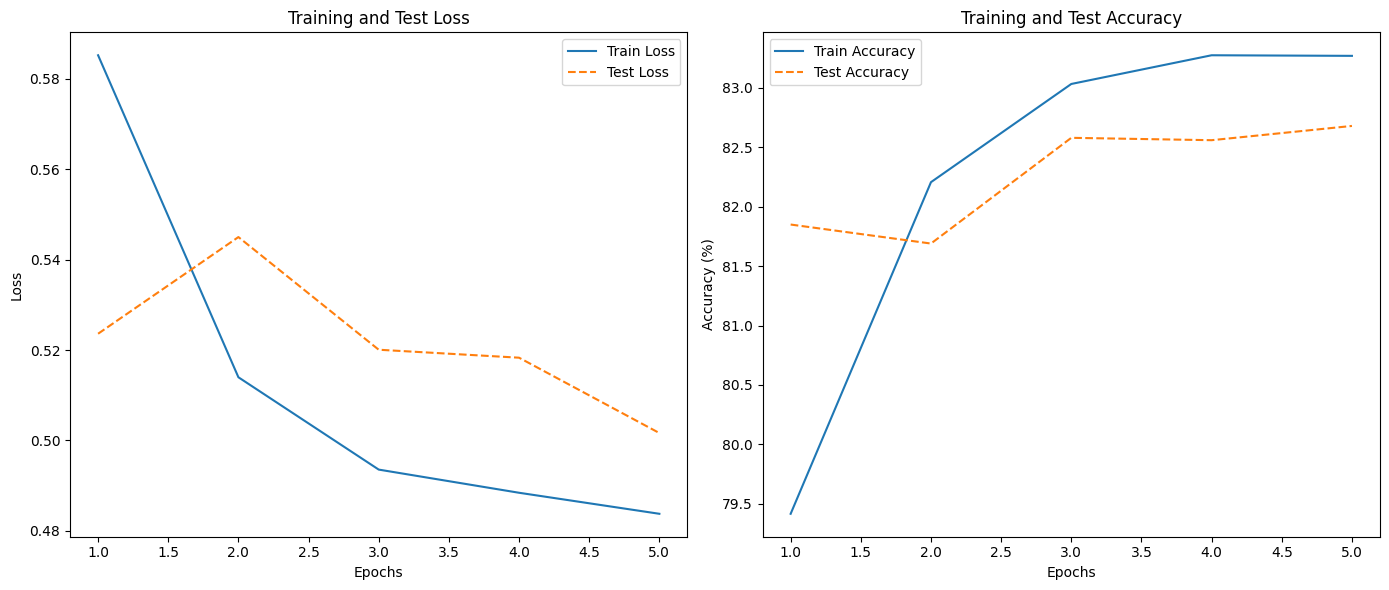

Test Accuracy: 82.68%


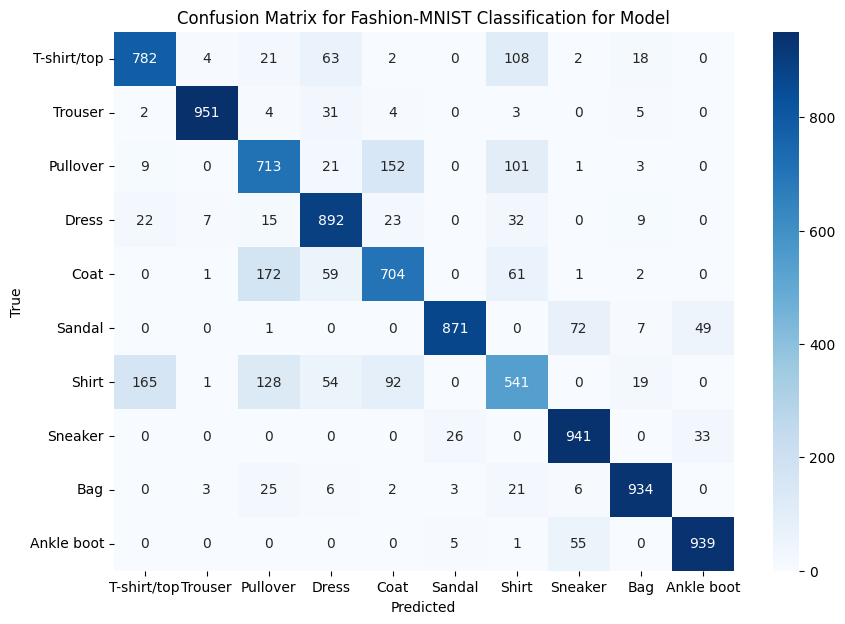

Two classes most confused with each other: Coat and Pullover

Training with lr=0.01, batch_size=64, hidden_layers=[64, 128]
Epoch [1/5], Train Loss: 0.5948, Train Accuracy: 78.94%, Test Loss: 0.5775, Test Accuracy: 79.09%
Epoch [2/5], Train Loss: 0.5000, Train Accuracy: 82.57%, Test Loss: 0.5159, Test Accuracy: 81.89%
Epoch [3/5], Train Loss: 0.4861, Train Accuracy: 82.78%, Test Loss: 0.5131, Test Accuracy: 82.14%
Epoch [4/5], Train Loss: 0.4810, Train Accuracy: 83.19%, Test Loss: 0.4964, Test Accuracy: 83.11%
Epoch [5/5], Train Loss: 0.4781, Train Accuracy: 83.23%, Test Loss: 0.4884, Test Accuracy: 82.96%


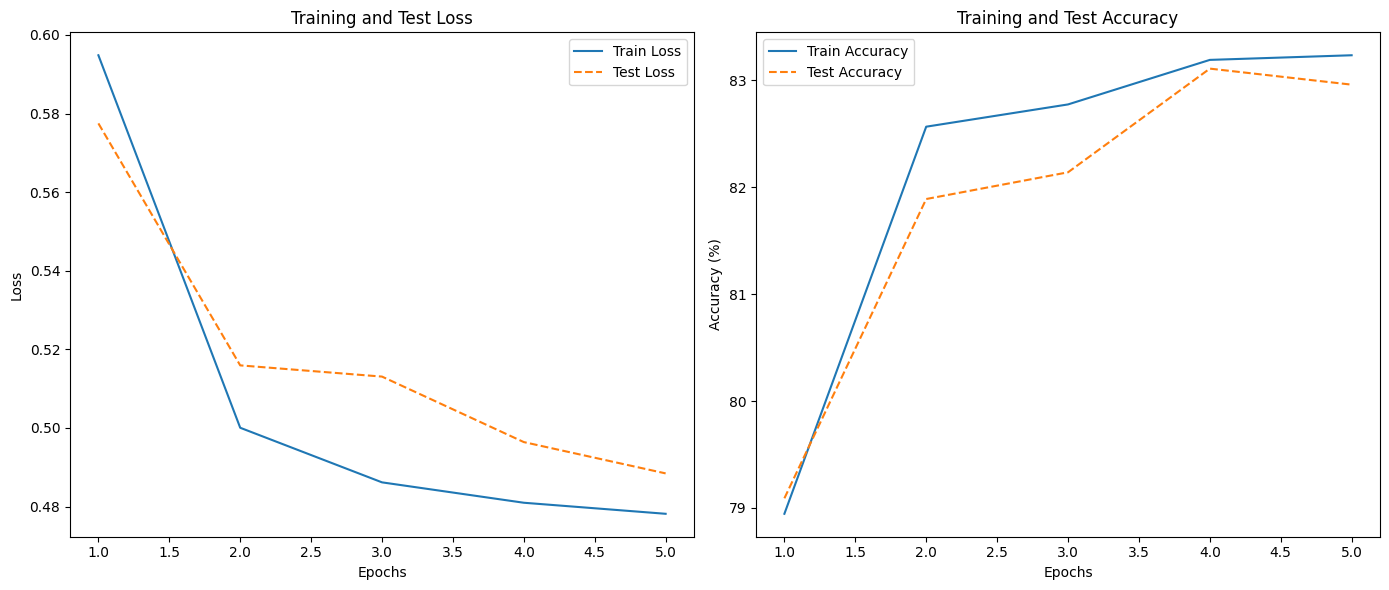

Test Accuracy: 82.96%


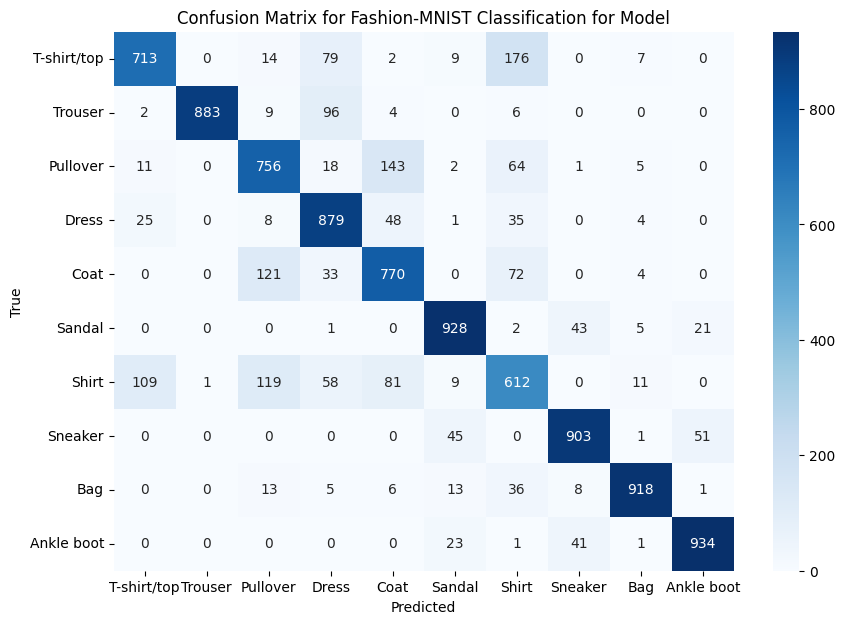

Two classes most confused with each other: T-shirt/top and Shirt

Training with lr=0.01, batch_size=64, hidden_layers=[128]
Epoch [1/5], Train Loss: 0.5895, Train Accuracy: 79.10%, Test Loss: 0.5198, Test Accuracy: 81.70%
Epoch [2/5], Train Loss: 0.5172, Train Accuracy: 81.75%, Test Loss: 0.6147, Test Accuracy: 78.77%
Epoch [3/5], Train Loss: 0.4940, Train Accuracy: 82.85%, Test Loss: 0.5108, Test Accuracy: 82.19%
Epoch [4/5], Train Loss: 0.4893, Train Accuracy: 82.90%, Test Loss: 0.5072, Test Accuracy: 82.79%
Epoch [5/5], Train Loss: 0.4832, Train Accuracy: 83.08%, Test Loss: 0.5428, Test Accuracy: 81.76%


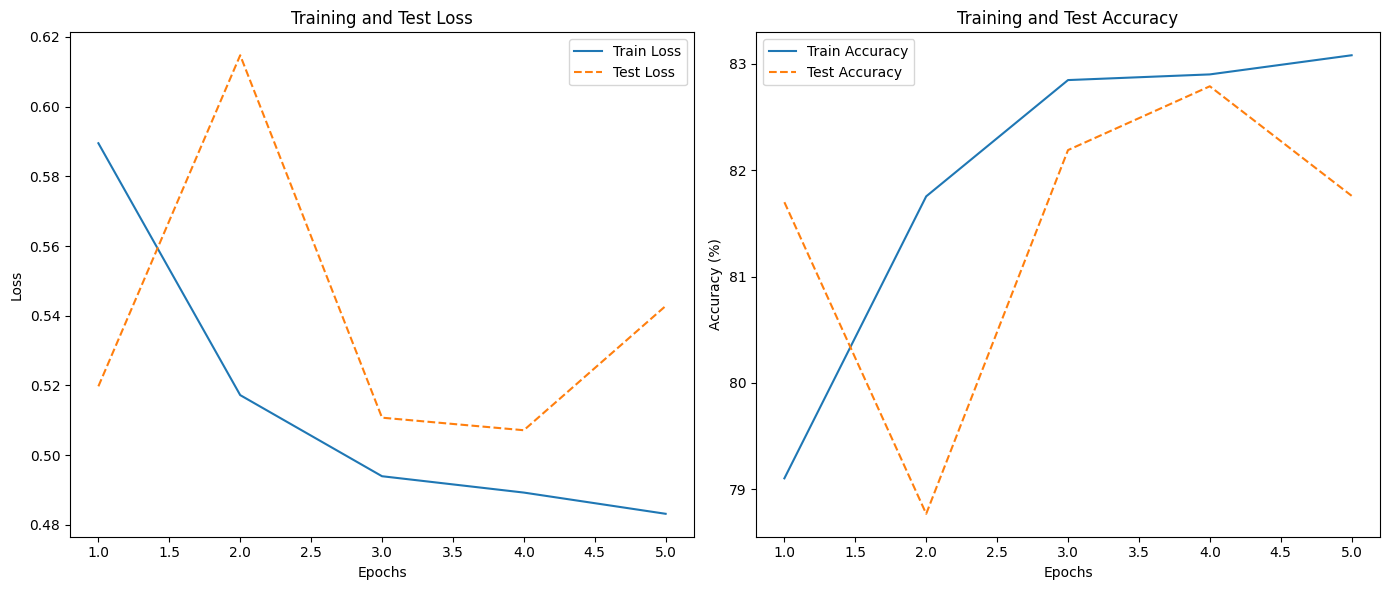

Test Accuracy: 81.76%


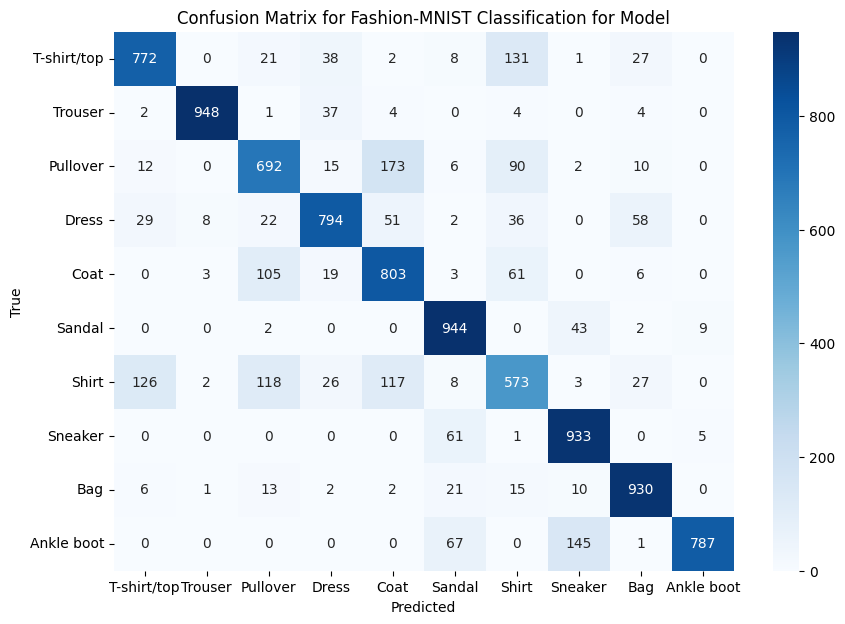

Two classes most confused with each other: Pullover and Coat

Best Hyperparameters:
{'learning_rate': 0.001, 'batch_size': 16, 'hidden_layers': [64, 128]}
Best Accuracy: 87.15%


In [9]:
results, best_params = grid_search(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    hidden_layers=hidden_layers,
    num_epochs=5
)